In [1]:
import cv2
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import random

In [2]:

class MarathonEnvironment(gym.Env):
    def __init__(self, environment_type):
        self.environment_type = environment_type
        self.environment_width = 4
        self.environment_height = 3
        self.observation_space = spaces.Discrete(self.environment_width * self.environment_height)
        self.action_space = spaces.Discrete(4)
        self.agent_pos = np.asarray([0, 0])
        self.drink_pos = np.asarray([[3, 1], [0, 1]])
        self.medal_pos = np.asarray([3, 2])
        self.medal_quantity = 1
        self.stone_pos = np.asarray([[2, 0]])
        self.current_state = 0
        self.reward_medal = 10.0
        self.reward_drink = 5.0
        self.penalty_stone = -2.0

    def reset(self):
        self.current_state = 0
        self.agent_pos = np.asarray([0, 0])
        self.medal_quantity = 1
        self.drink_pos = np.asarray([[3, 1], [0, 1]])
        self.stone_pos = np.asarray([[2, 0]])
        return self.current_state

    def step(self, action):
        max_x = self.environment_width - 1
        max_y = self.environment_height - 1
        reward = 0.0

        if action == 0 and self.agent_pos[0] < max_x:
            self.agent_pos[0] += 1
        elif action == 1 and self.agent_pos[0] > 0:
            self.agent_pos[0] -= 1
        elif action == 2 and self.agent_pos[1] < max_y:
            self.agent_pos[1] += 1
        elif action == 3 and self.agent_pos[1] > 0:
            self.agent_pos[1] -= 1

        
        self.agent_pos[0] = max(0, min(self.agent_pos[0], max_x))
        self.agent_pos[1] = max(0, min(self.agent_pos[1], max_y))

        
        self.current_state = self.agent_pos[1] * self.environment_width + self.agent_pos[0]

        
        if np.array_equal(self.agent_pos, self.medal_pos):
            reward += self.reward_medal
            self.medal_quantity -= 1

        for i, drink_pos in enumerate(self.drink_pos):
            if np.array_equal(self.agent_pos, drink_pos):
                reward += self.reward_drink
                self.drink_pos = np.delete(self.drink_pos, i, axis=0)
                break

        for stone_pos in self.stone_pos:
            if np.array_equal(self.agent_pos, stone_pos):
                reward += self.penalty_stone

        done = self.medal_quantity == 0

        return self.current_state, reward, done, {}

    def render(self, mode='human', plot=False):
        

        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xlim(0, 4)
        ax.set_ylim(0, 3)

        def plot_image(plot_pos):
            
            plot_agent, plot_stone, plot_medal, plot_drink = \
                False, False, False, False

            
            if np.array_equal(self.agent_pos, plot_pos):
                plot_agent = True
            if any(np.array_equal(self.stone_pos[i], plot_pos) for i in range(len(self.stone_pos))):
                plot_stone = True
            if self.medal_quantity > 0:  
                if np.array_equal(plot_pos, self.medal_pos):
                    plot_medal = True
            if any(np.array_equal(self.drink_pos[i], plot_pos) for i in range(len(self.drink_pos))):
                plot_drink = True
           
        
            if plot_agent and \
                    all(not item for item in
                        [plot_drink, plot_medal, plot_stone]):
                agent = AnnotationBbox(OffsetImage(plt.imread('images/man.jpg'), zoom=0.1),
                                       np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent)

            
            elif plot_stone and \
                    all(not item for item in
                        [plot_agent, plot_drink, plot_medal]):
                stone = AnnotationBbox(OffsetImage(plt.imread('images/stone.jpg'), zoom=0.28),
                                        np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(stone)

          
            elif plot_drink and \
                    all(not item for item in
                        [plot_agent, plot_medal, plot_stone]):
                drink = AnnotationBbox(OffsetImage(plt.imread('images/energydrink.jpeg'), zoom=0.28),
                                      np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(drink)

           
            elif plot_medal and \
                    all(not item for item in
                        [plot_agent, plot_stone, plot_drink]):
                medal = AnnotationBbox(OffsetImage(plt.imread('images/medal.jpeg'), zoom=0.28),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(medal)

            
            elif all(item for item in [plot_agent, plot_stone]) and \
                    all(not item for item in
                        [plot_medal, plot_drink]):
                agent_stone = AnnotationBbox(OffsetImage(plt.imread('images/man-stone.jpg'), zoom=0.1),
                                              np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_stone)

            
            elif all(item for item in [plot_agent, plot_drink]) and \
                    all(not item for item in
                        [plot_medal, plot_stone]):
                agent_drink = AnnotationBbox(OffsetImage(plt.imread('images/man-drink.png'), zoom=0.1),
                                           np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_drink)

            
            elif all(item for item in [plot_agent, plot_medal]) and \
                    all(not item for item in
                        [plot_drink, plot_stone]):
                agent_medal = AnnotationBbox(OffsetImage(plt.imread('images/man-medal.png'), zoom=0.1),
                                              np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_medal)

        coordinates_state_mapping_2 = {}
        for j in range(self.environment_height * self.environment_width):
            coordinates_state_mapping_2[j] = np.asarray(
                [j % self.environment_width, int(np.floor(j / self.environment_width))])

        
        for position in coordinates_state_mapping_2:
            plot_image(coordinates_state_mapping_2[position])

        plt.xticks([0, 1, 2, 3])
        plt.yticks([0, 1, 2])
        plt.grid()

        if plot:  
            plt.show()
        else:  
            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
            width = 60
            height = 60
            dim = (width, height)
            
            preprocessed_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            plt.show()
            return preprocessed_image




# Double Q-Learning

In [3]:
class DoubleQLearningAgent:
    def __init__(self, state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min):
        self.q_table_1 = np.zeros((state_space, action_space))
        self.q_table_2 = np.zeros((state_space, action_space))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.action_space = action_space

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_space)
        else:
            return np.argmax(self.q_table_1[state] + self.q_table_2[state])

    def update(self, state, action, reward, next_state, done):
        if np.random.rand() < 0.5:
            best_next_action = np.argmax(self.q_table_1[next_state])
            td_target = reward + self.gamma * self.q_table_2[next_state][best_next_action] * (not done)
            td_error = td_target - self.q_table_1[state][action]
            self.q_table_1[state][action] += self.alpha * td_error
        else:
            best_next_action = np.argmax(self.q_table_2[next_state])
            td_target = reward + self.gamma * self.q_table_1[next_state][best_next_action] * (not done)
            td_error = td_target - self.q_table_2[state][action]
            self.q_table_2[state][action] += self.alpha * td_error
        
        if done:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def end_episode(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


env = MarathonEnvironment(environment_type='deterministic')


state_space = env.observation_space.n
action_space = env.action_space.n
alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
agent = DoubleQLearningAgent(state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min)


episodes = 1000
for episode in range(episodes):
    state = env.reset()
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state


Initial Q-Table 1:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Initial Q-Table 2:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-Table 1:
[[ 5.9091823   8.81341737 16.89065185 11.17723151]
 [ 1.54036412 13.05678136  5.08051493  1.03268808]
 [ 4.05065773  1.0458039  10.23455622  1.01001579]
 [ 1.38488576  0.0512002   8.61758141  2.14412738]
 [13.08625     9.01203099  4.77458206  9.61003107]
 [13.74051312  8.0818838   5.87094695  4.6715231 ]
 [14.5         8.26519195  4.15495167  3.75936521]
 [ 7.99682266  7.56929712 10.          5.37598993]
 [ 1.16930094  1.67453588  1.45779106  6.99184503]
 [ 0.8361995   0.72308629  1.16047049  8.78390338]
 [ 8.33228183  0.44578602  0.1805      1.94977251]
 [ 0.          0. 

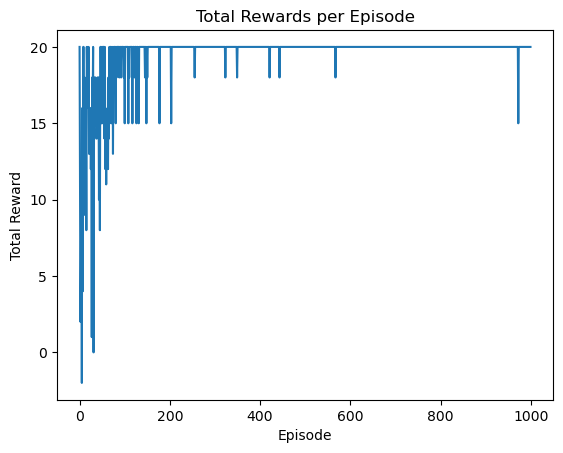

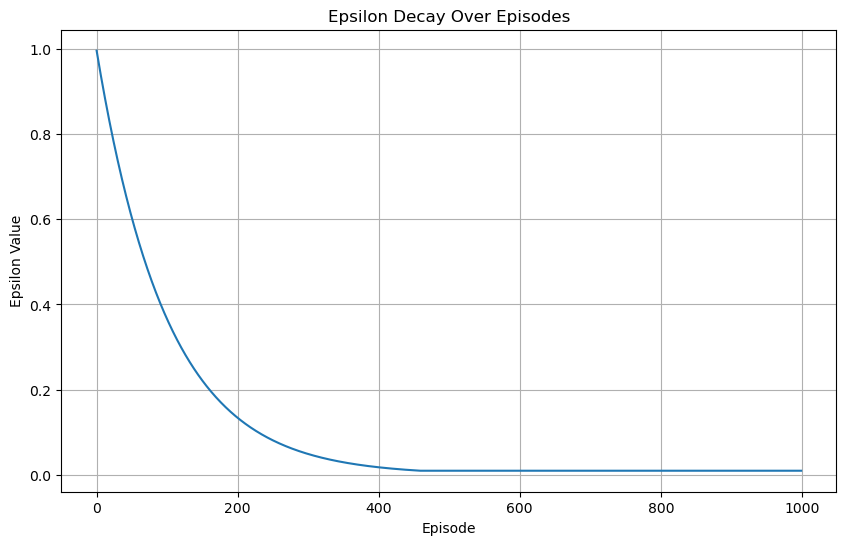

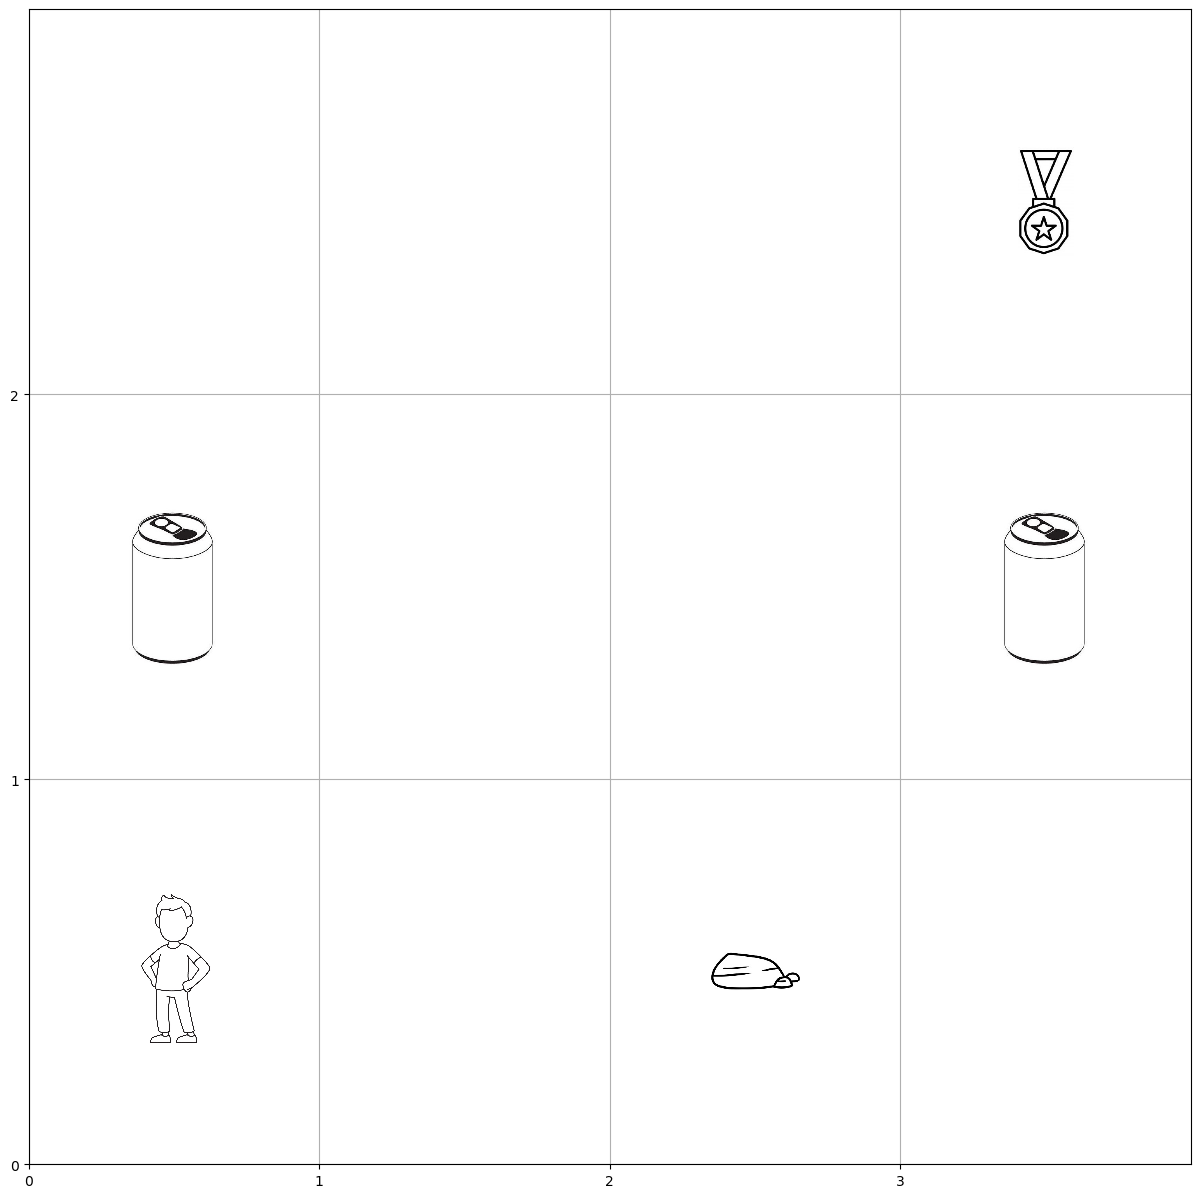

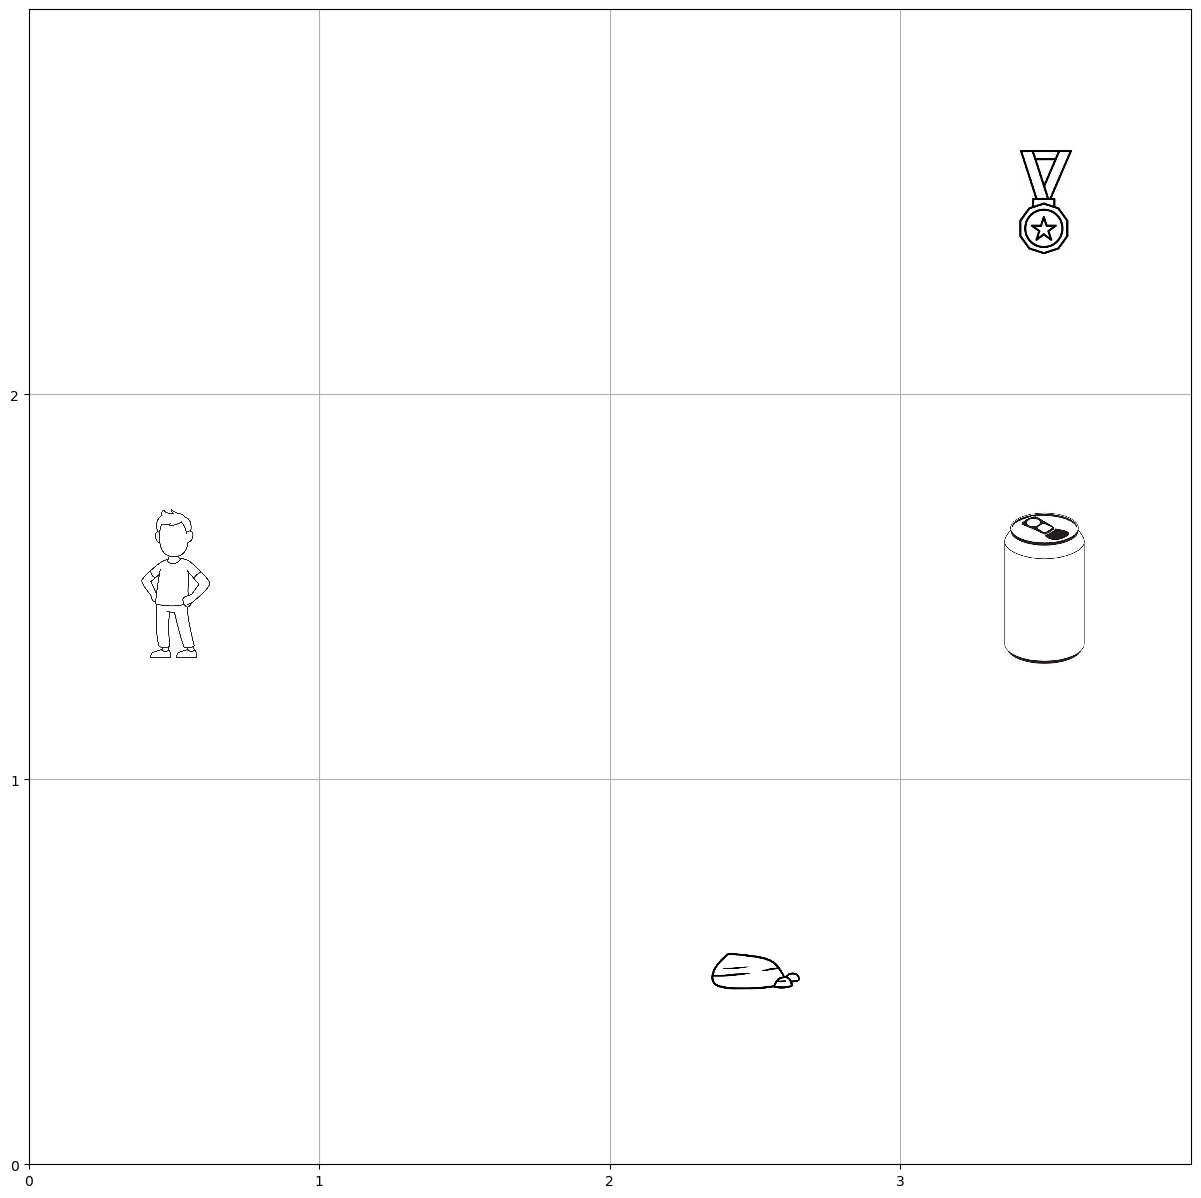

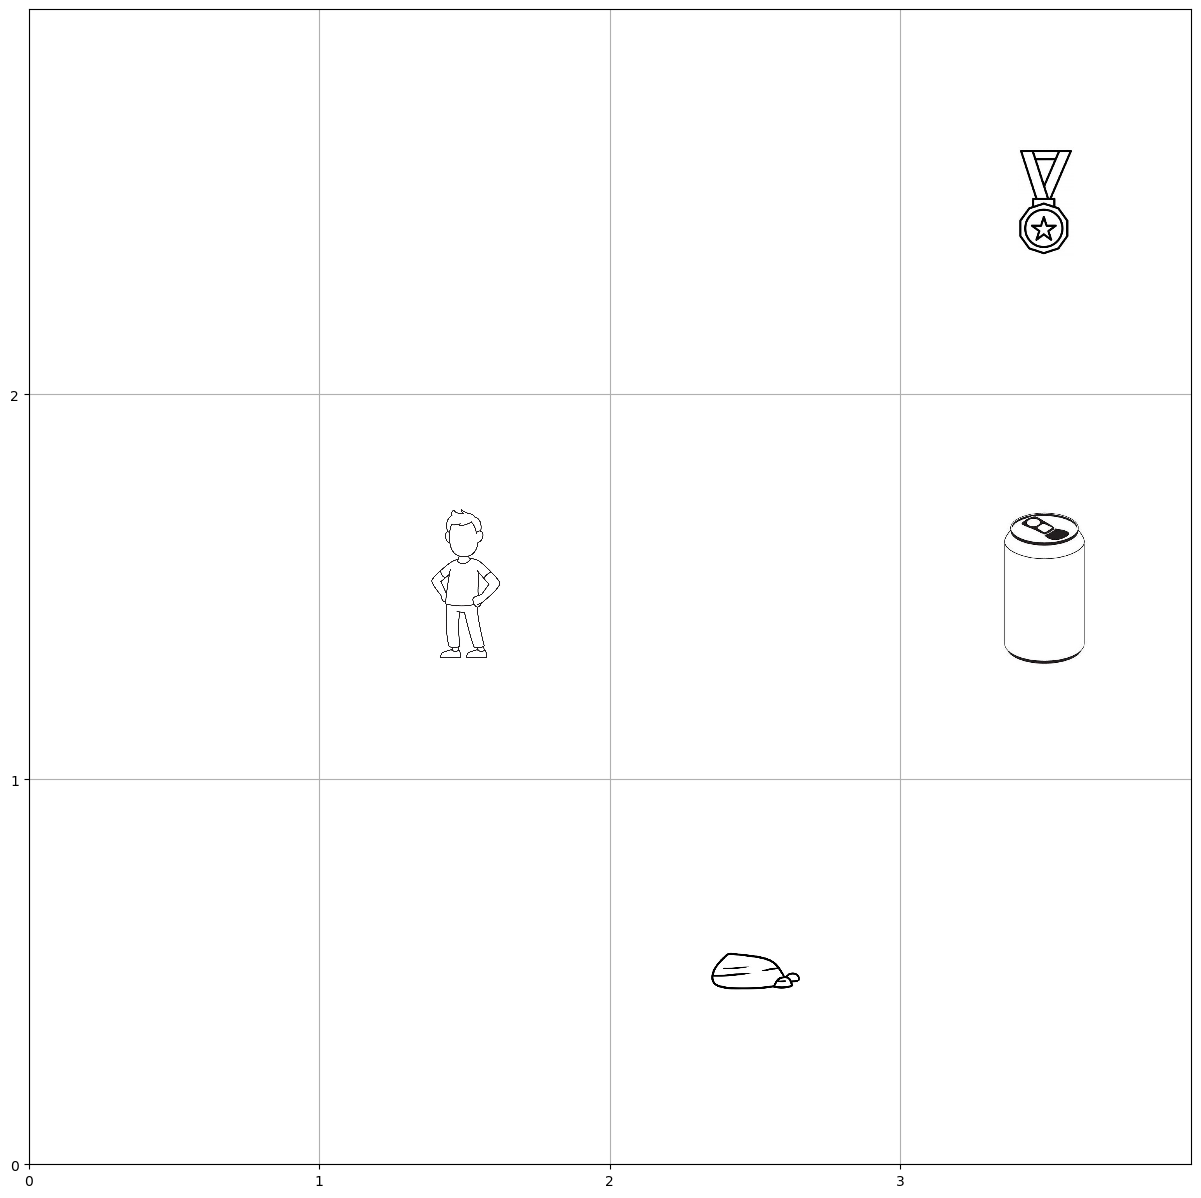

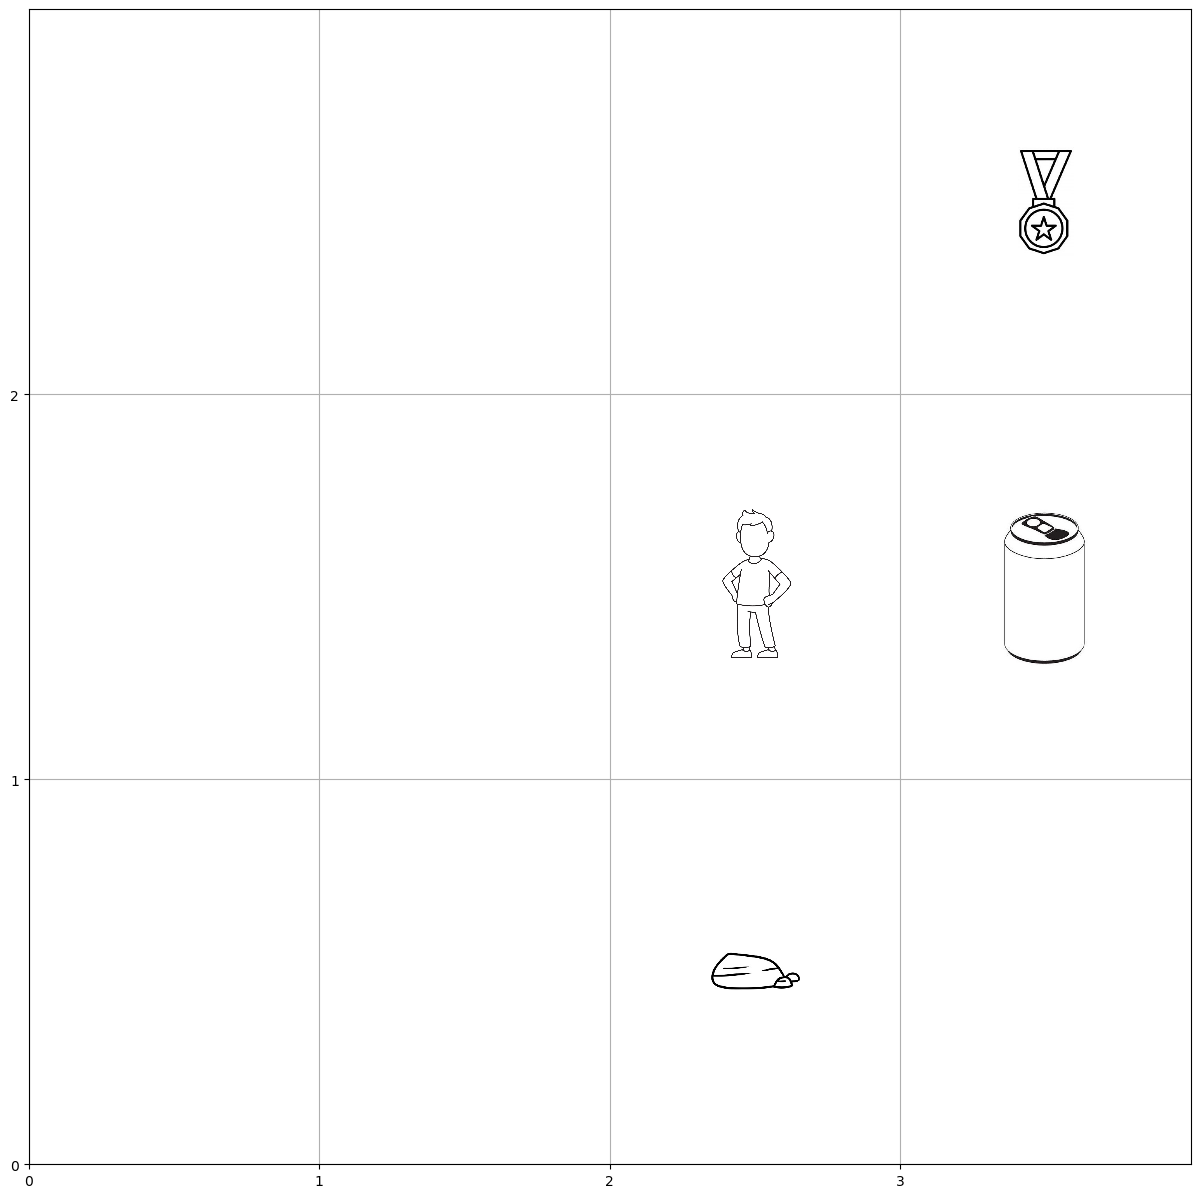

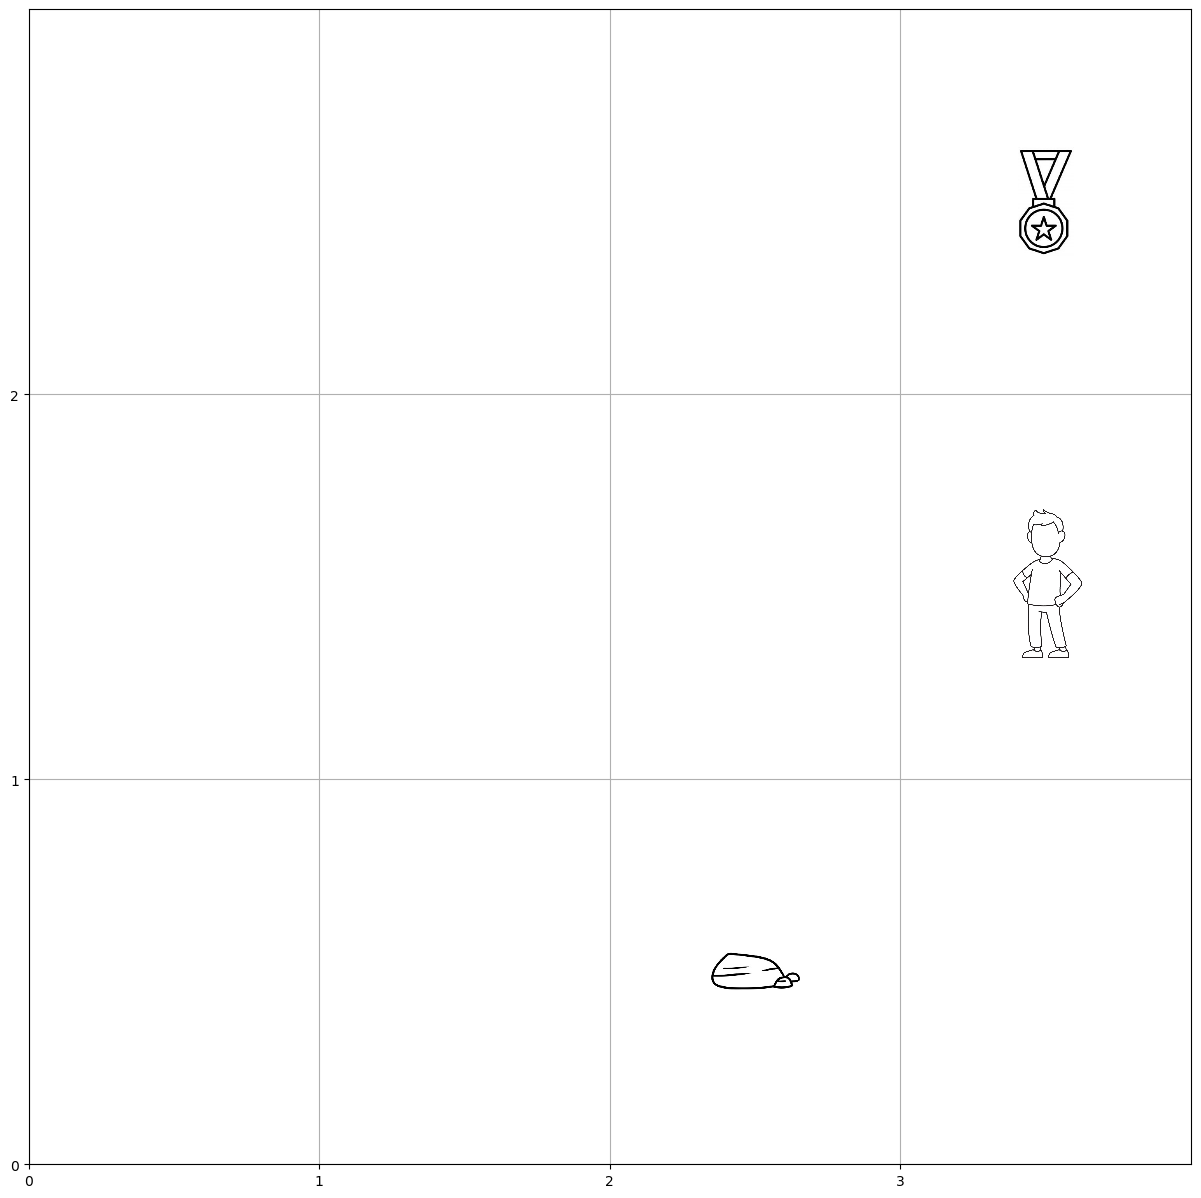

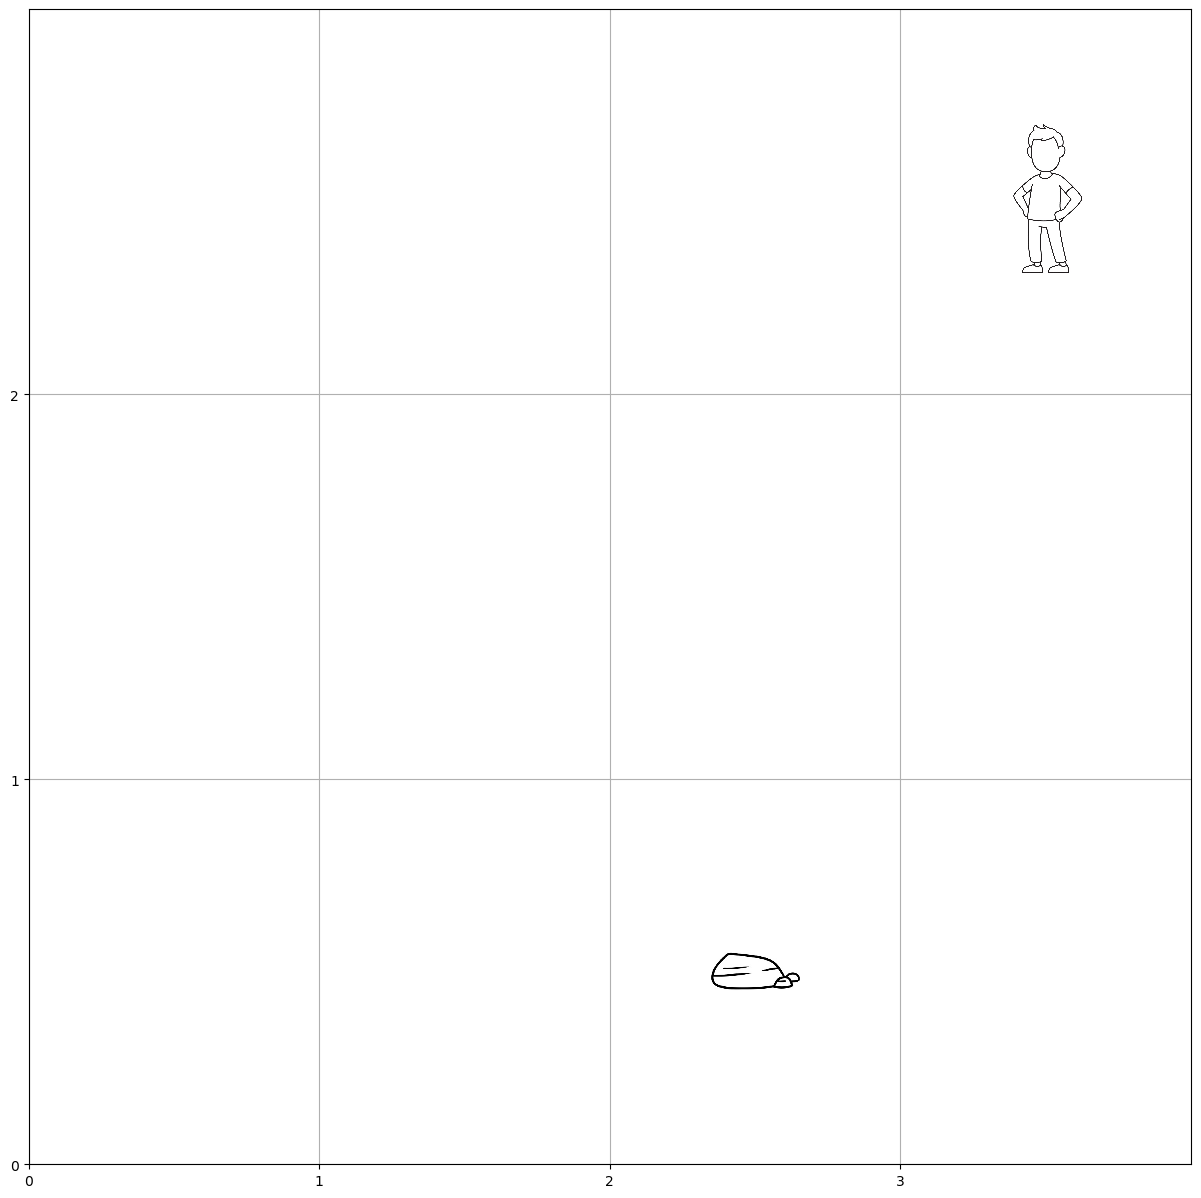

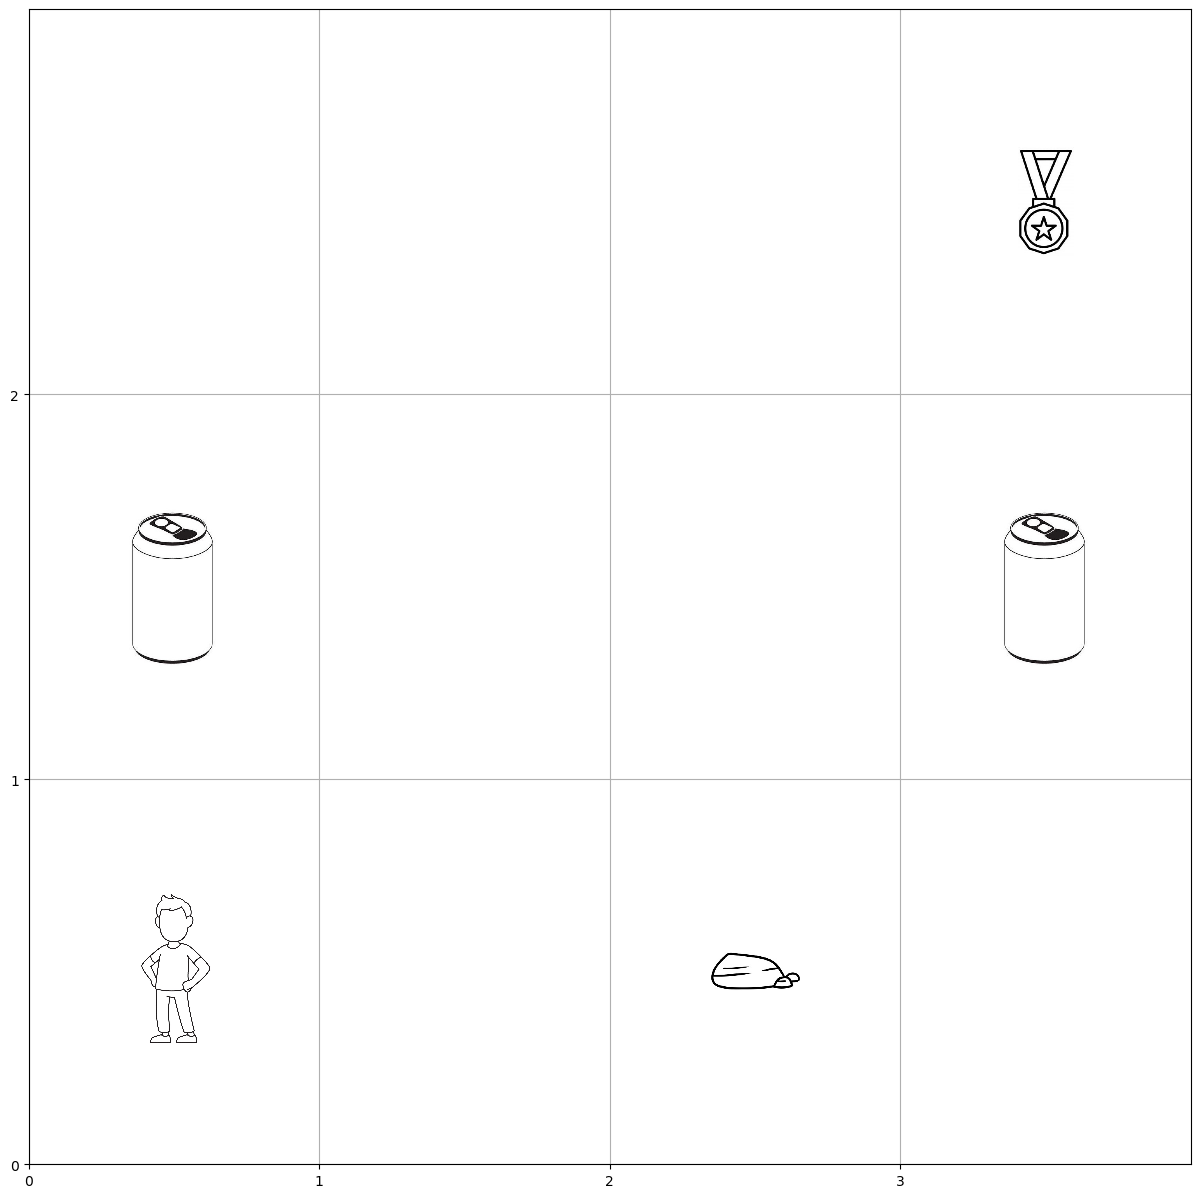

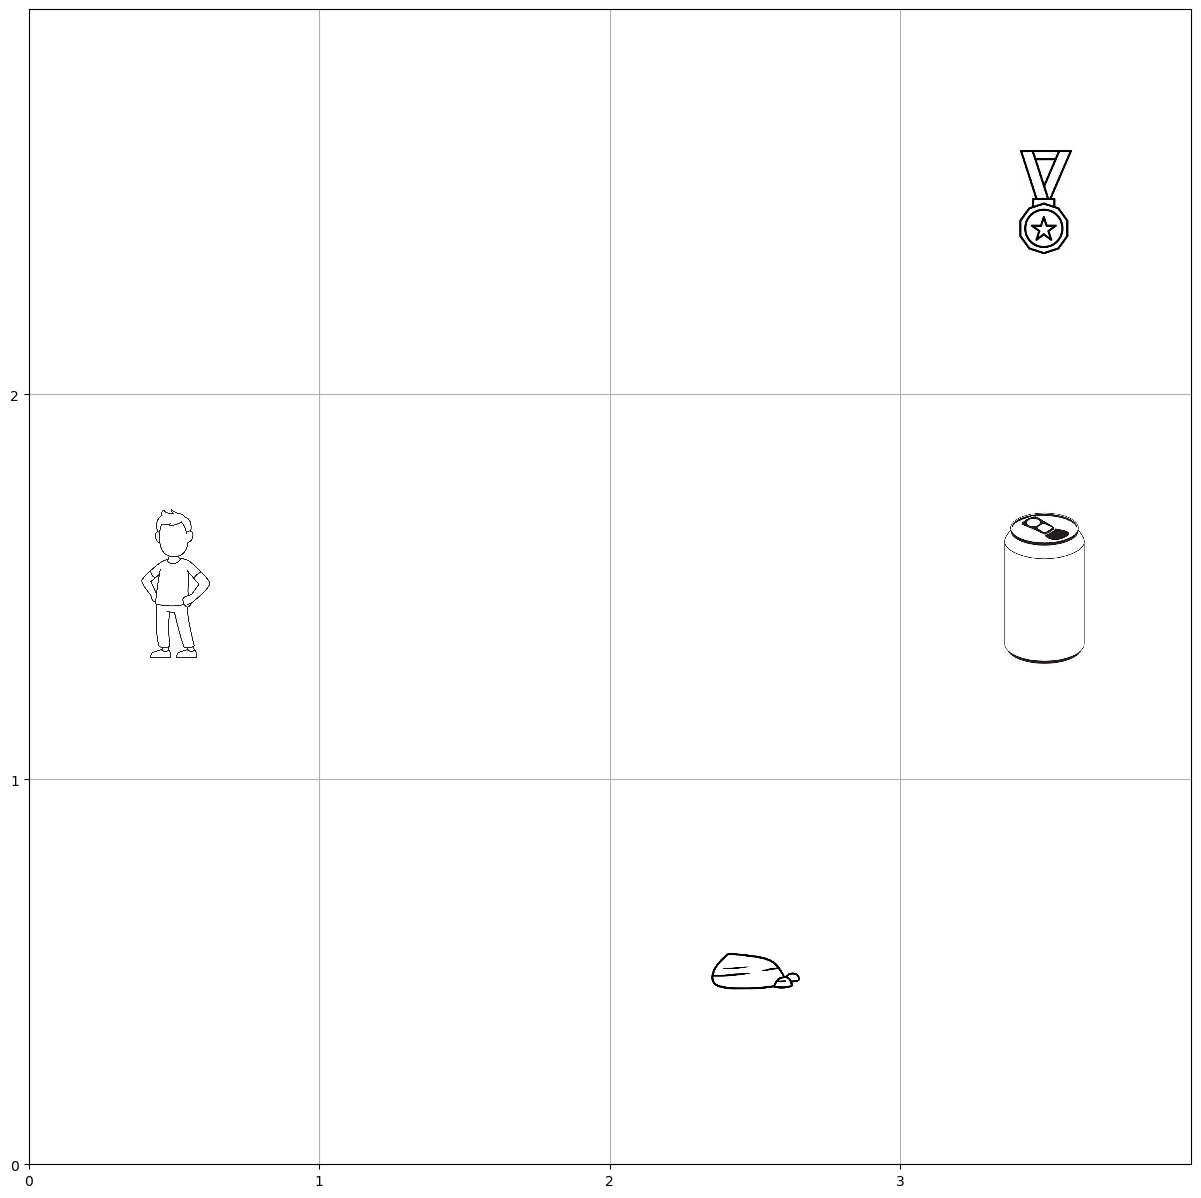

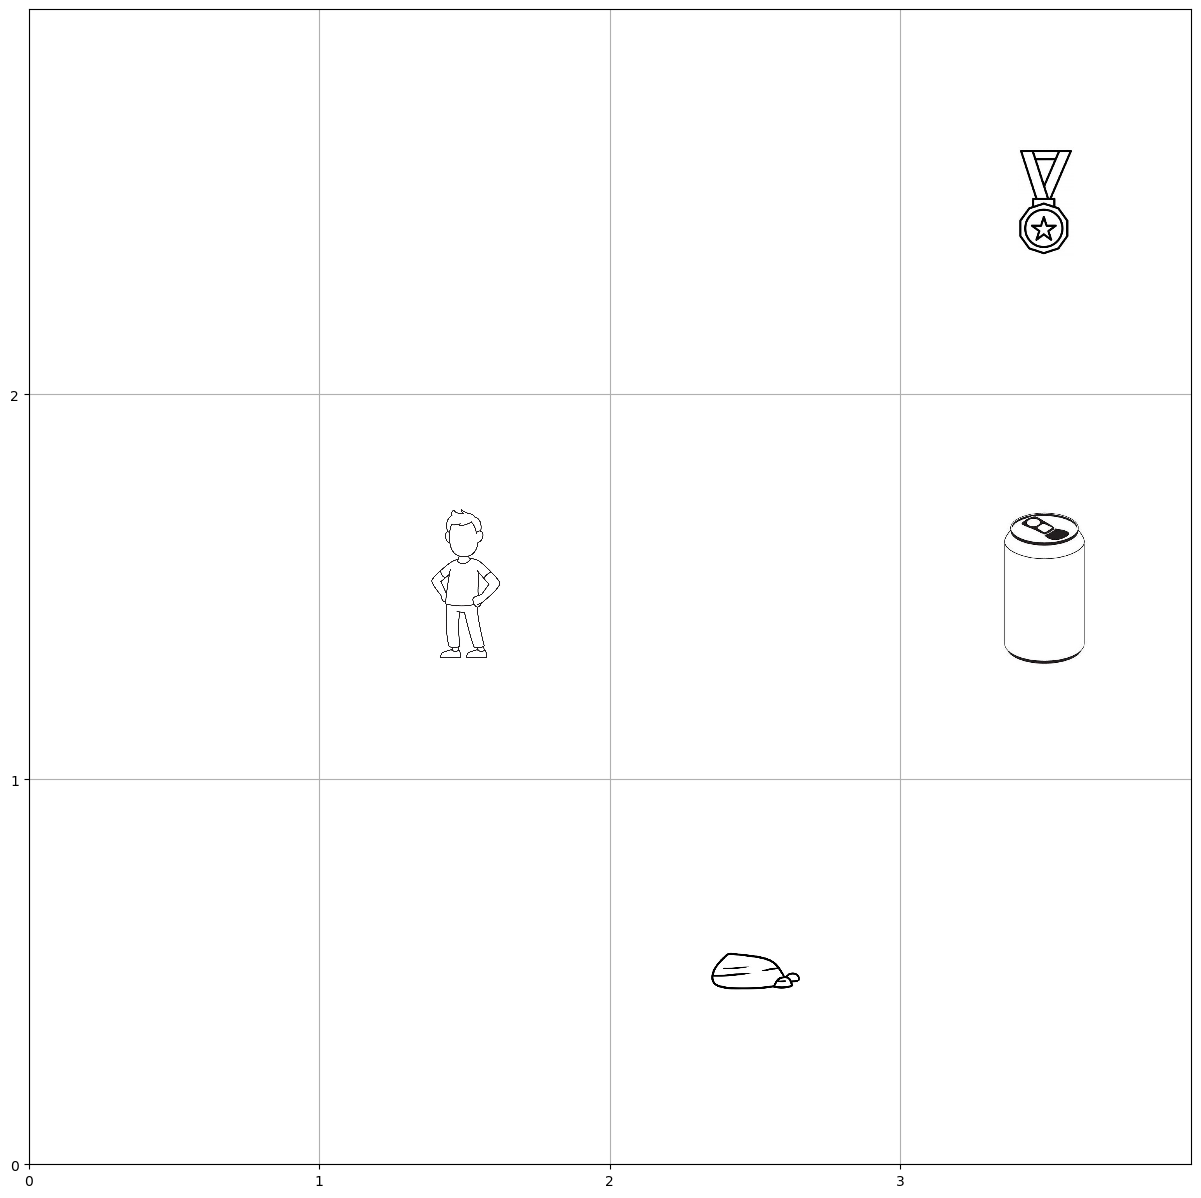

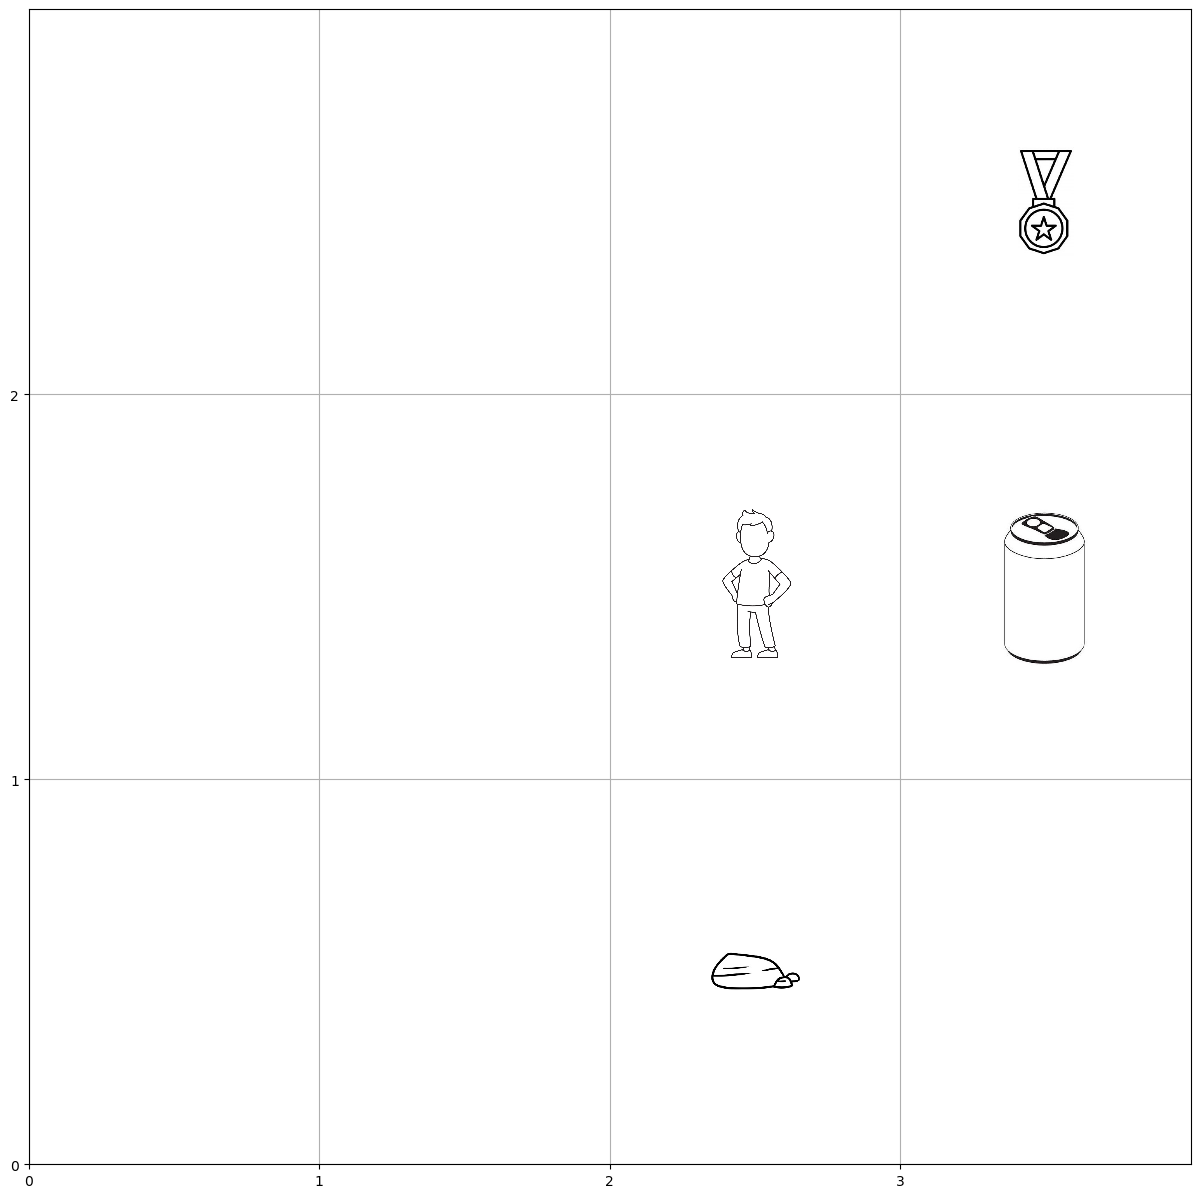

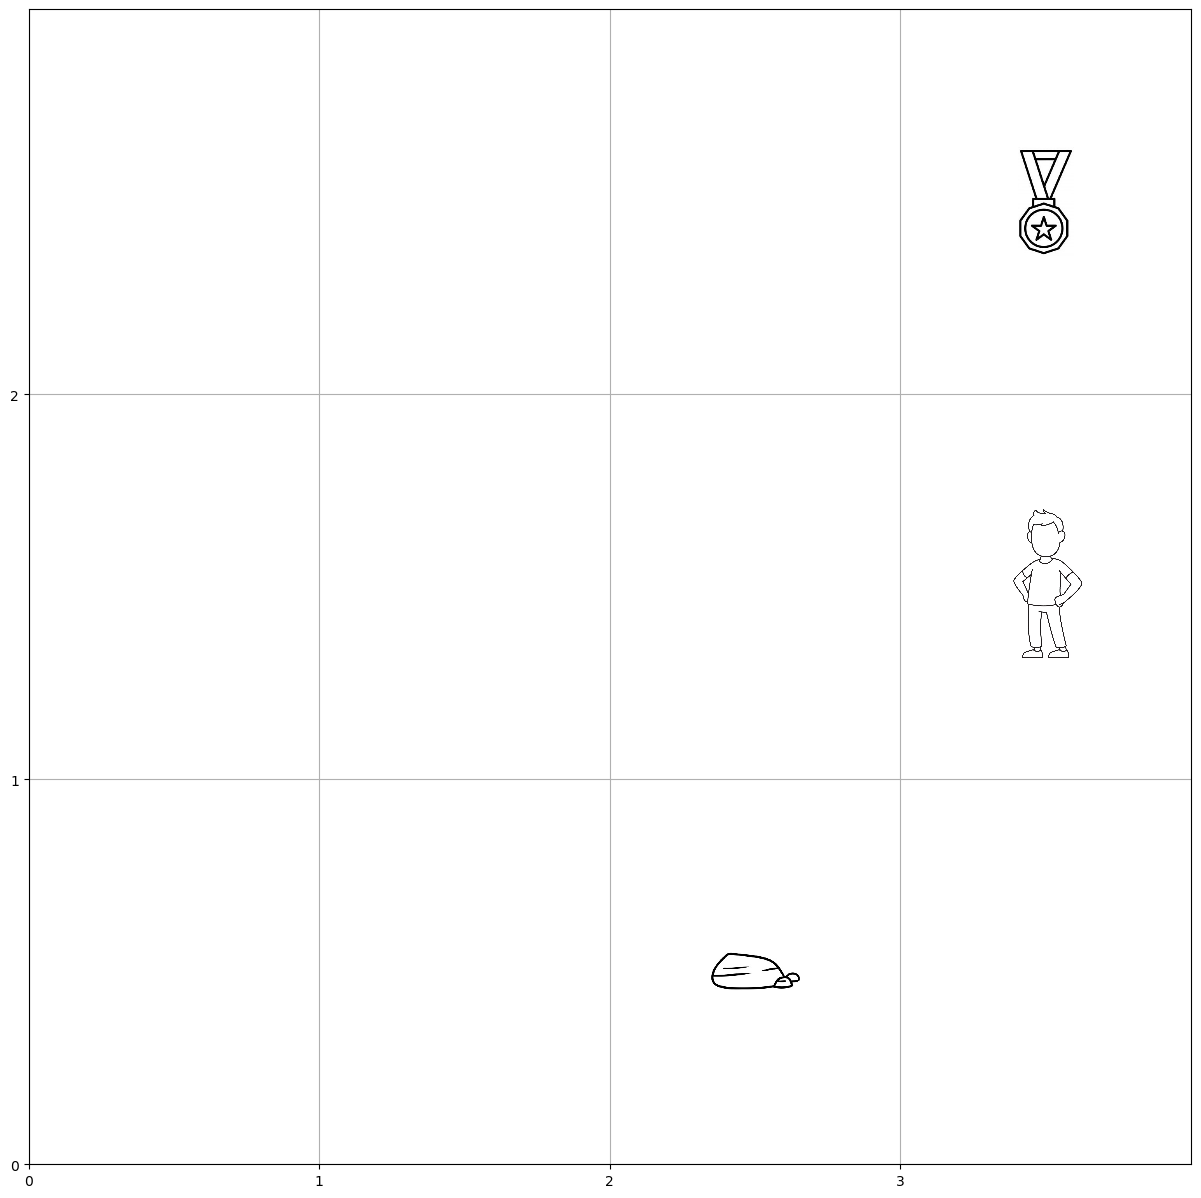

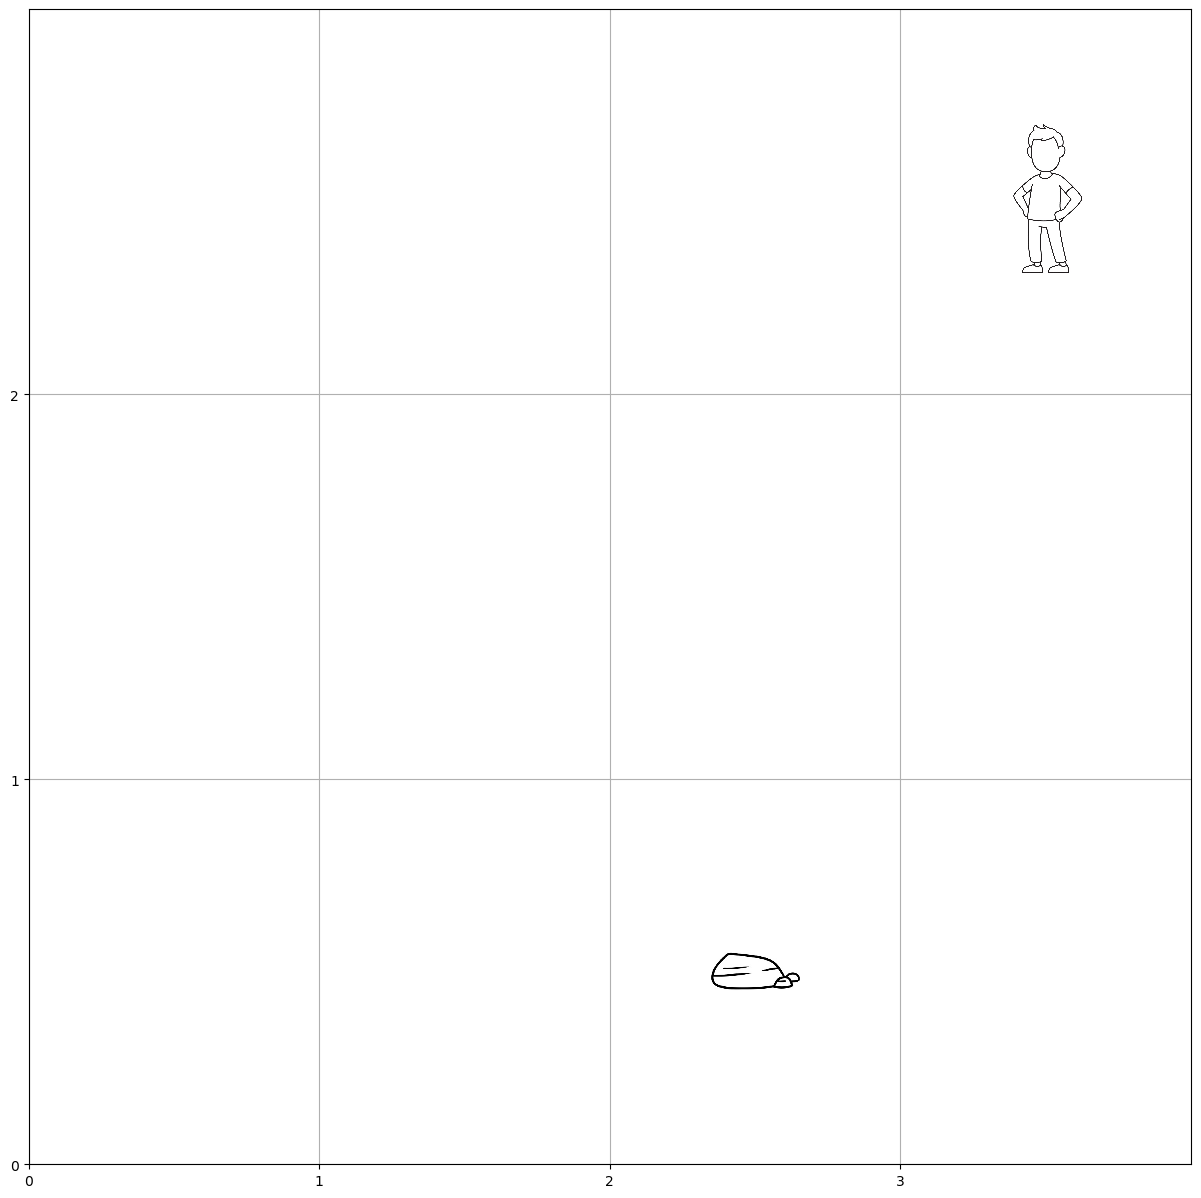

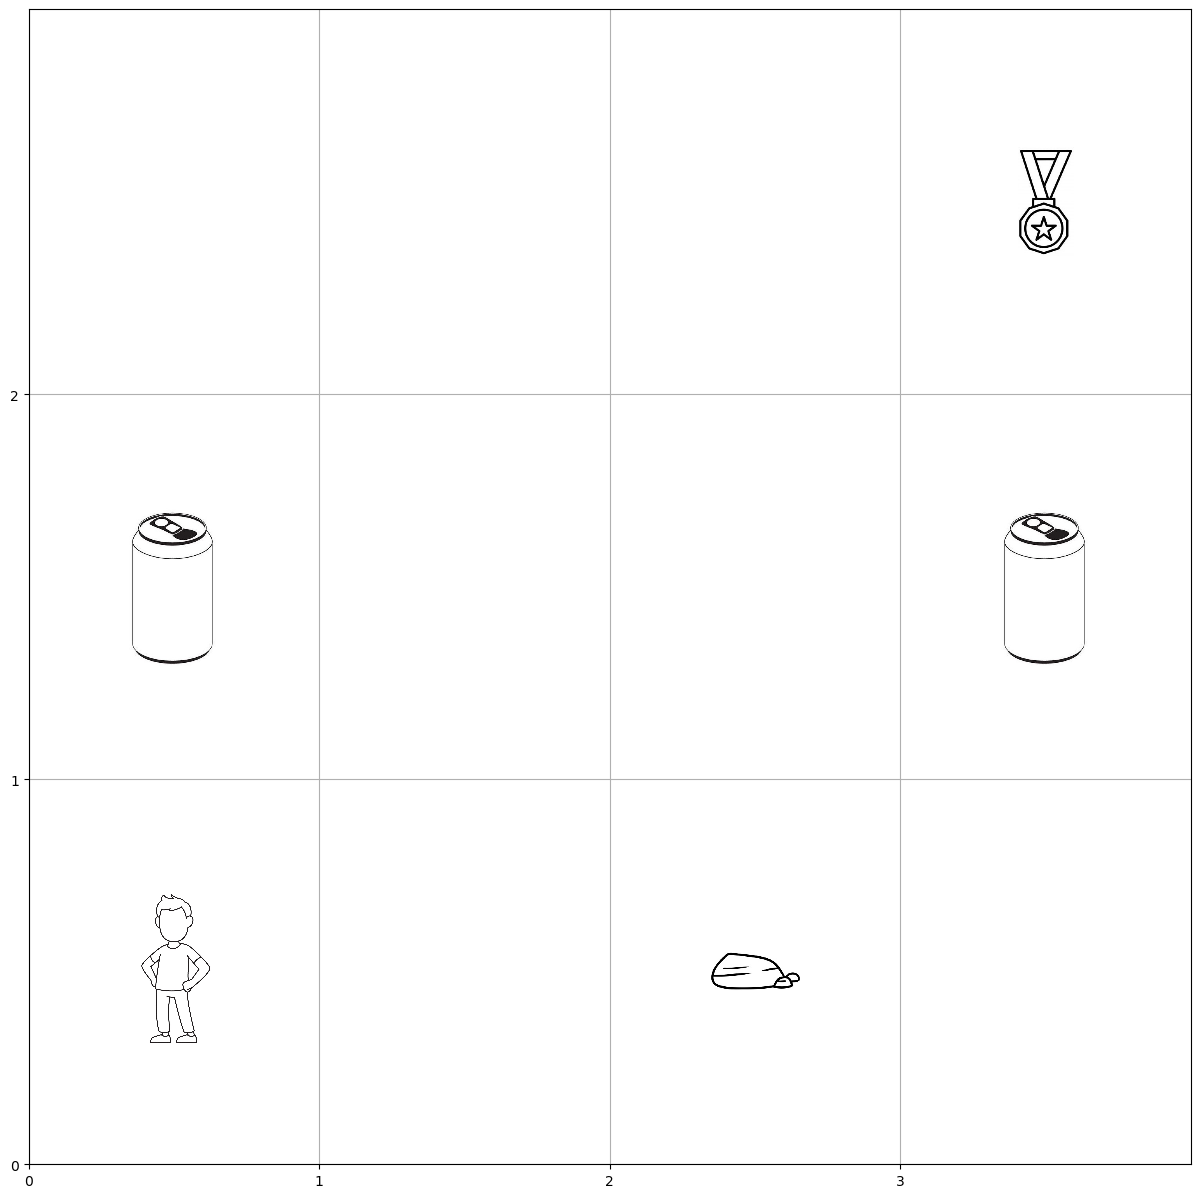

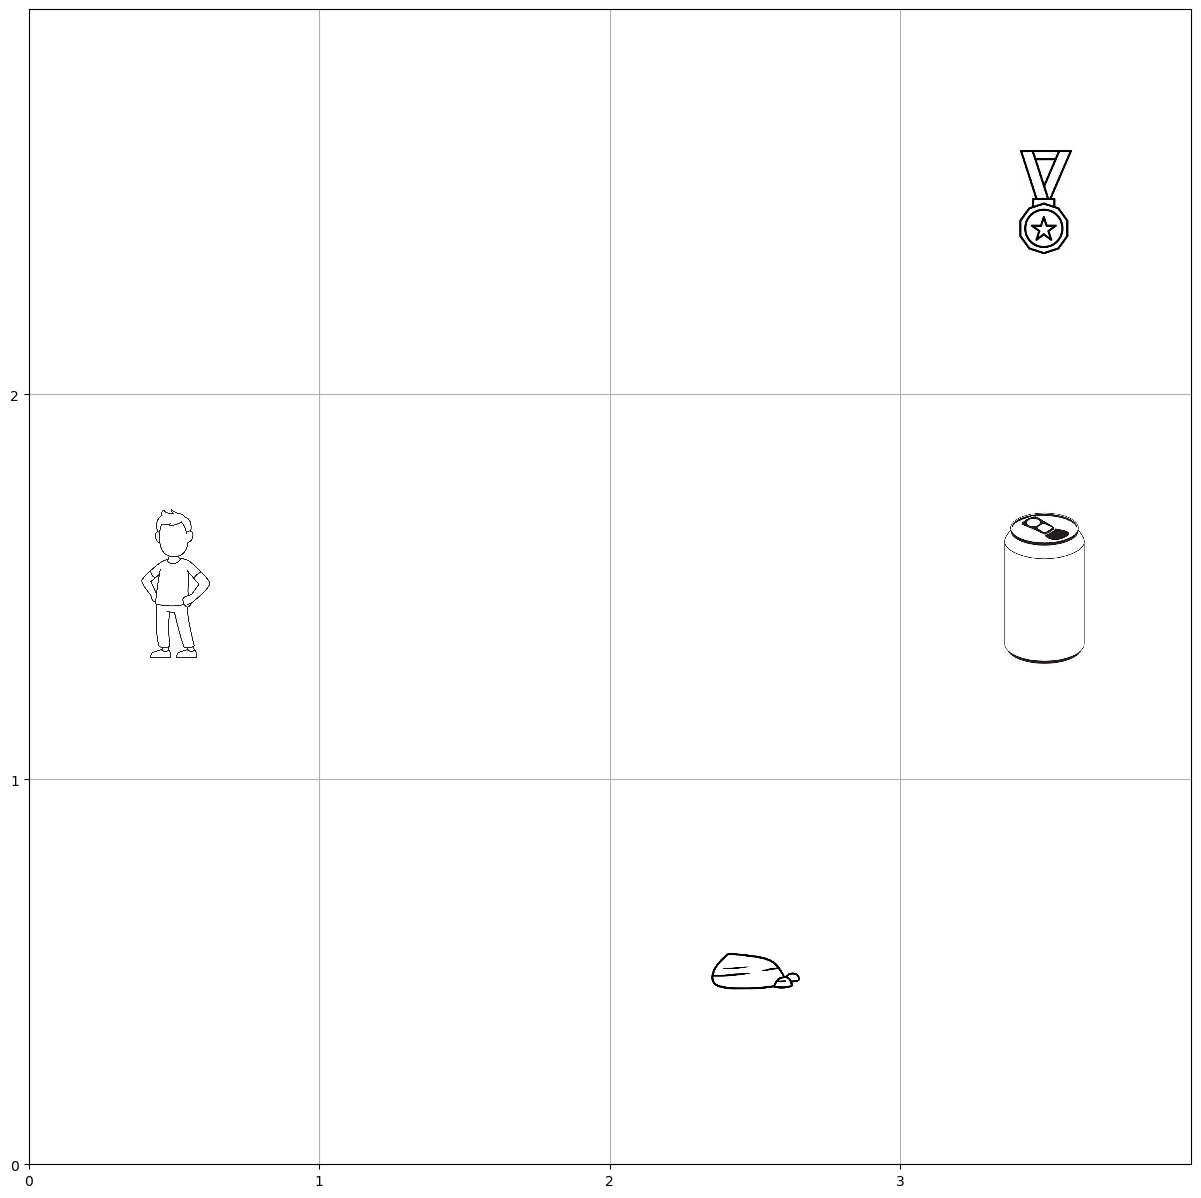

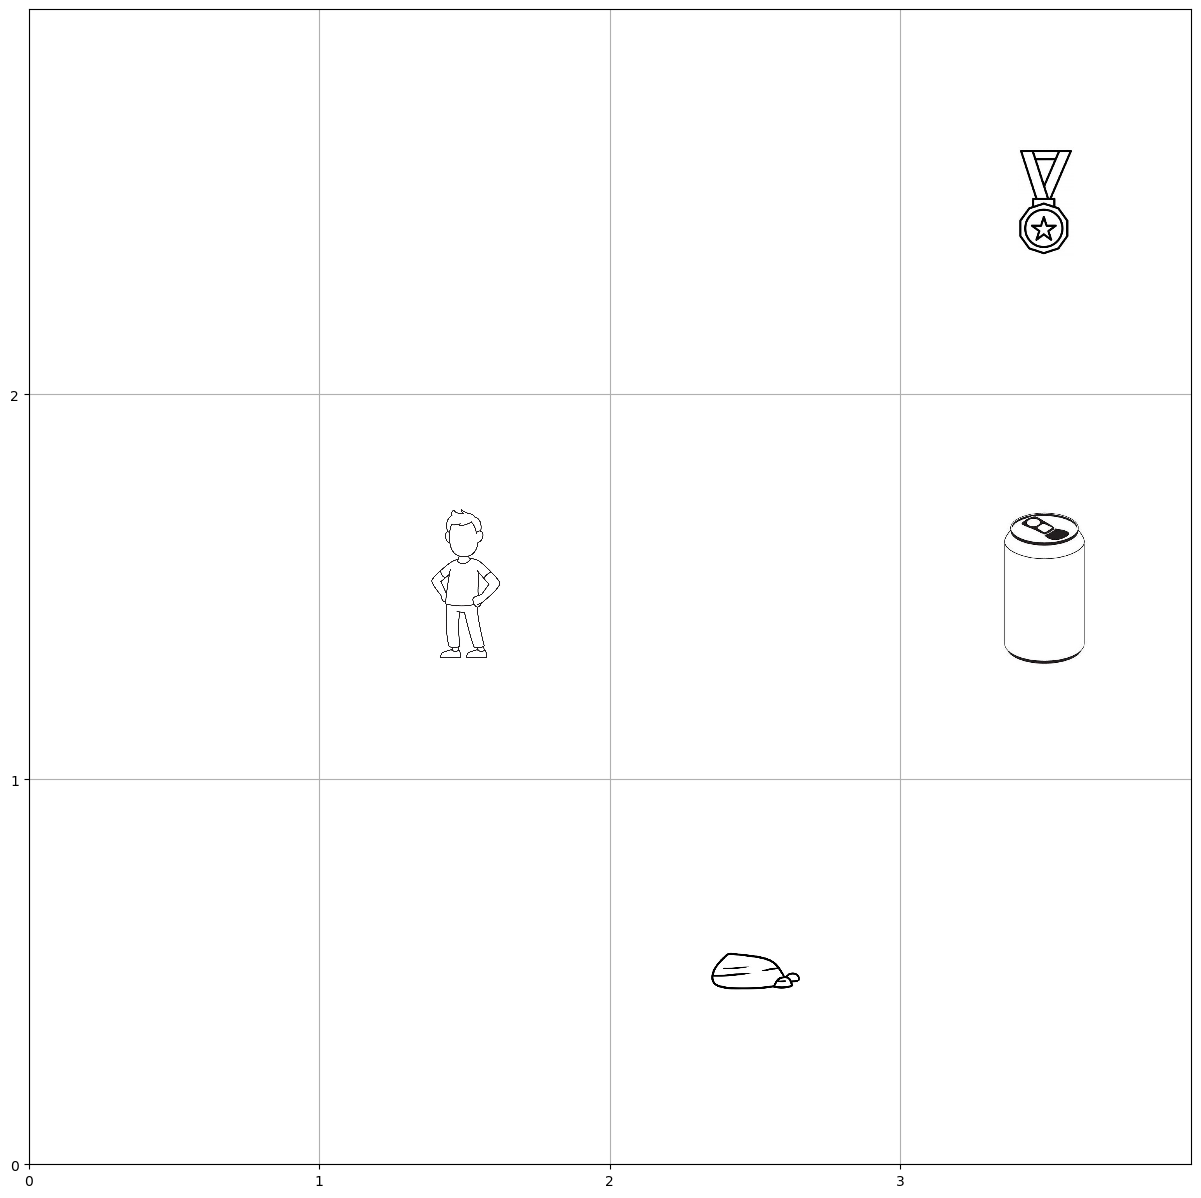

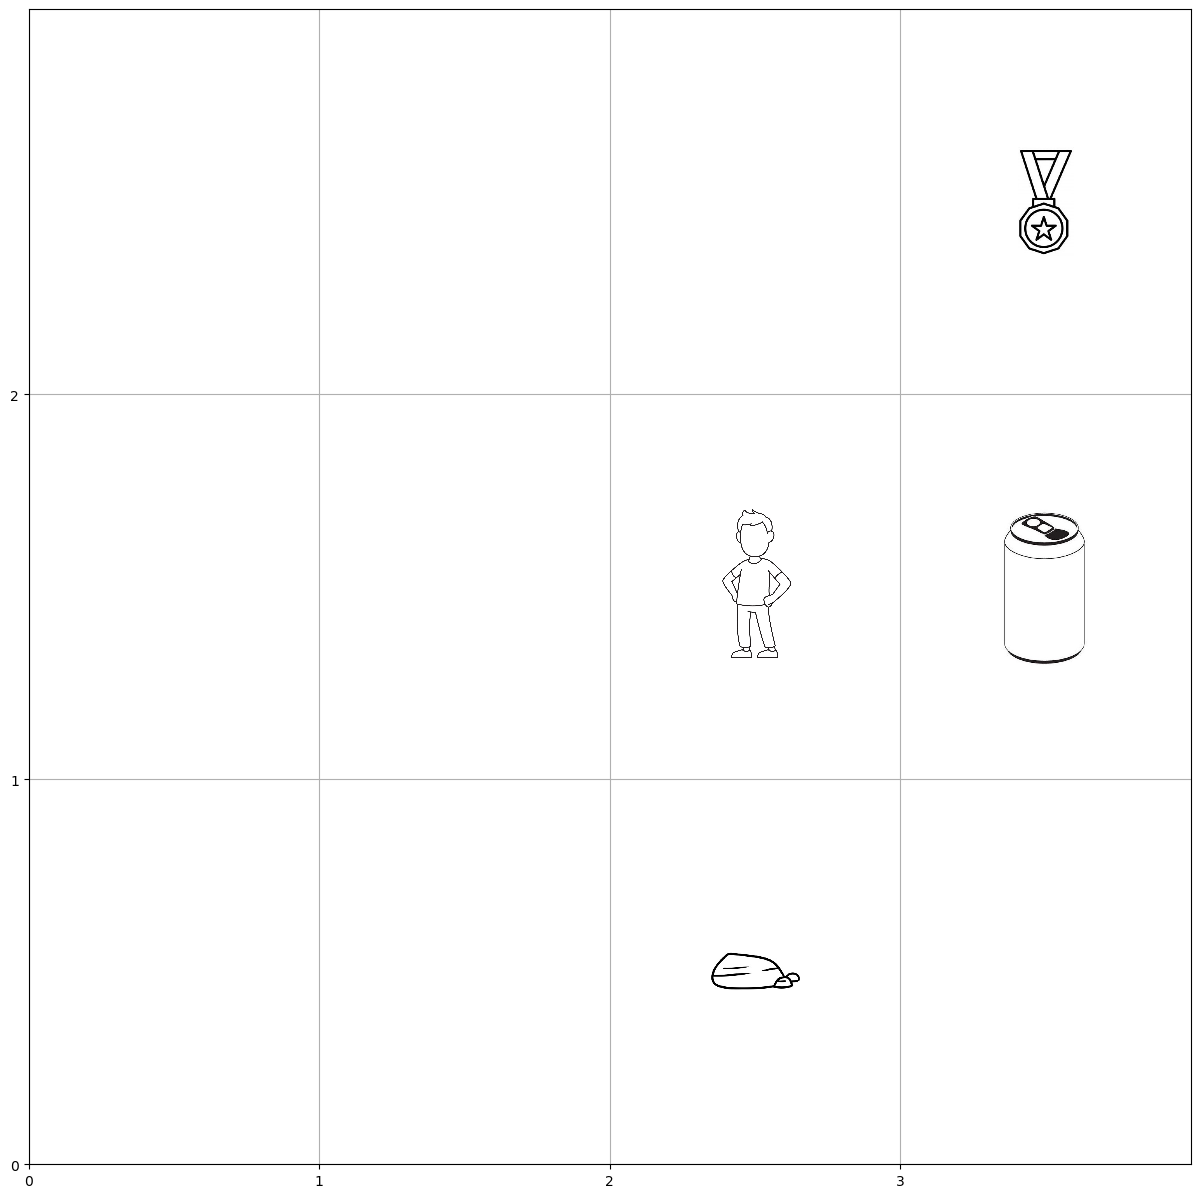

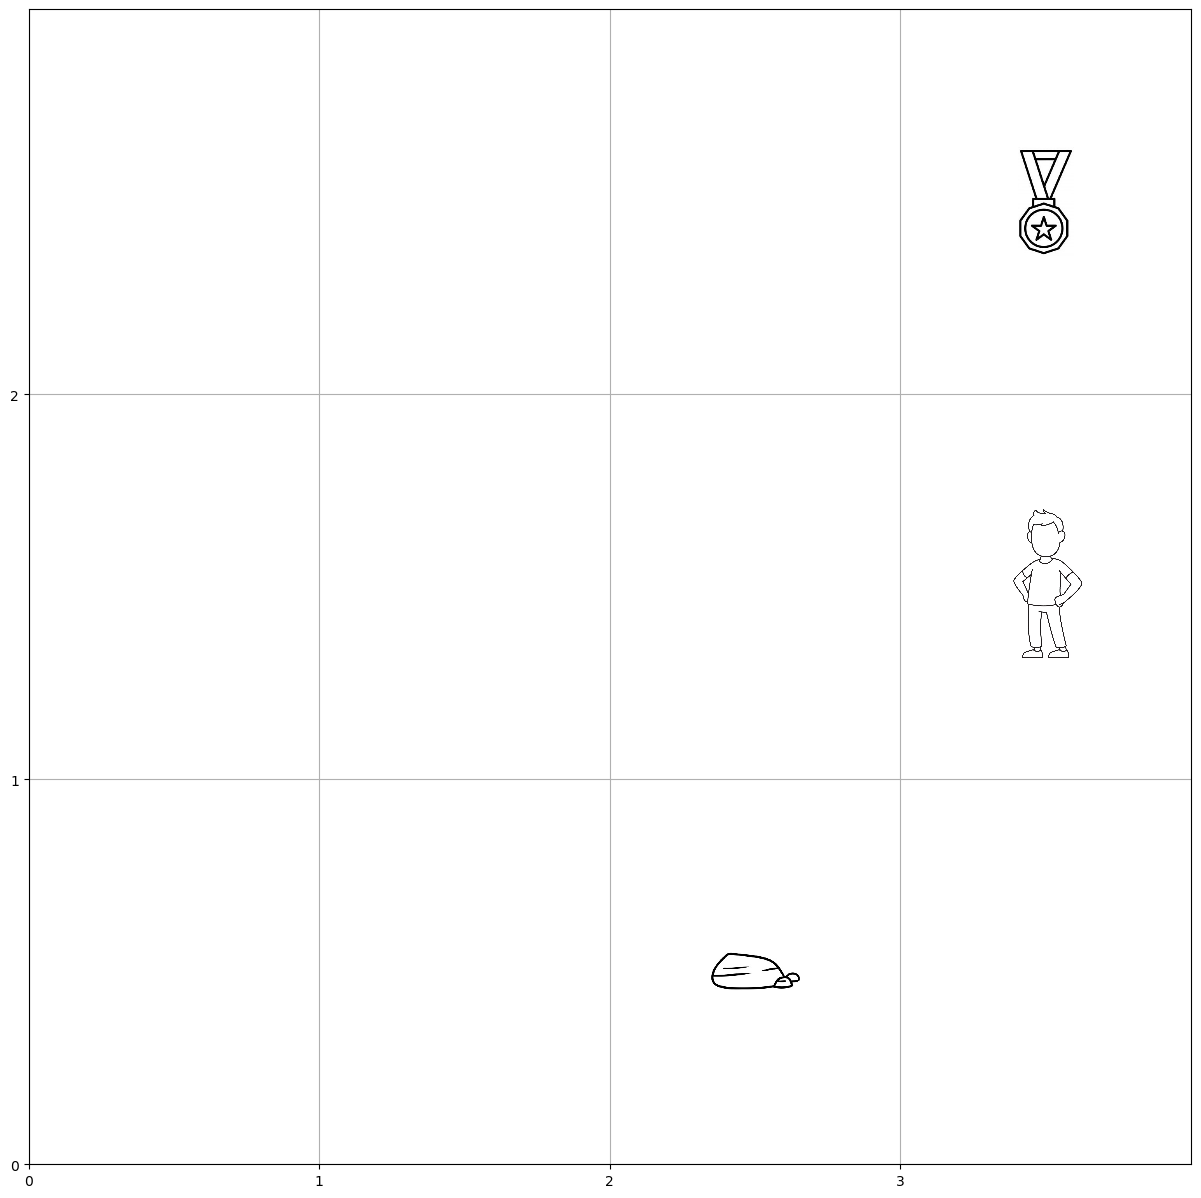

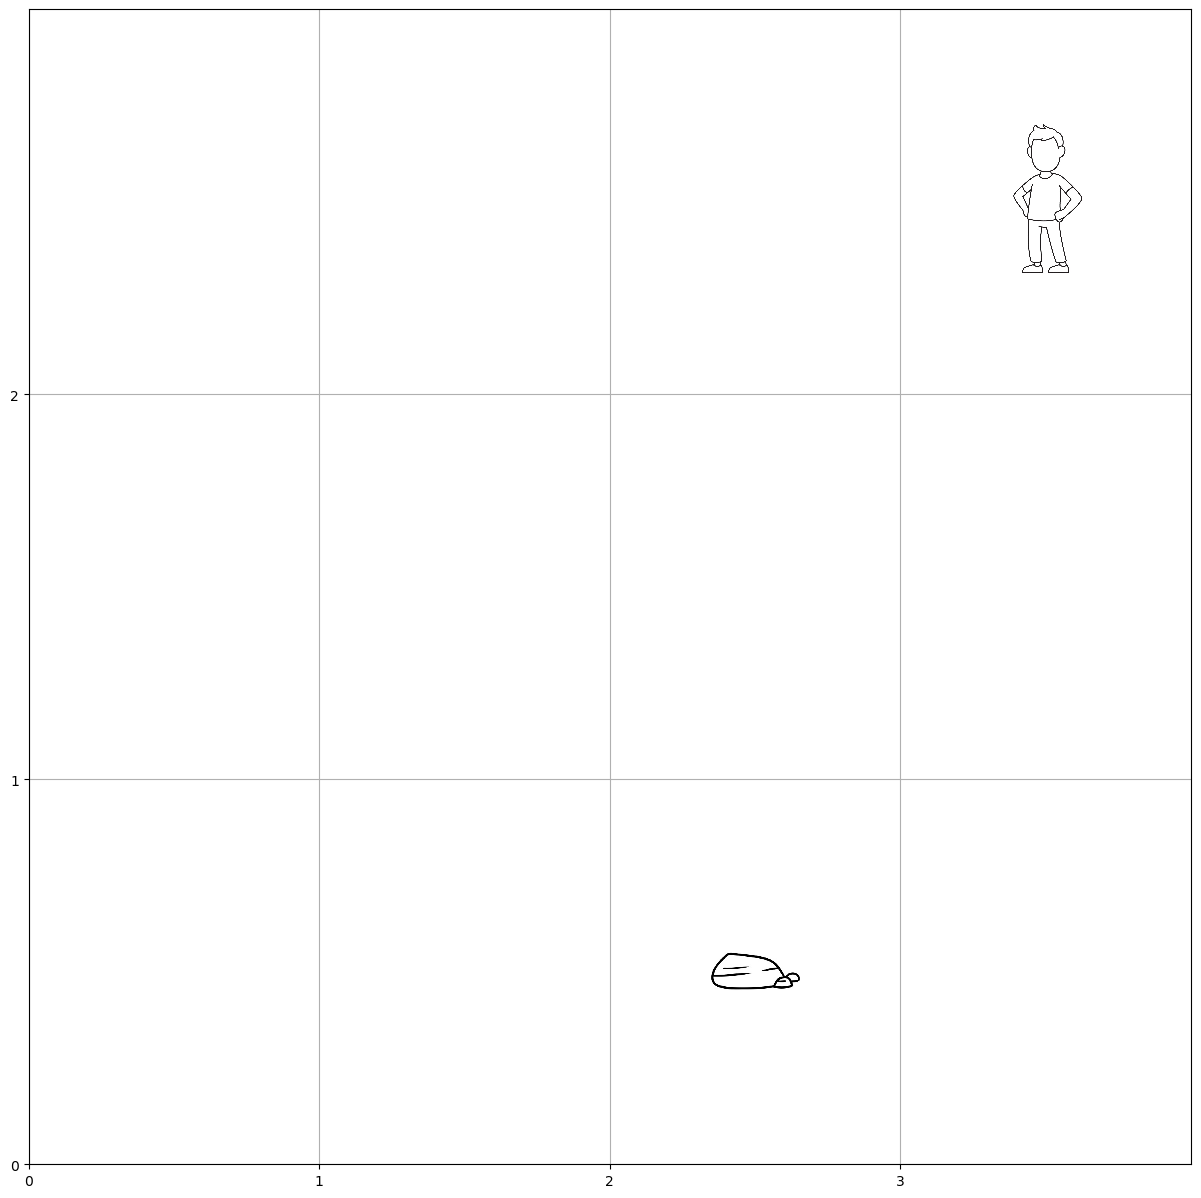

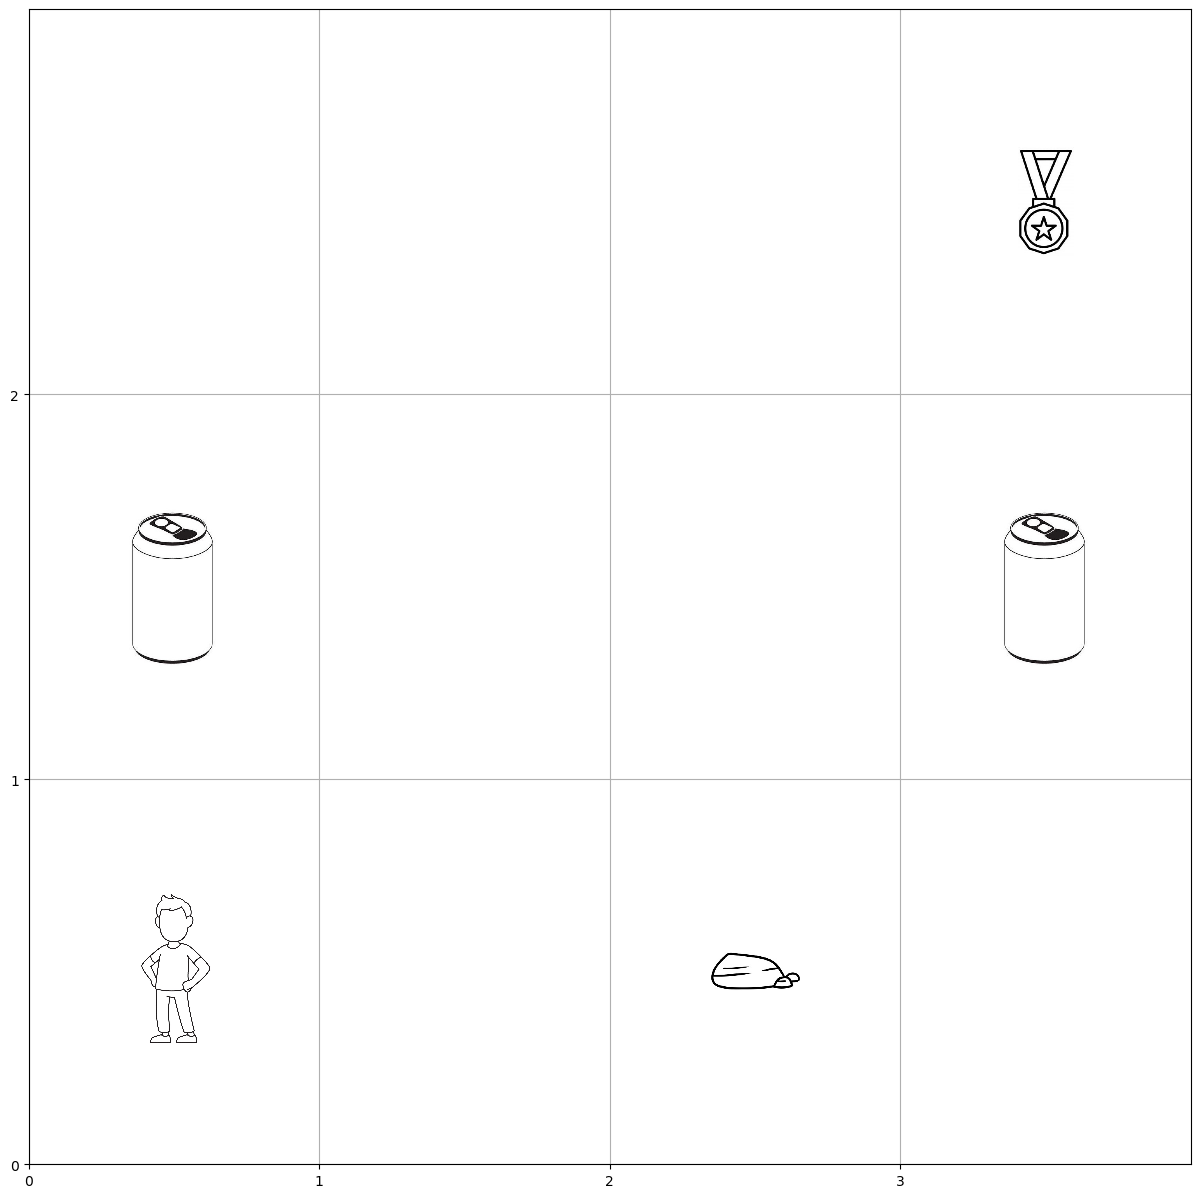

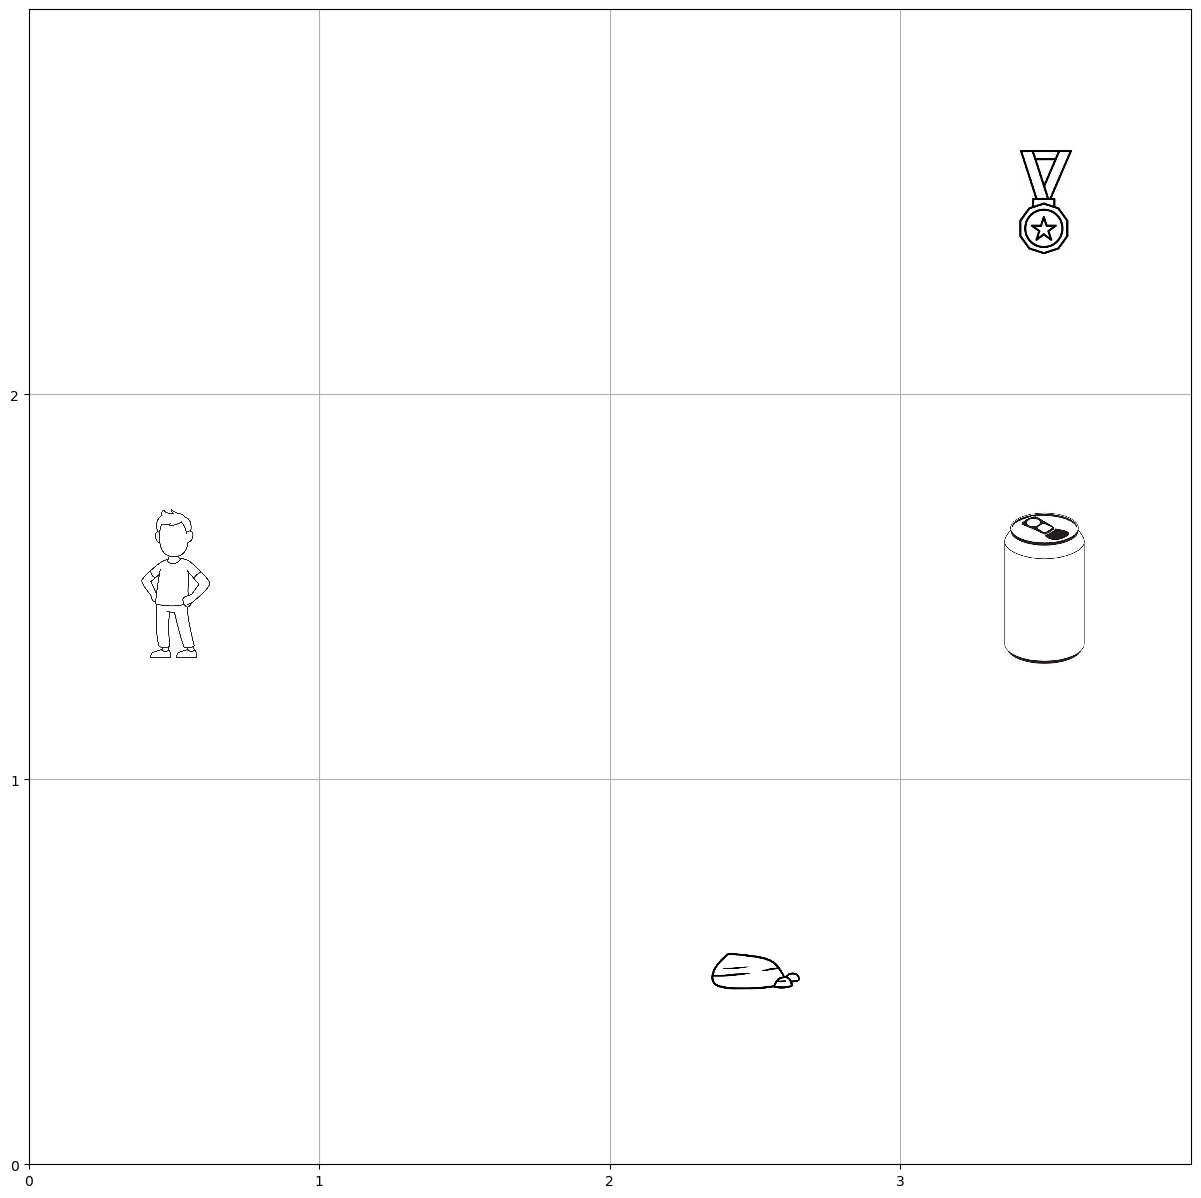

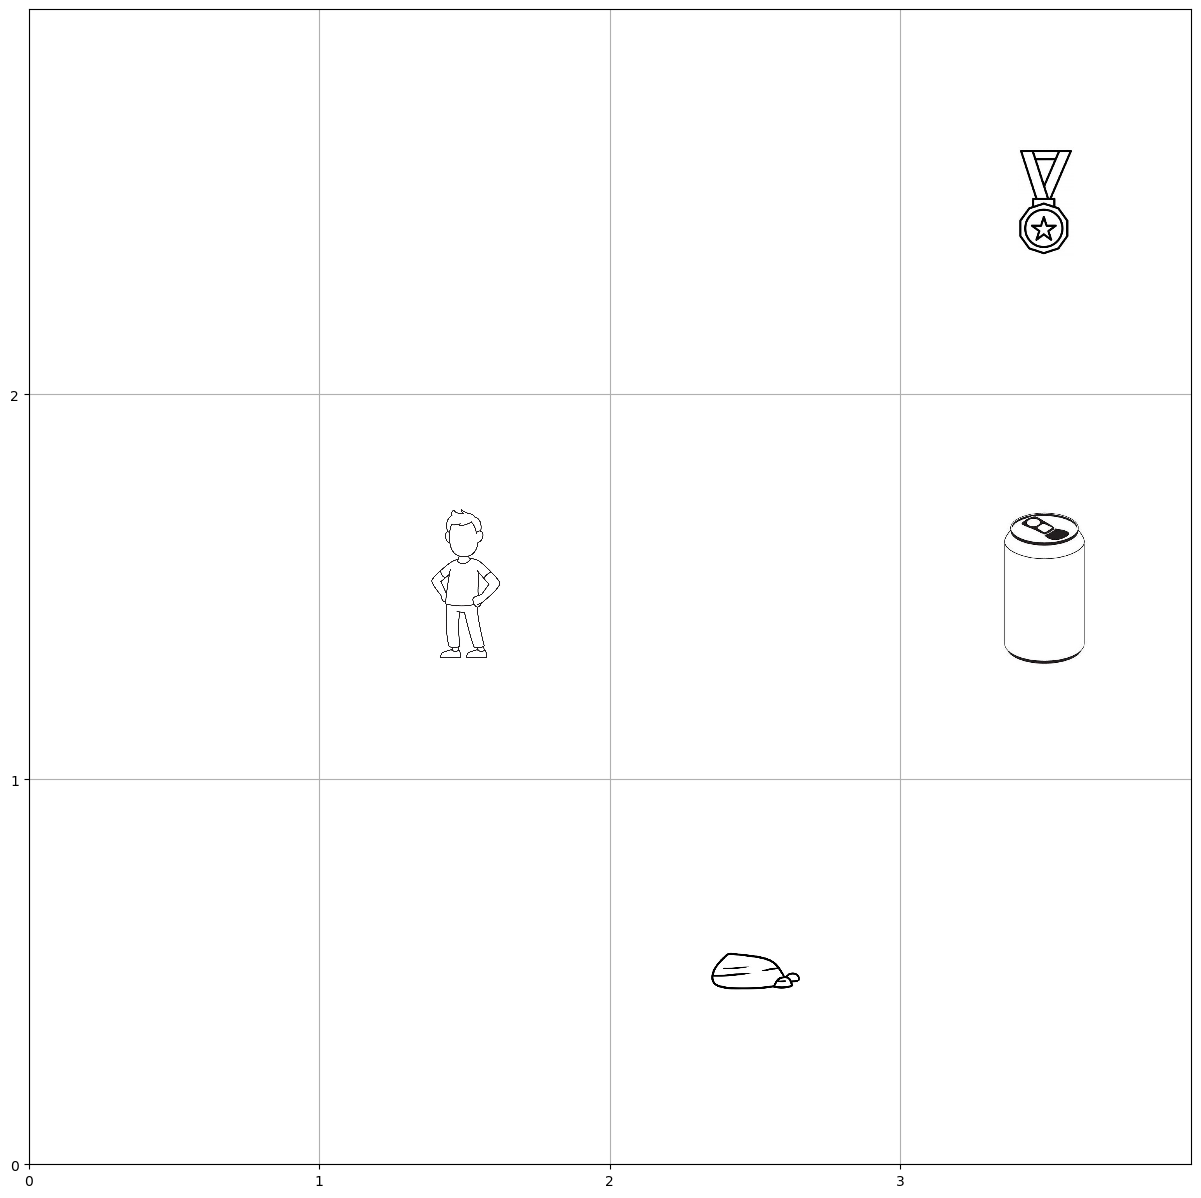

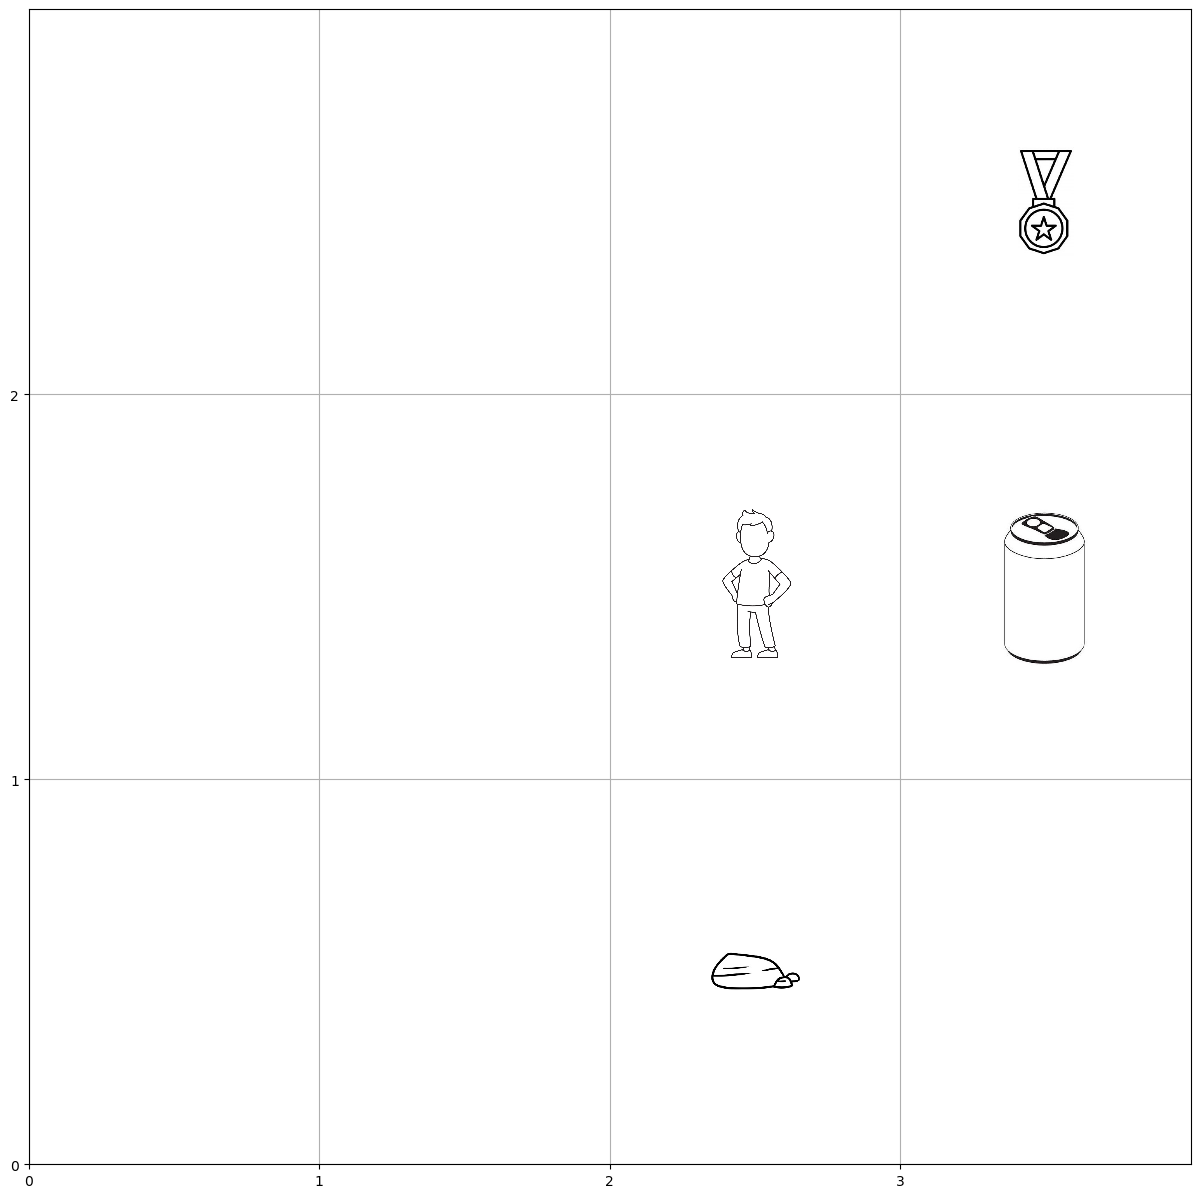

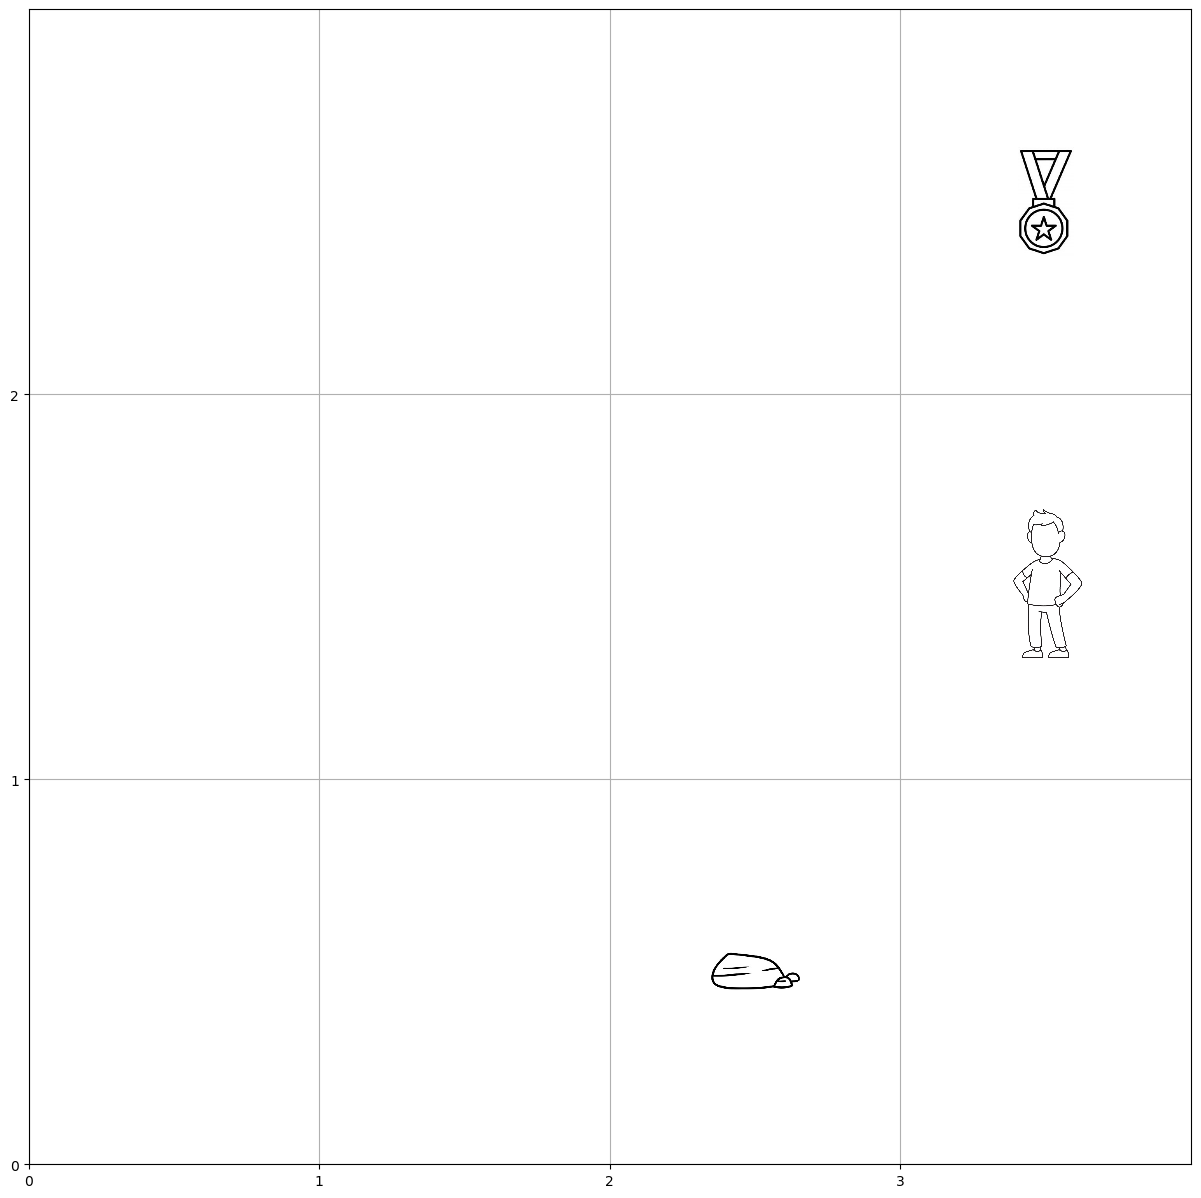

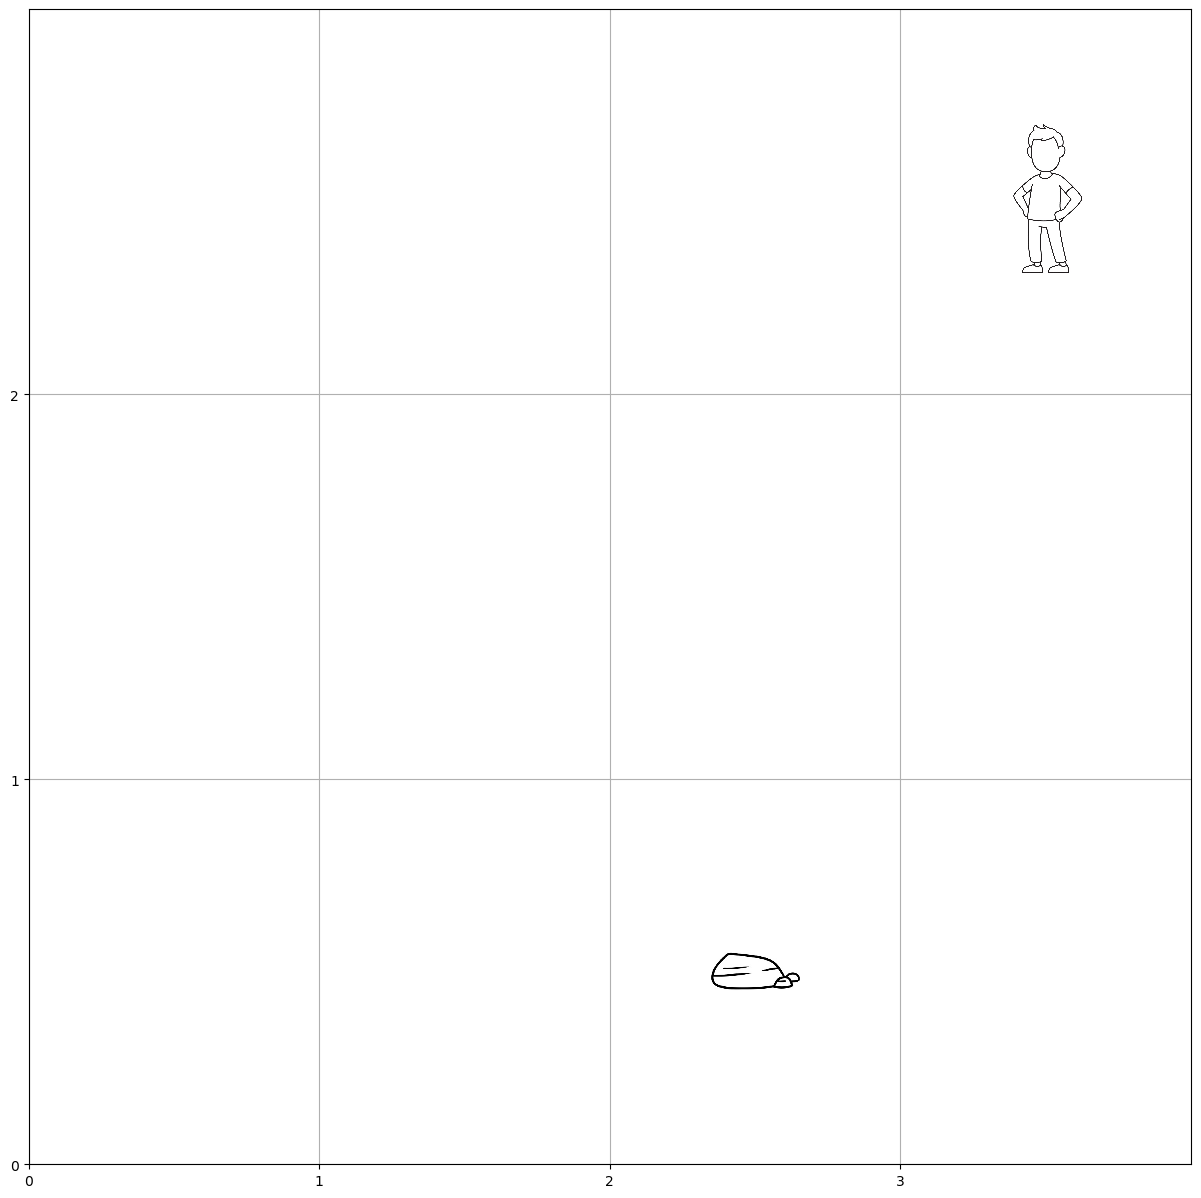

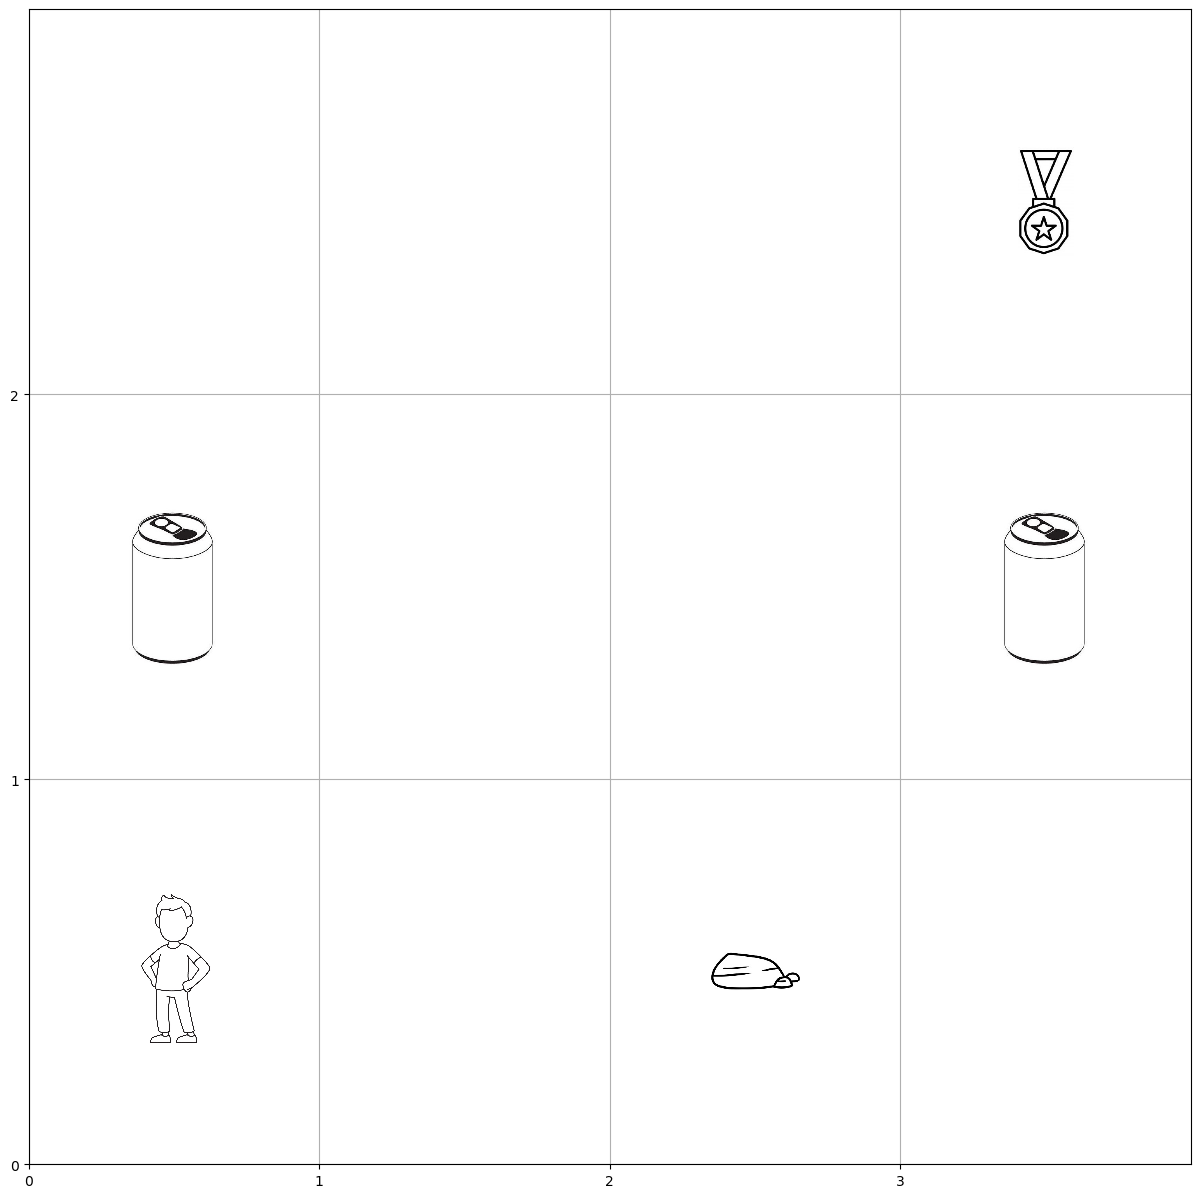

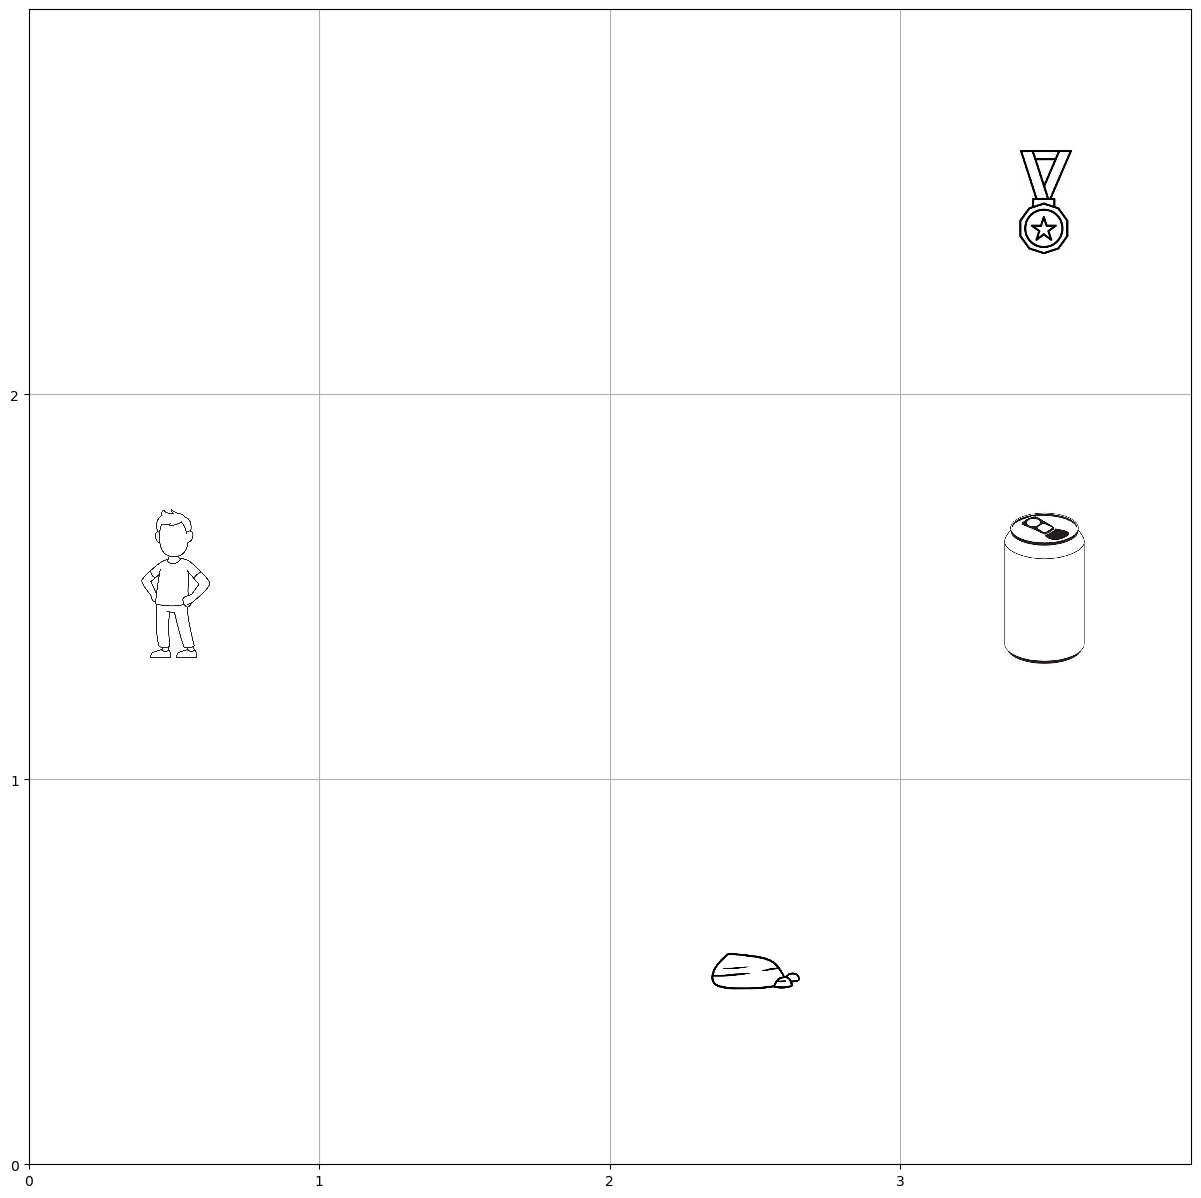

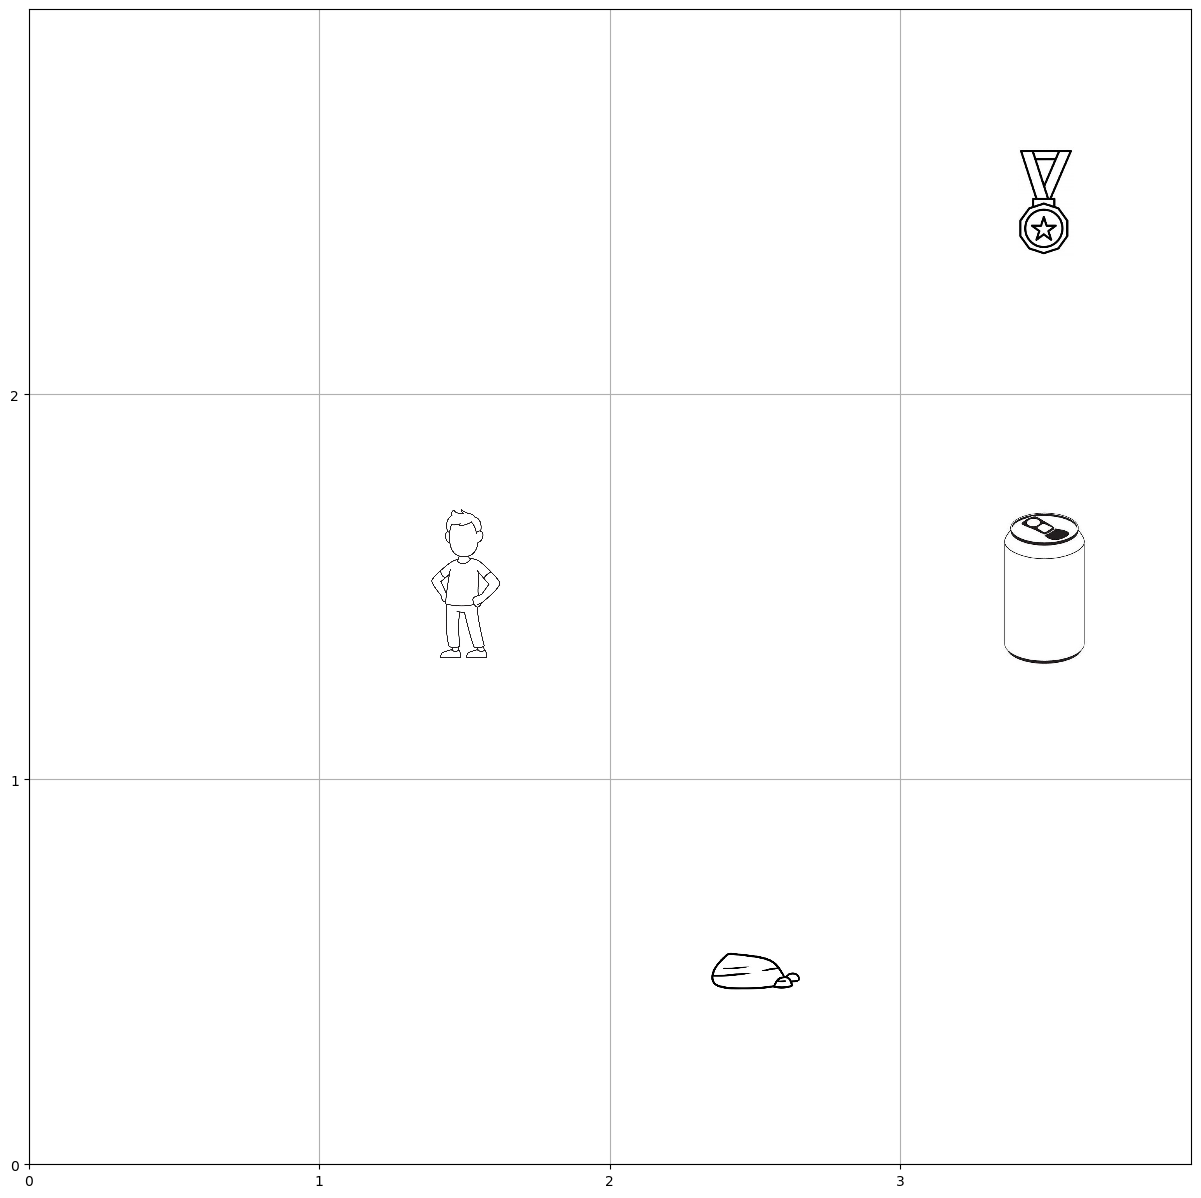

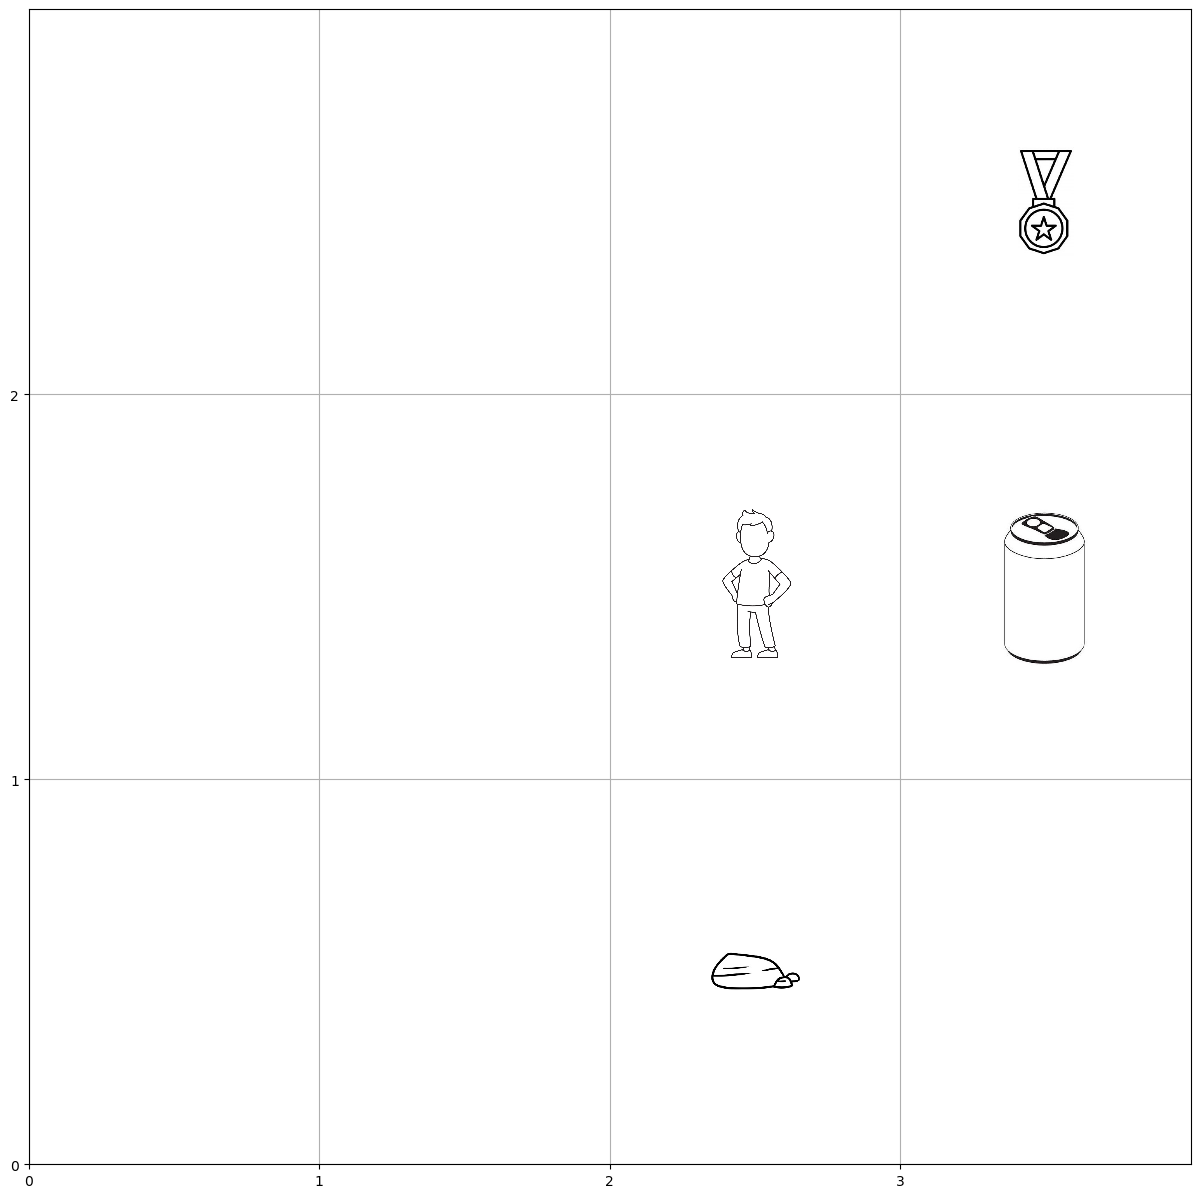

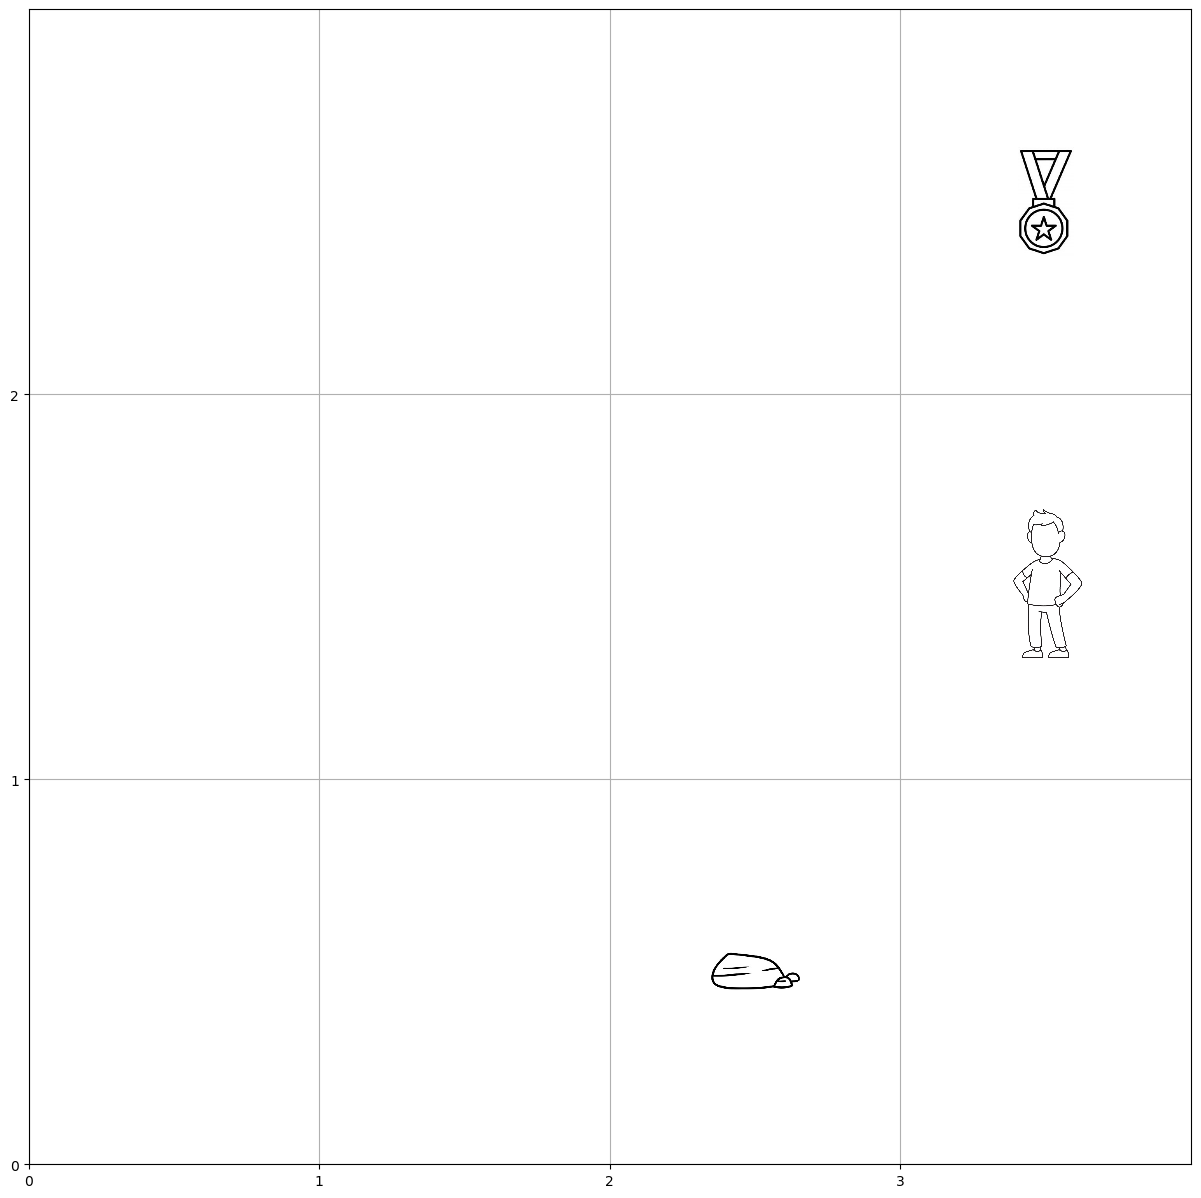

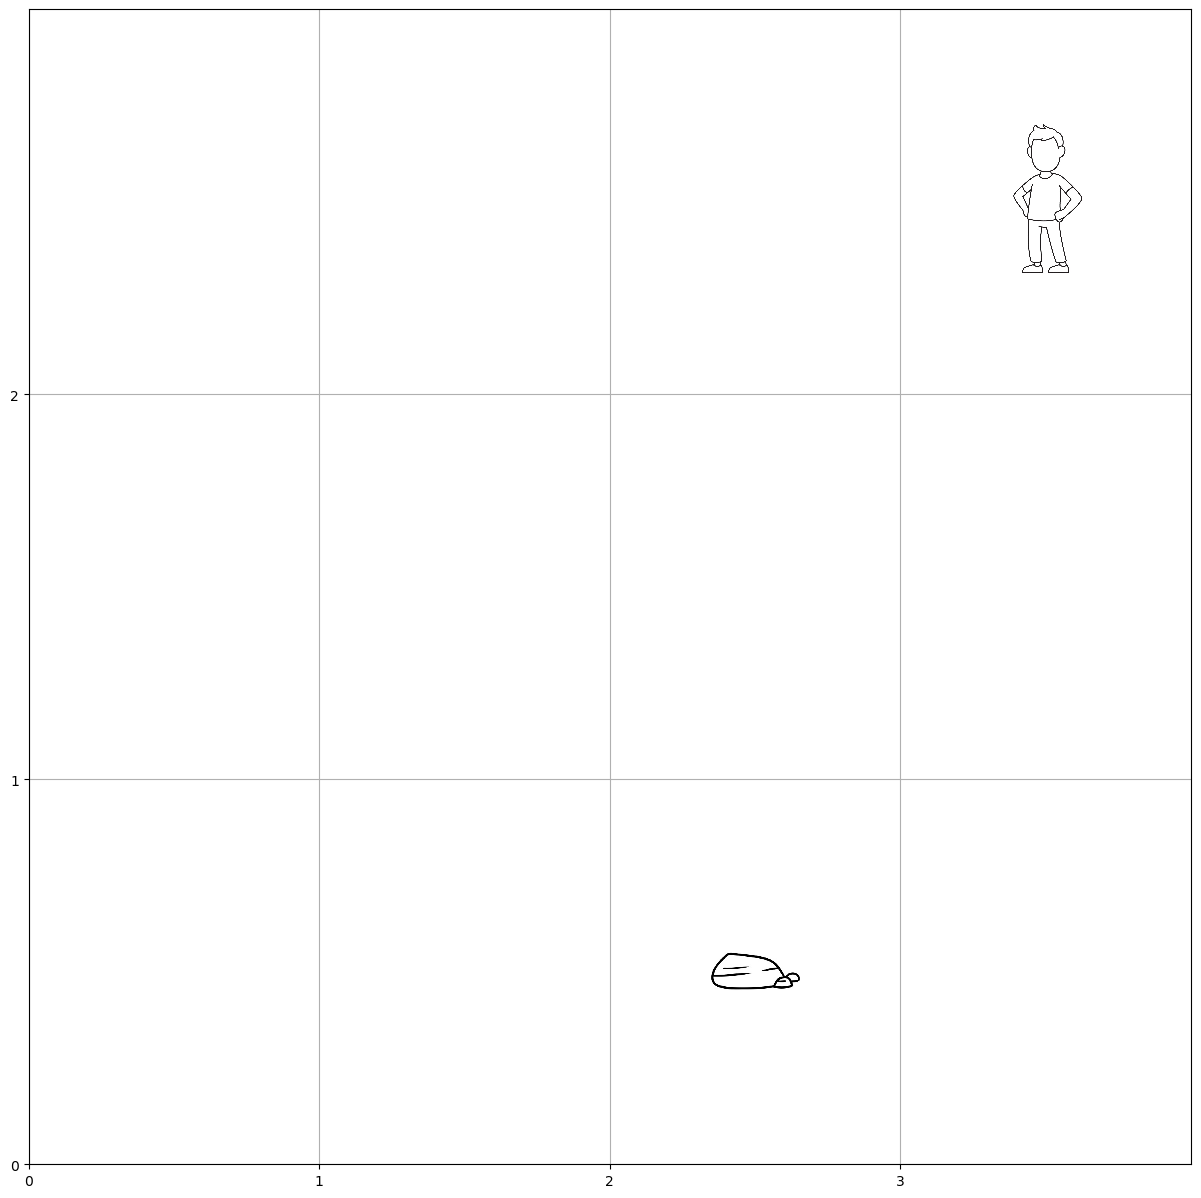

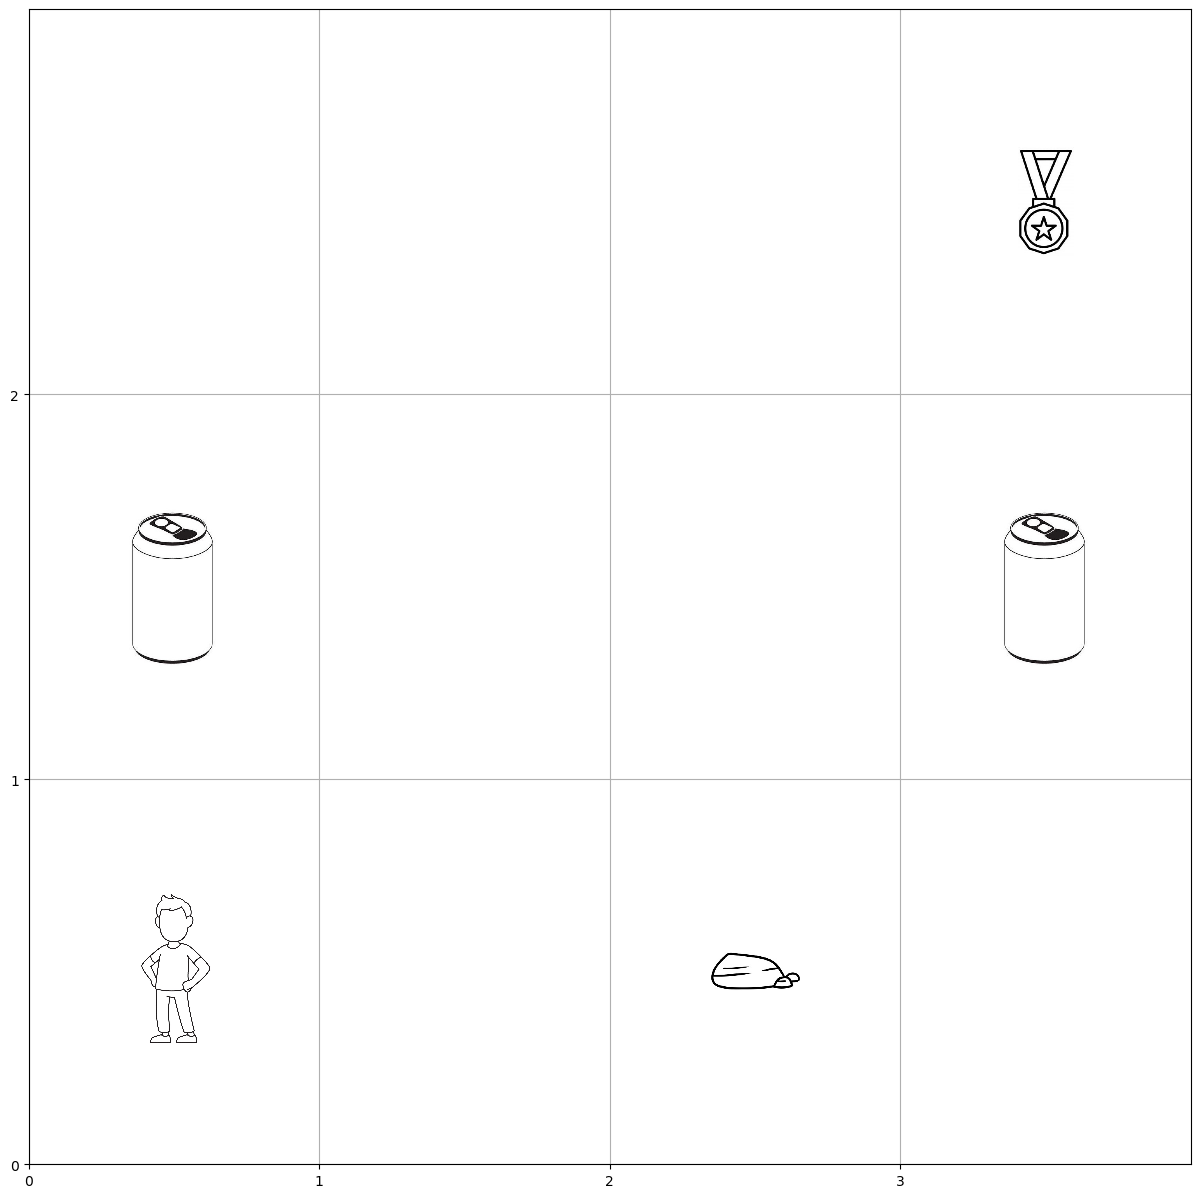

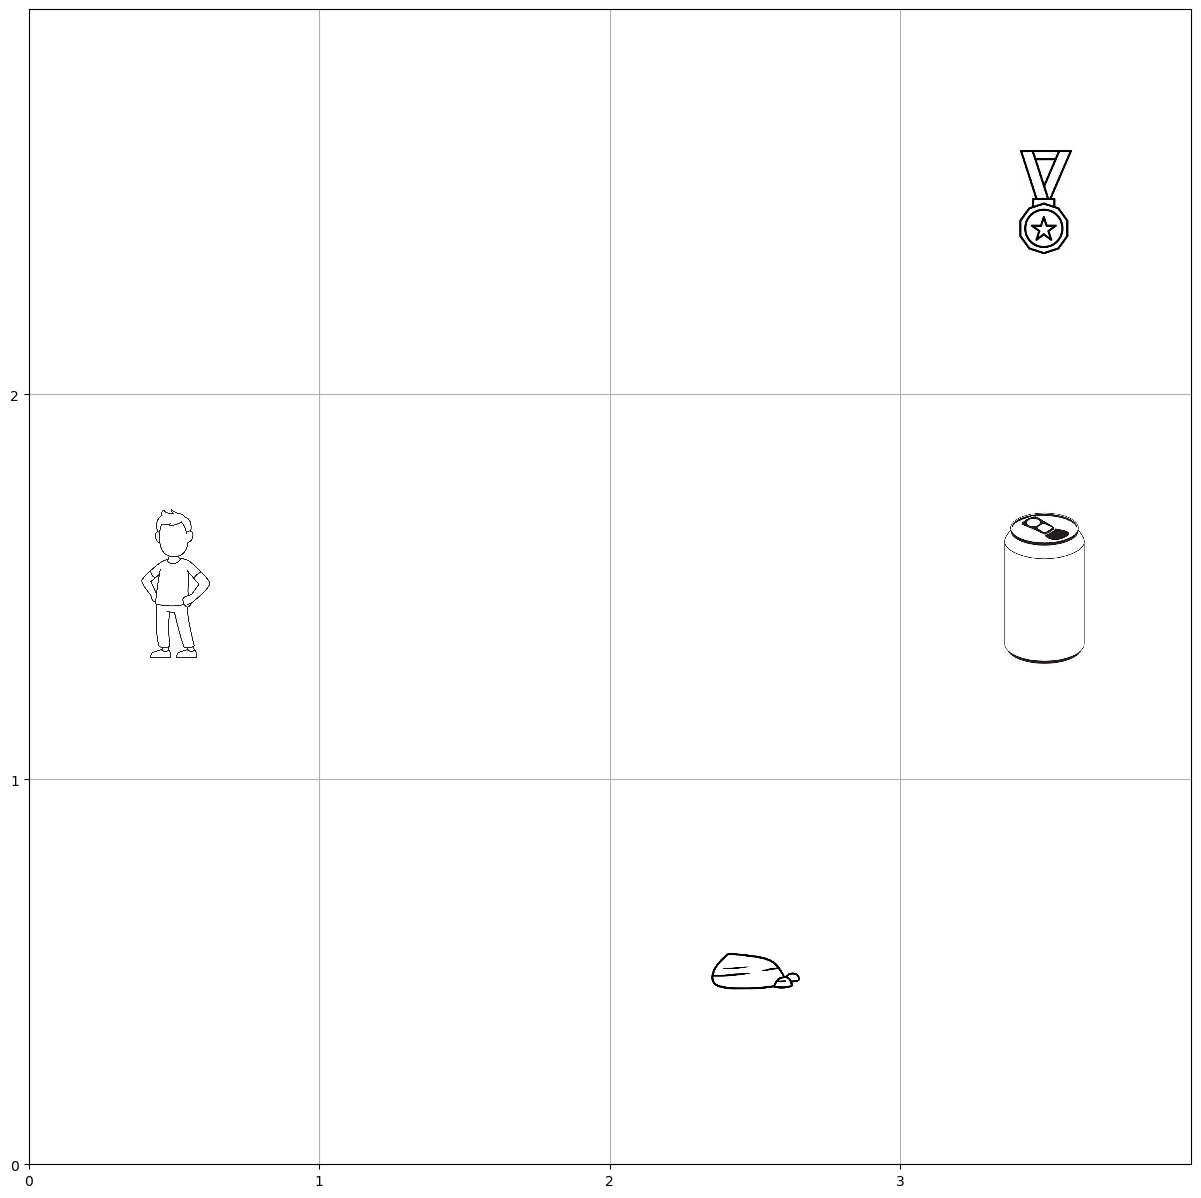

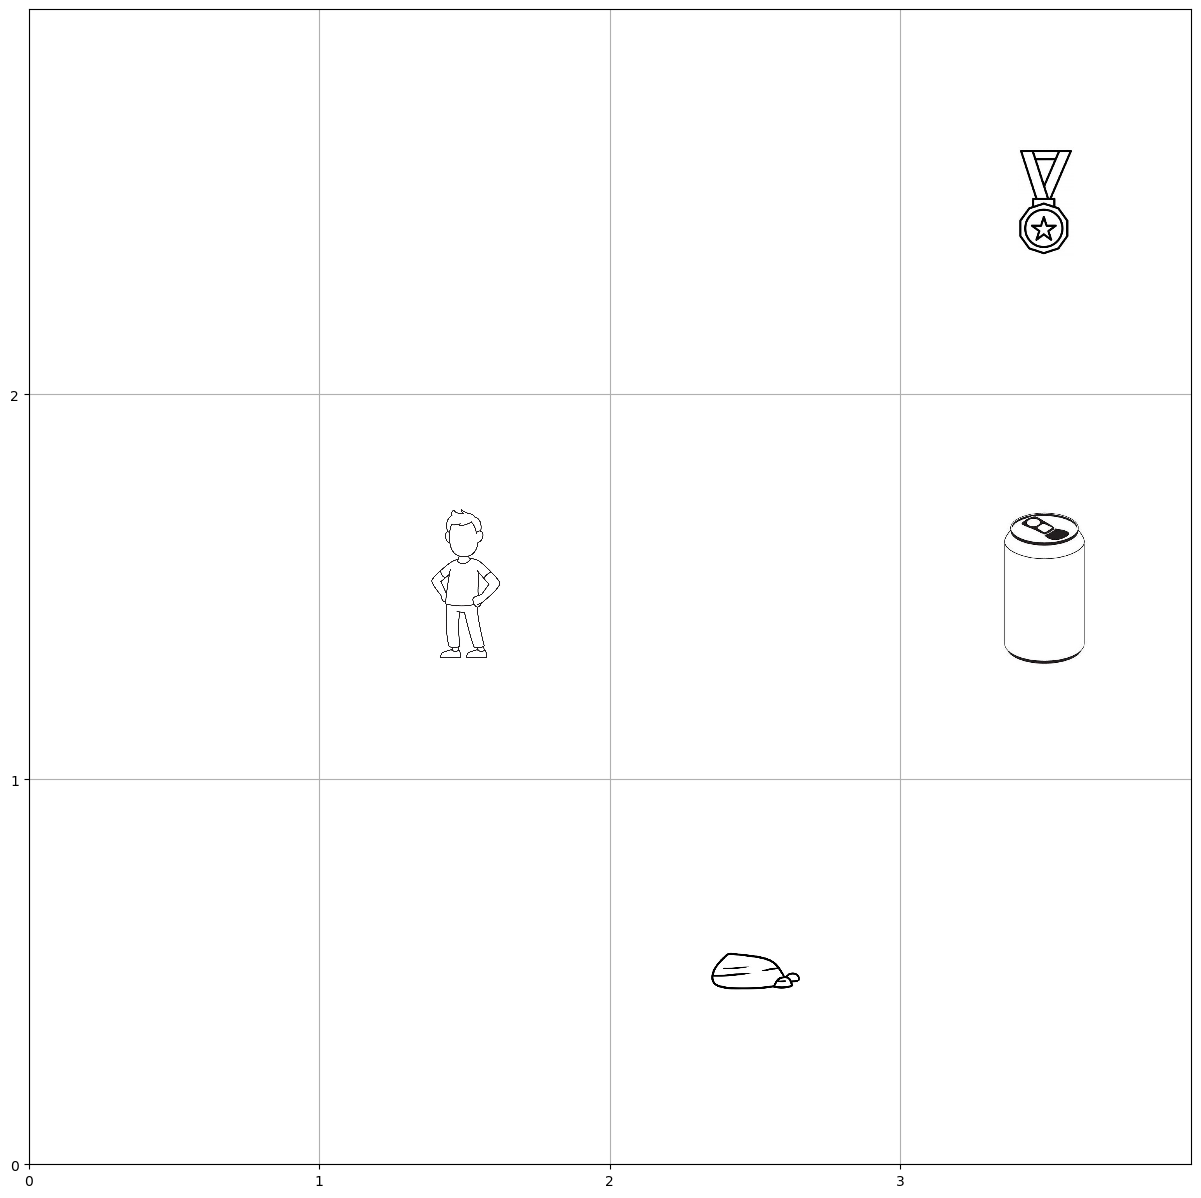

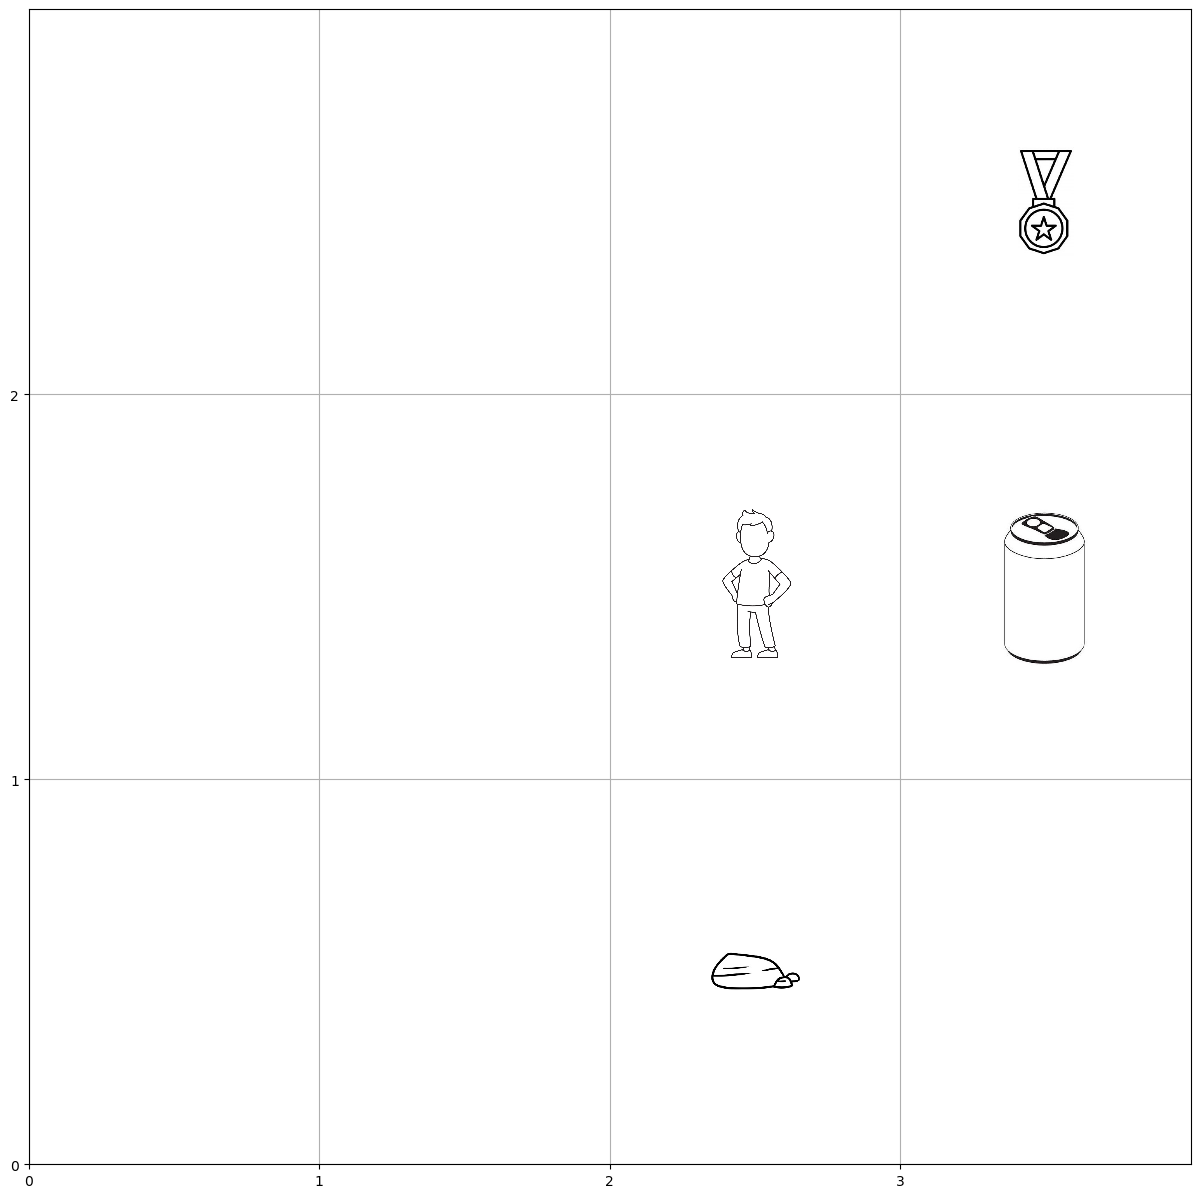

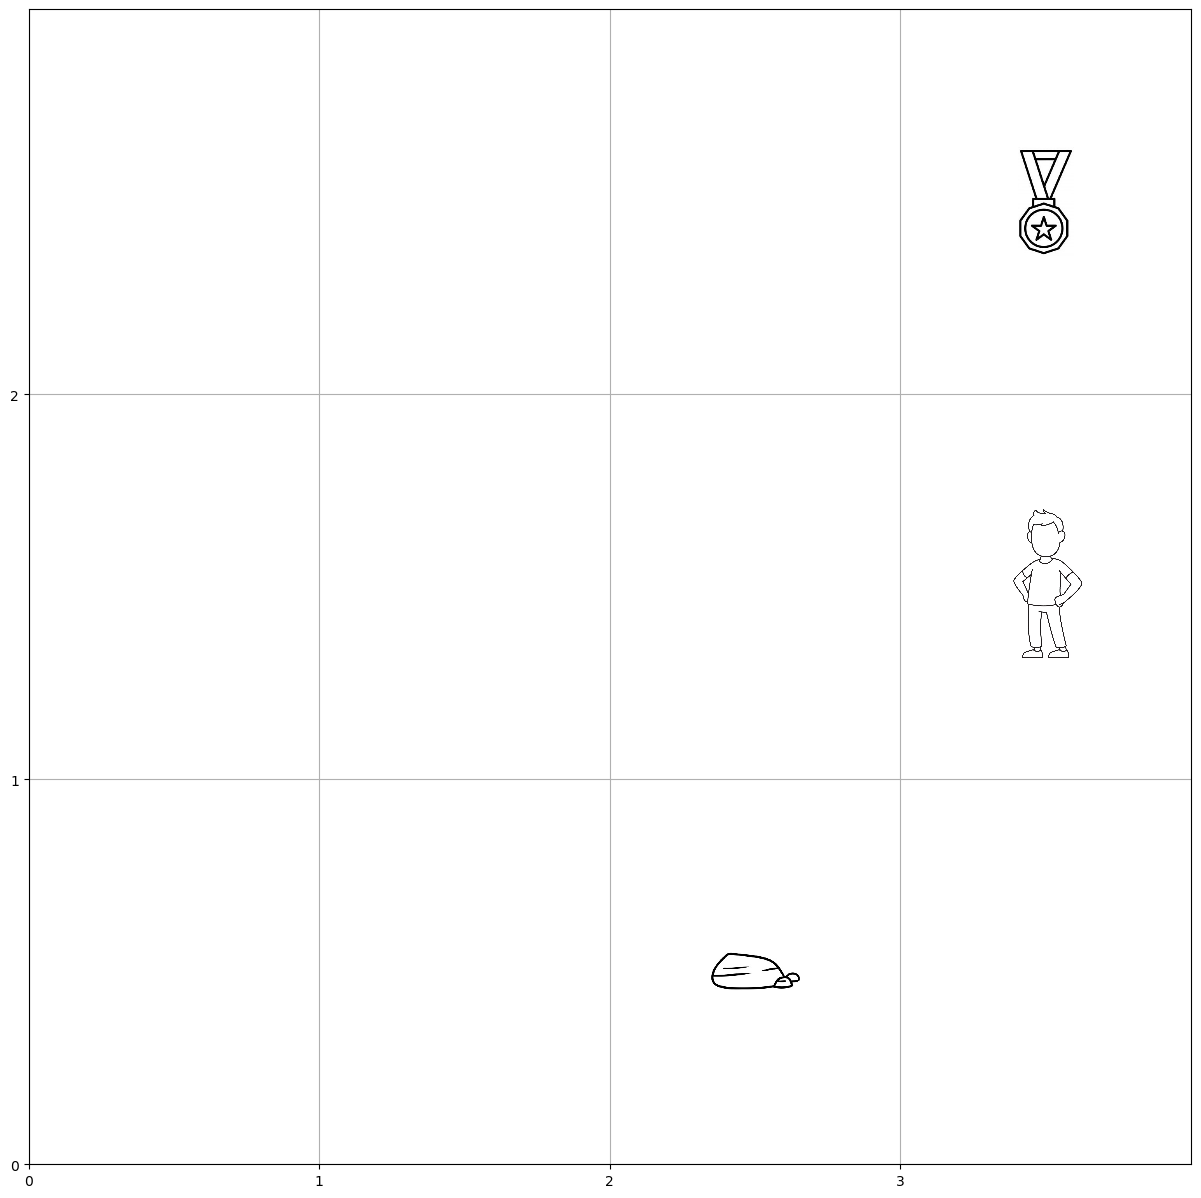

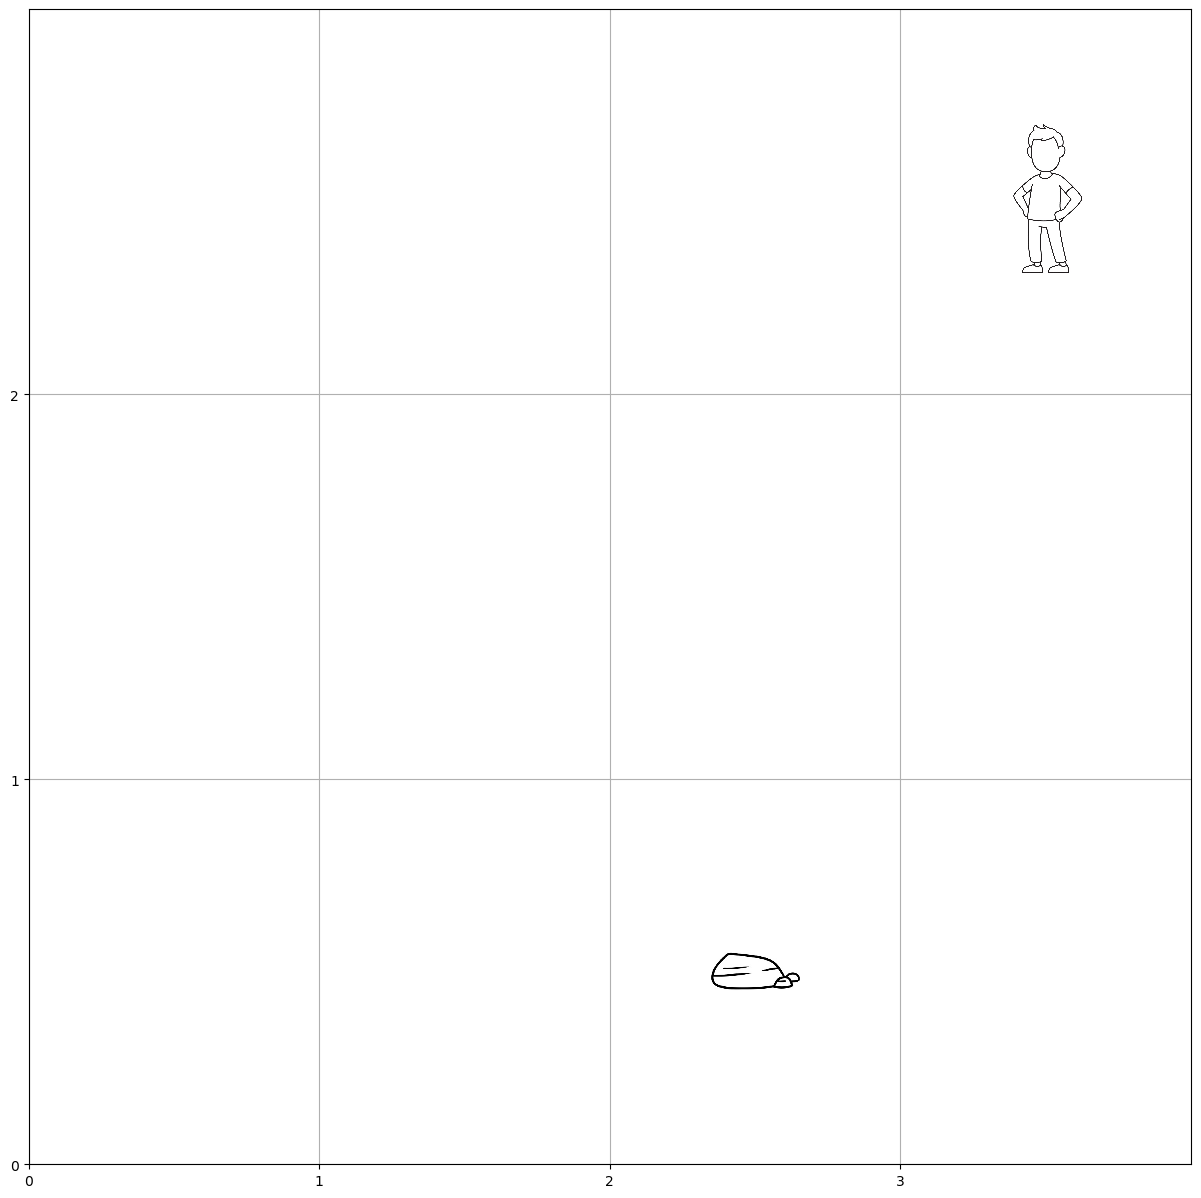

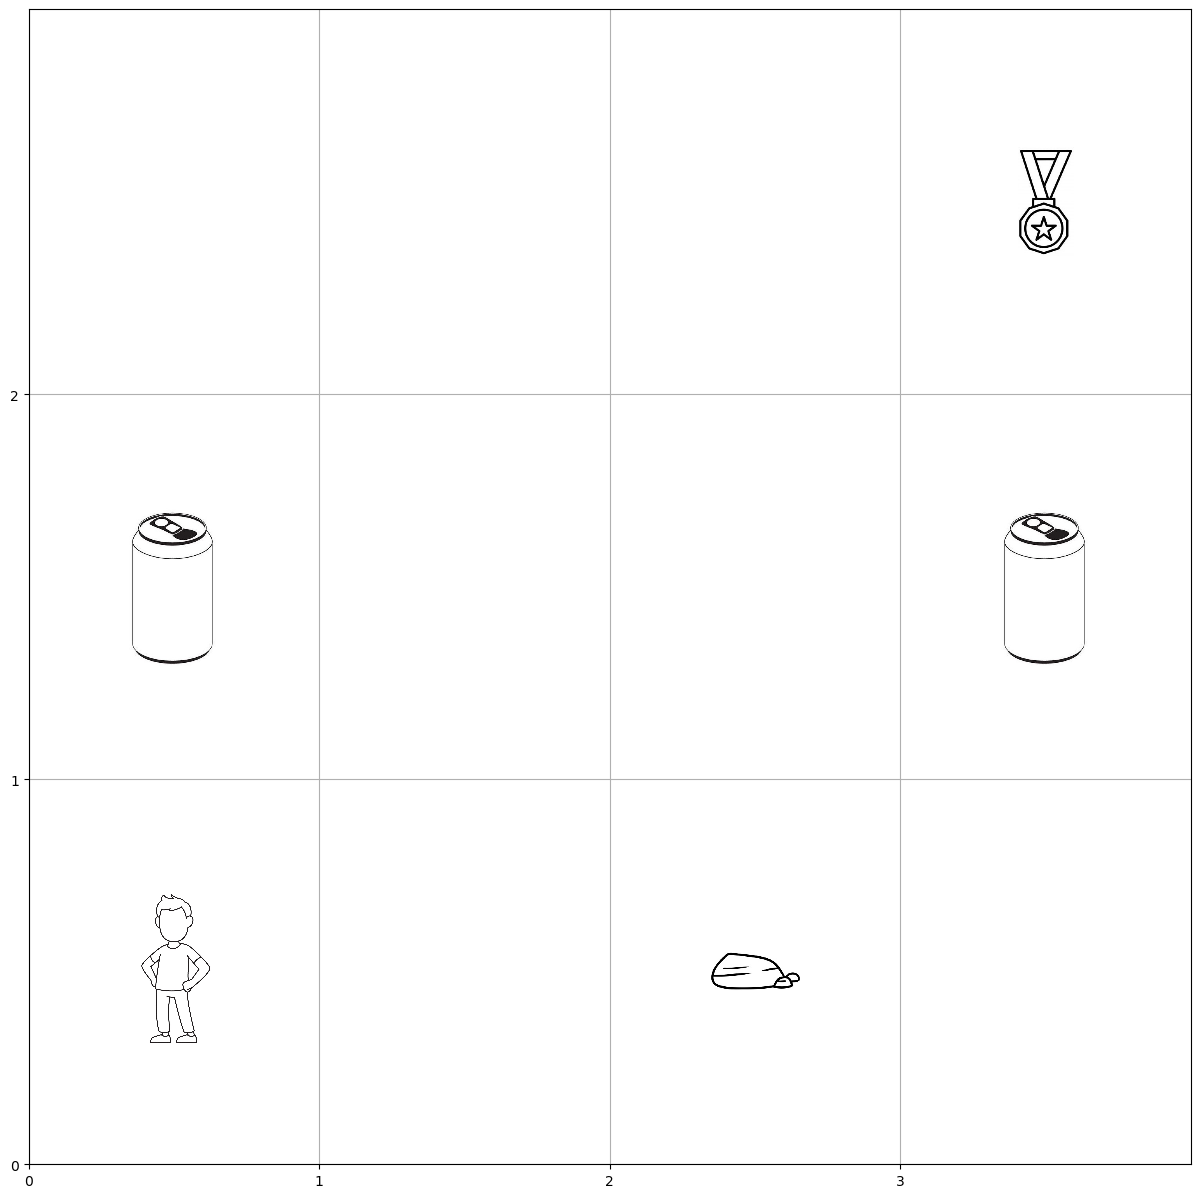

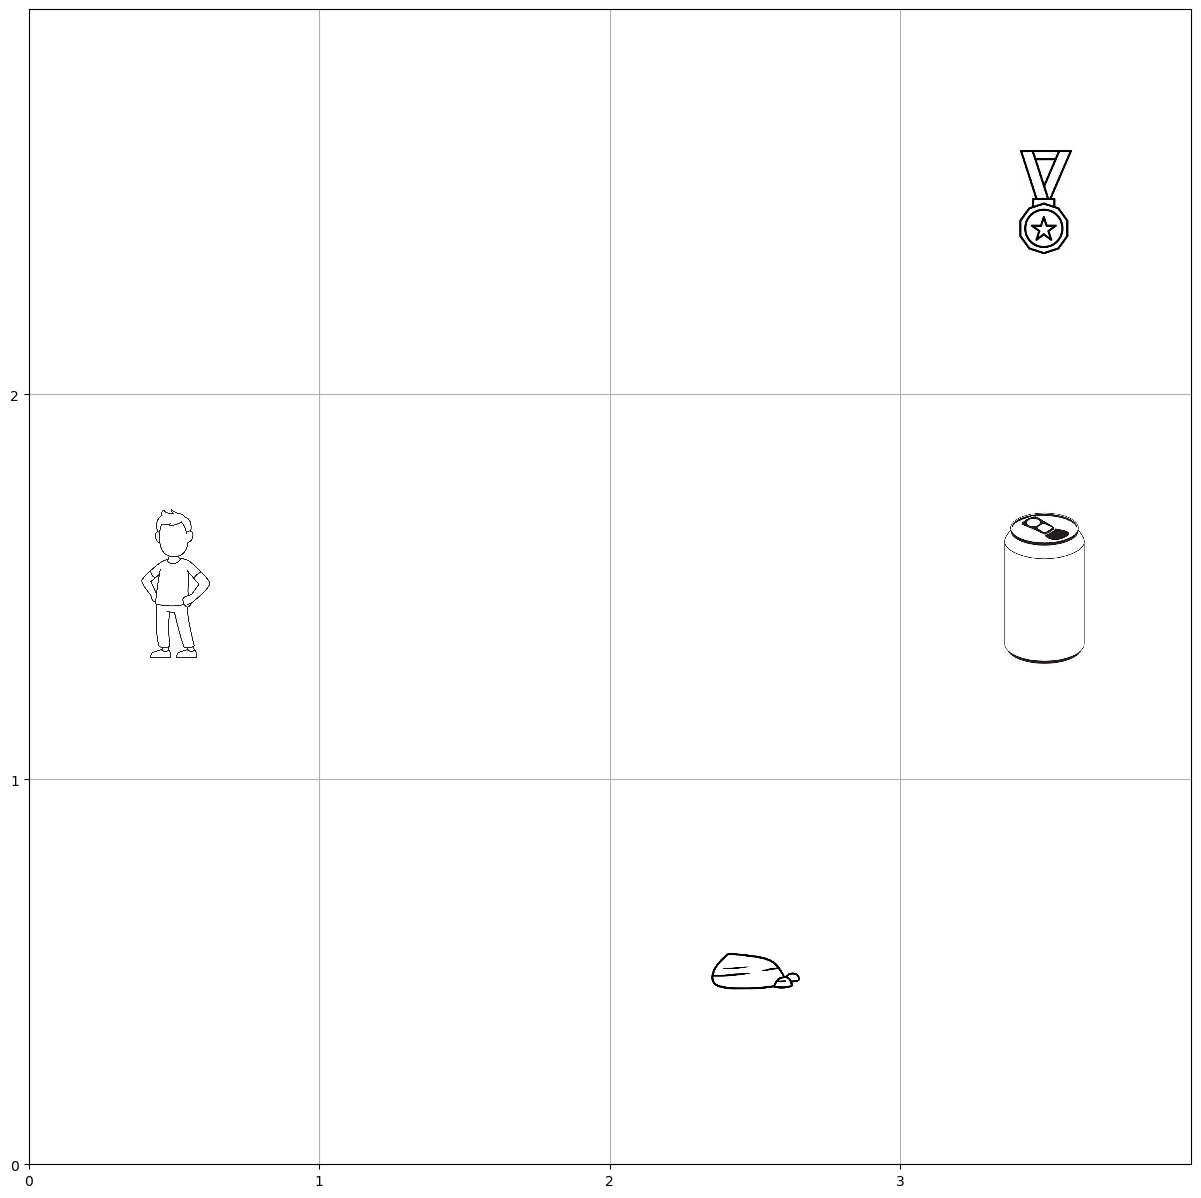

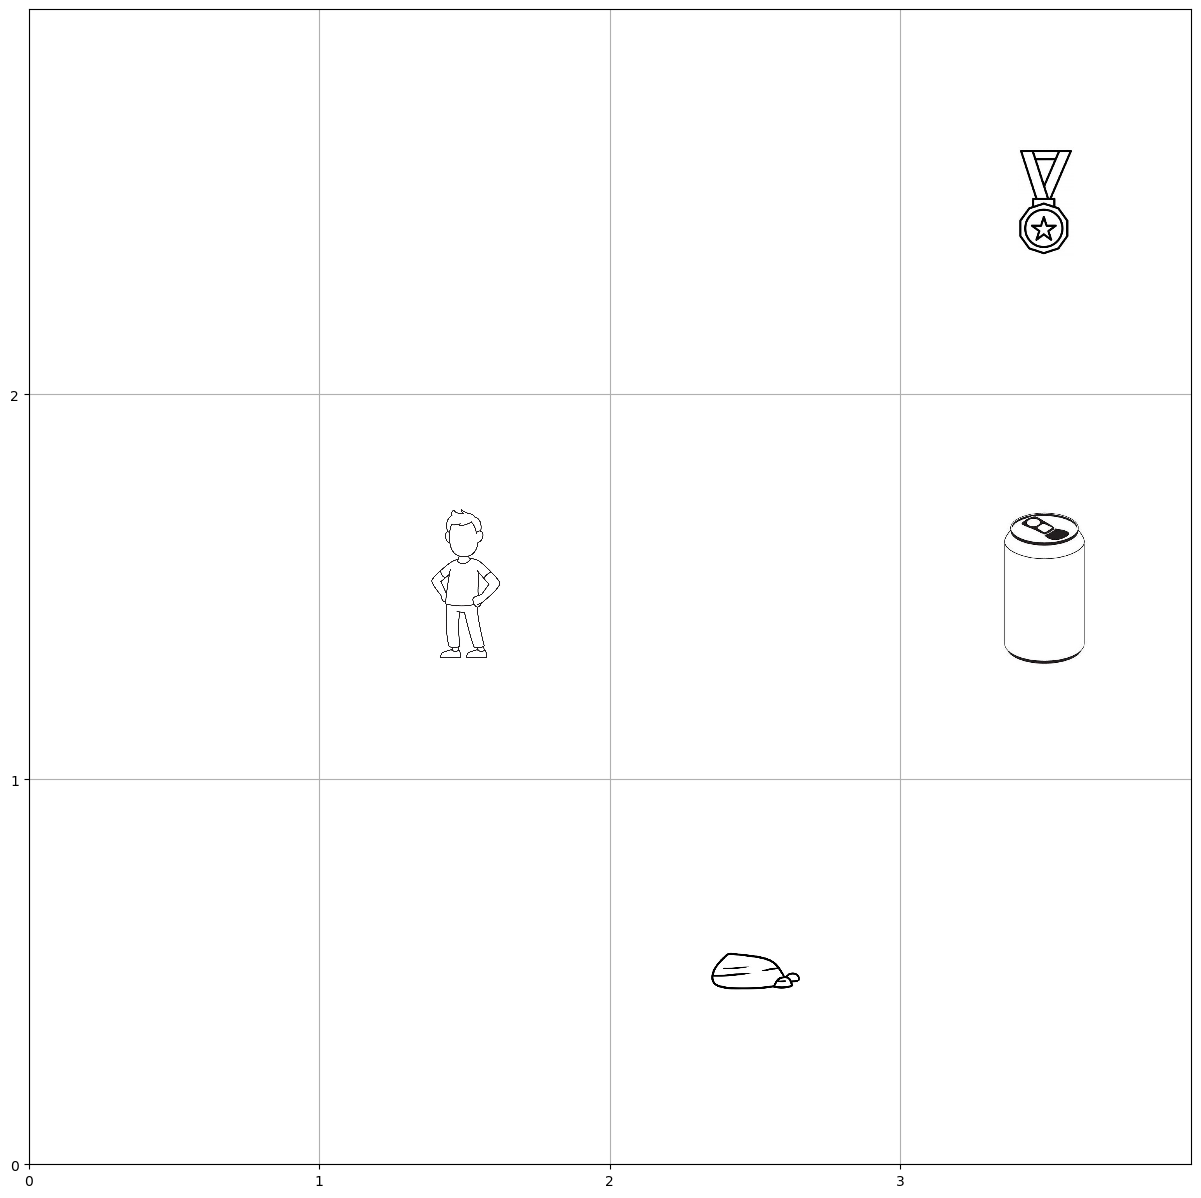

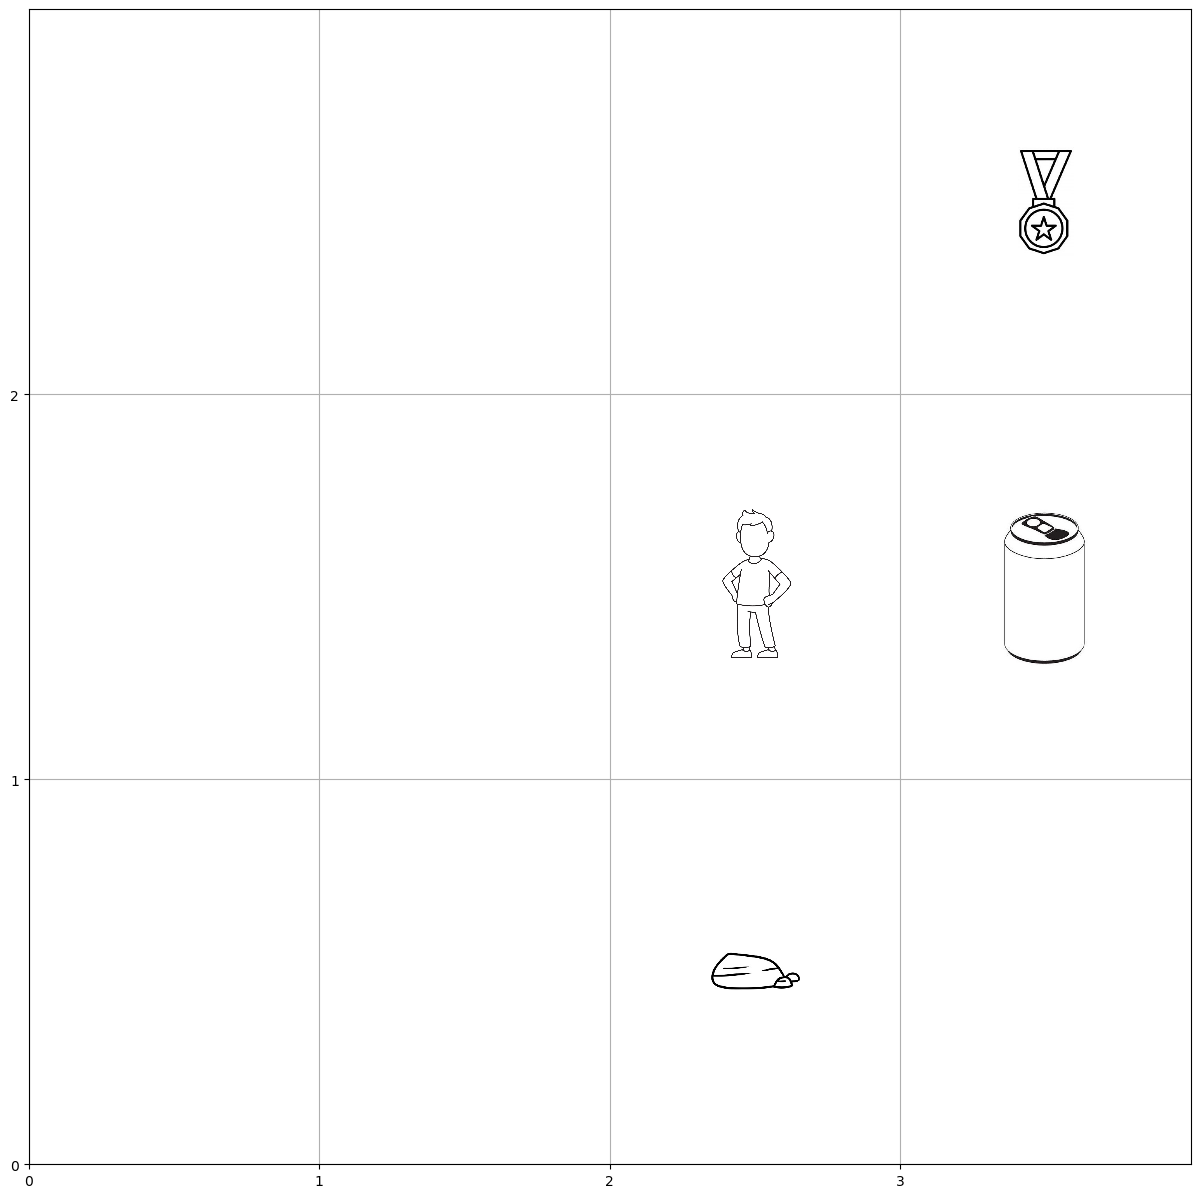

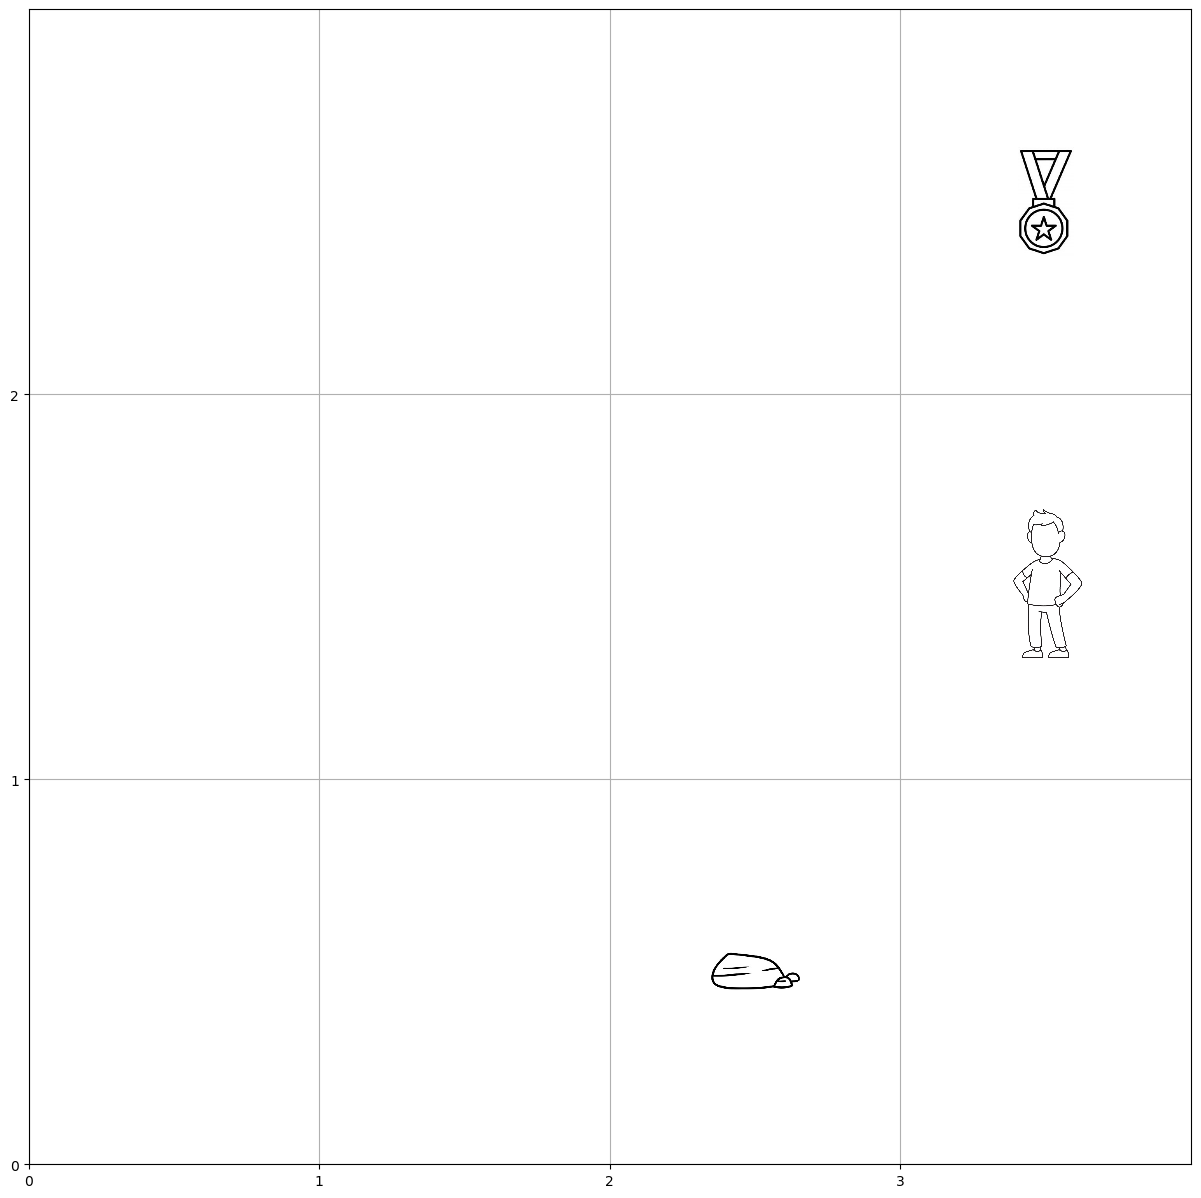

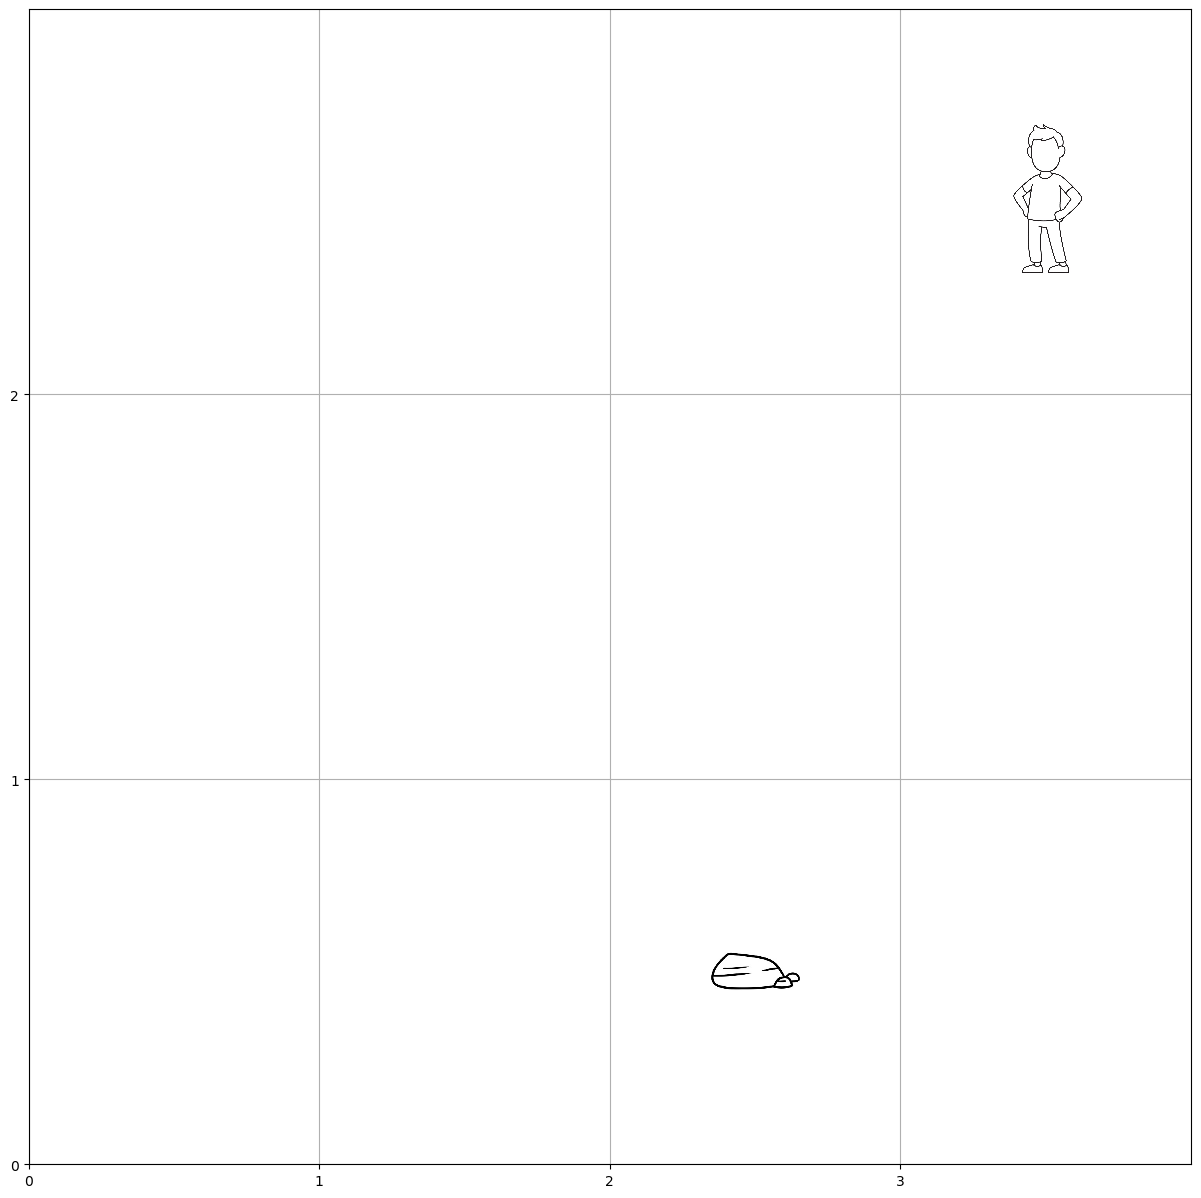

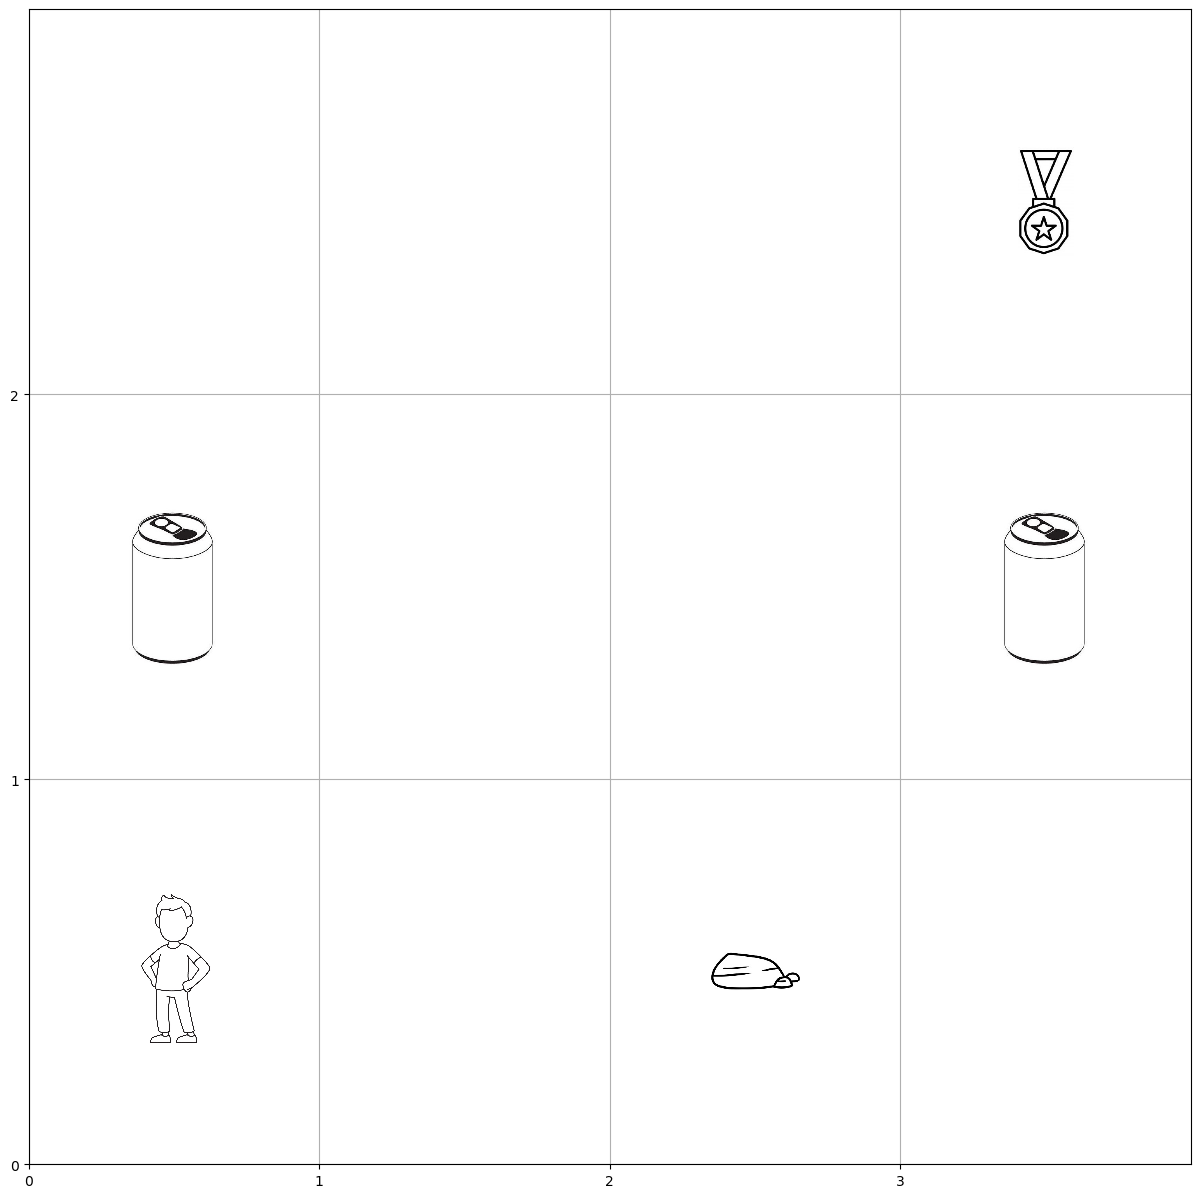

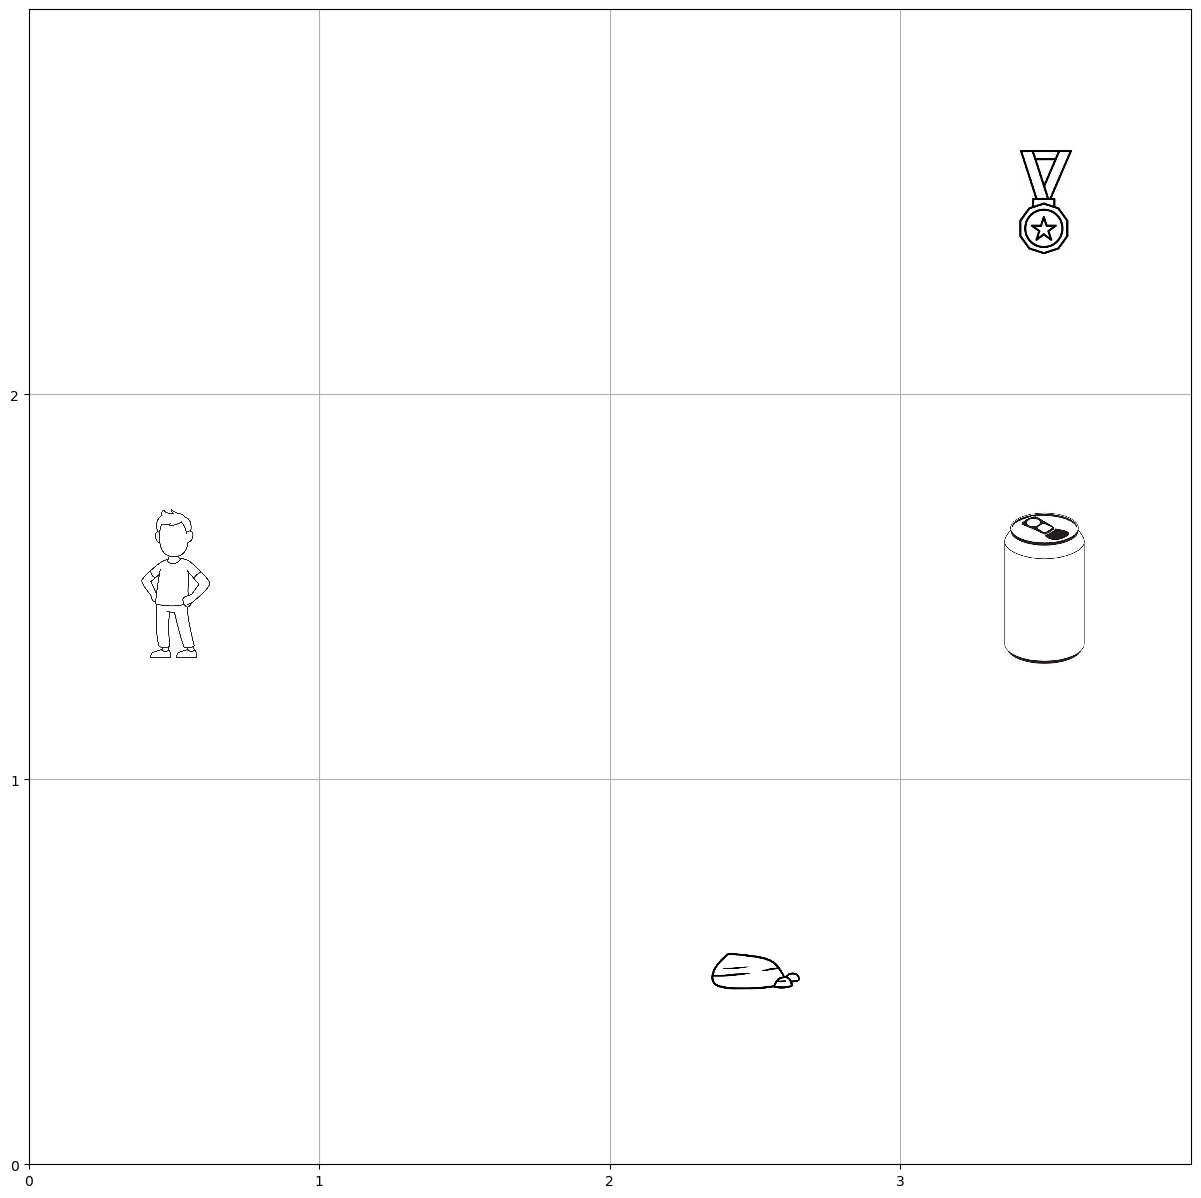

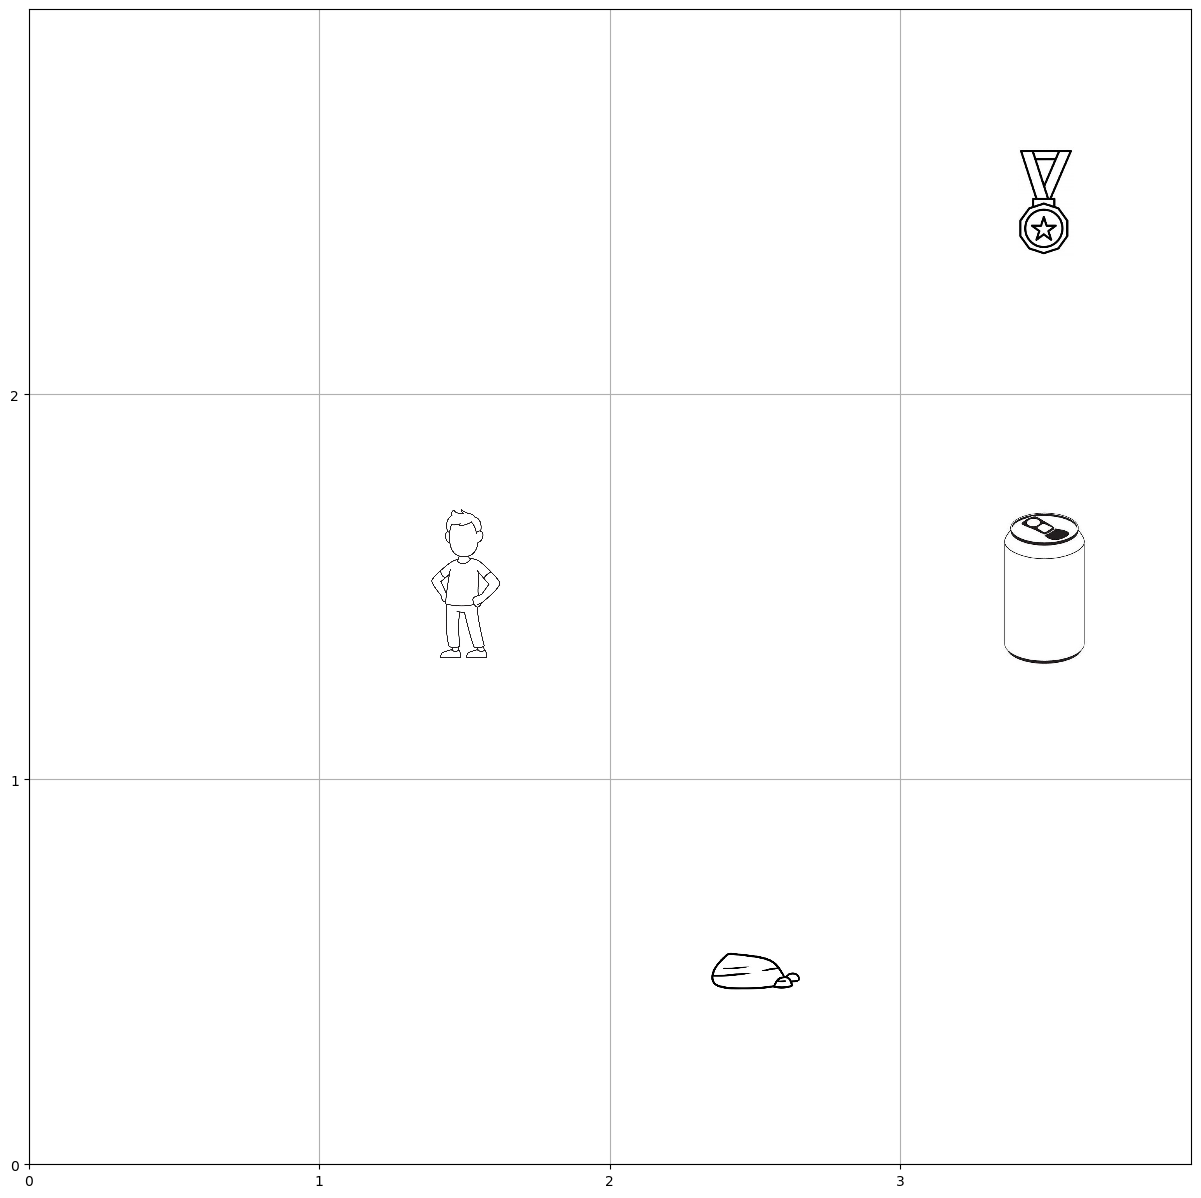

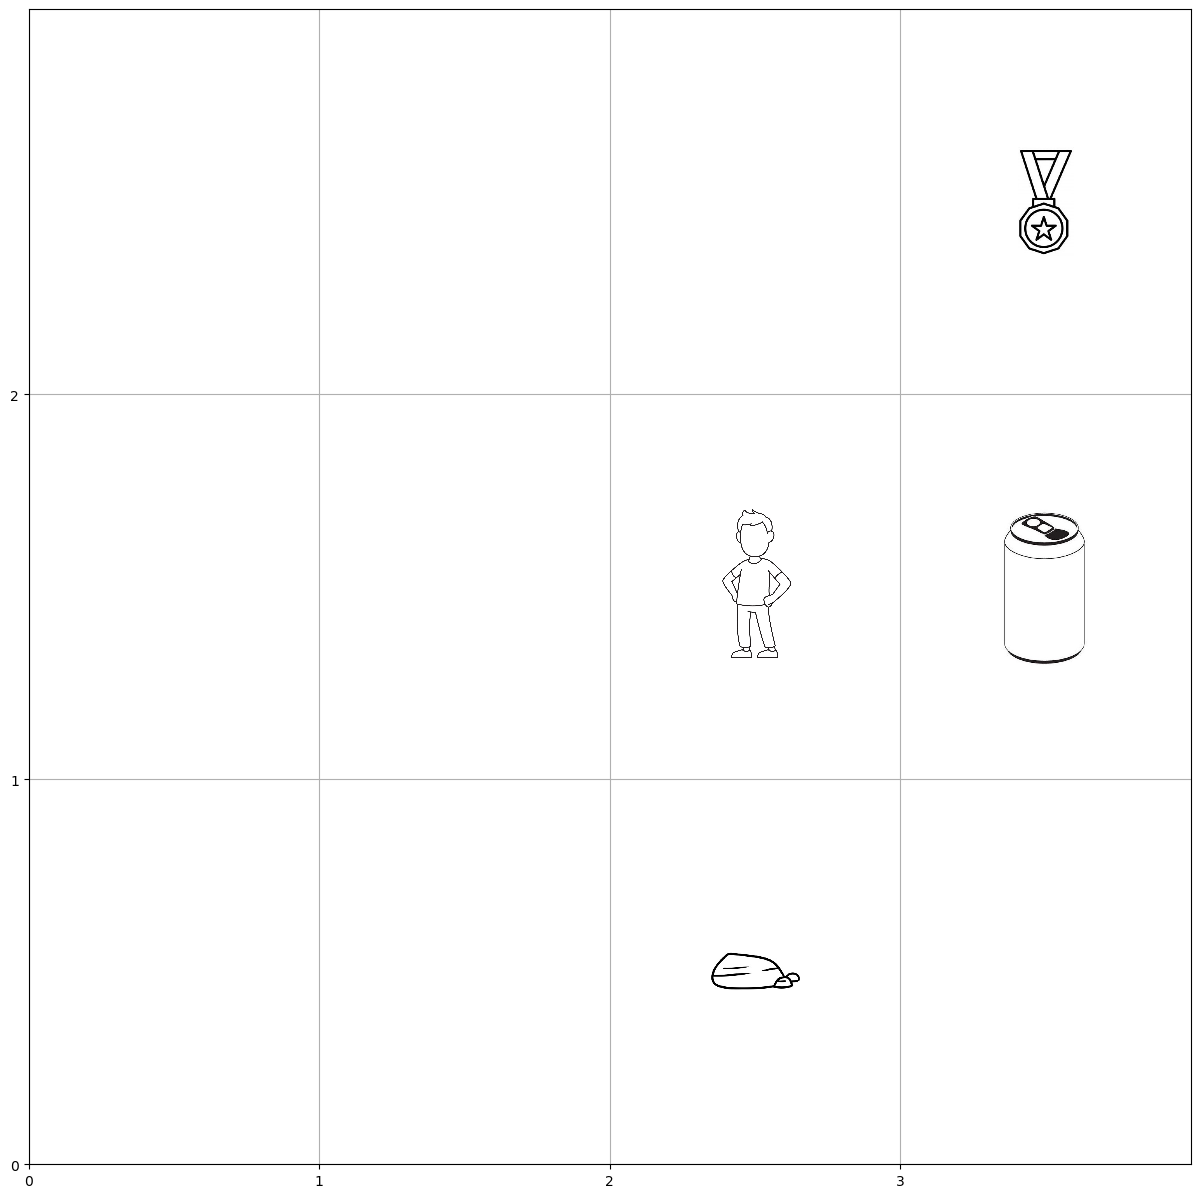

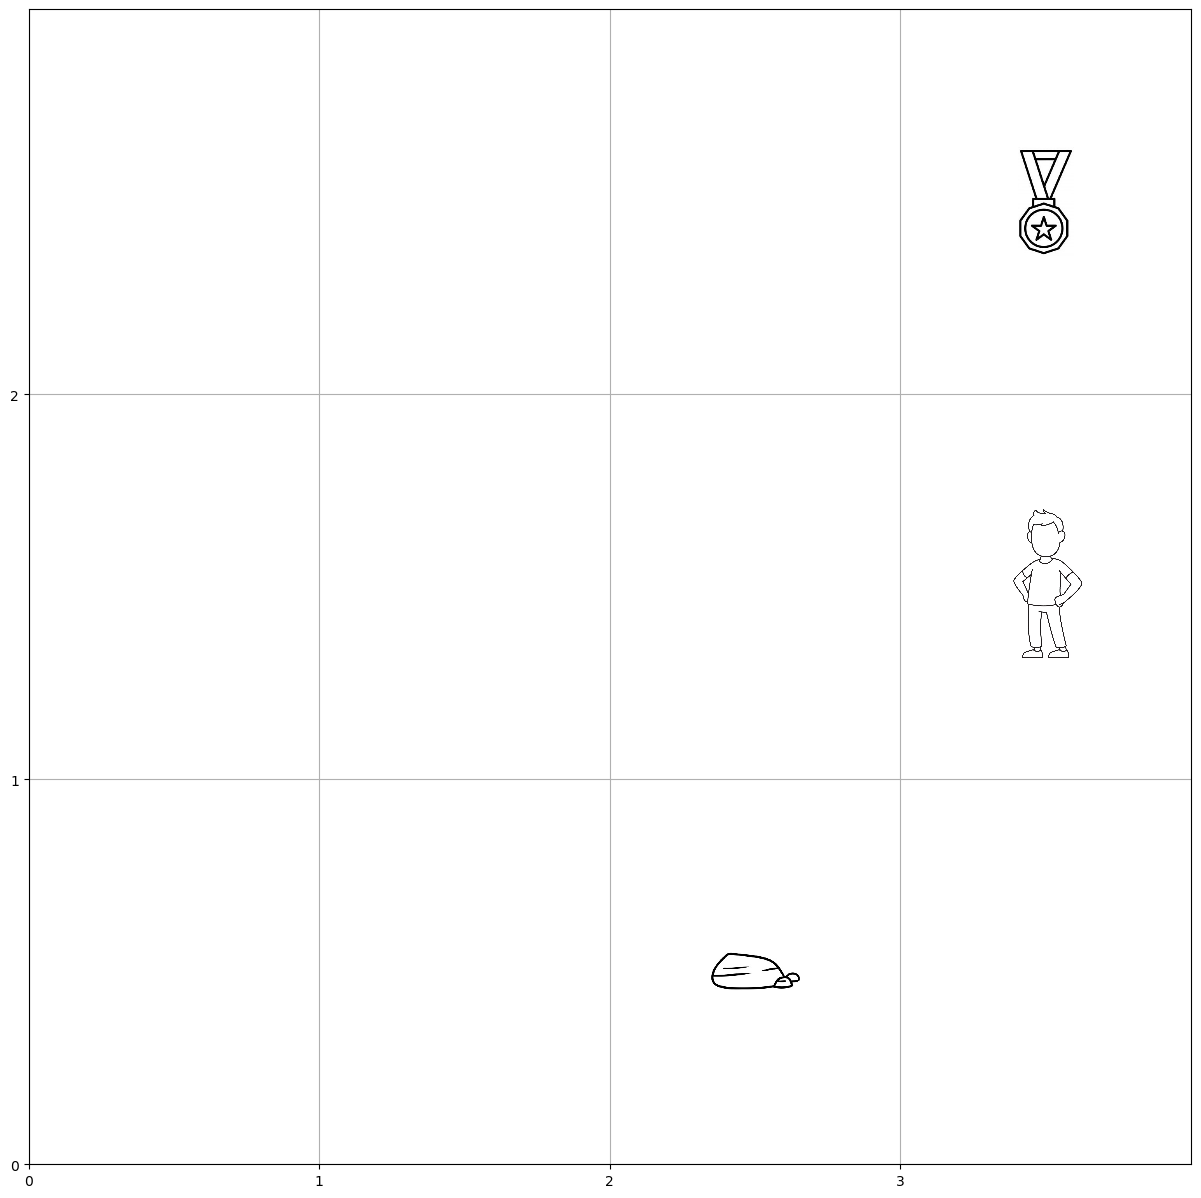

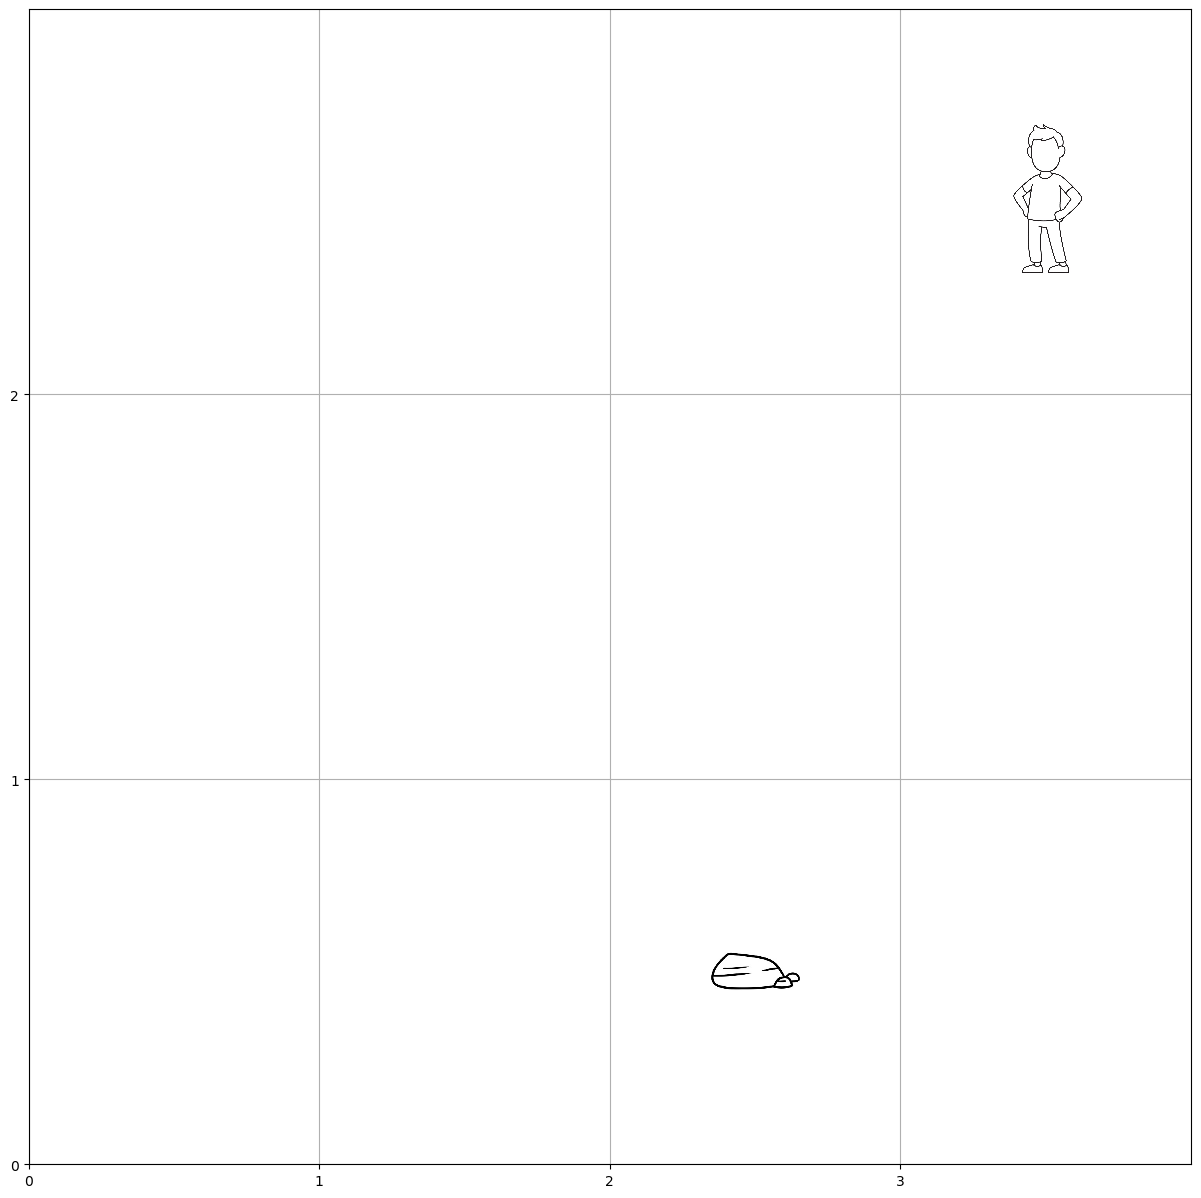

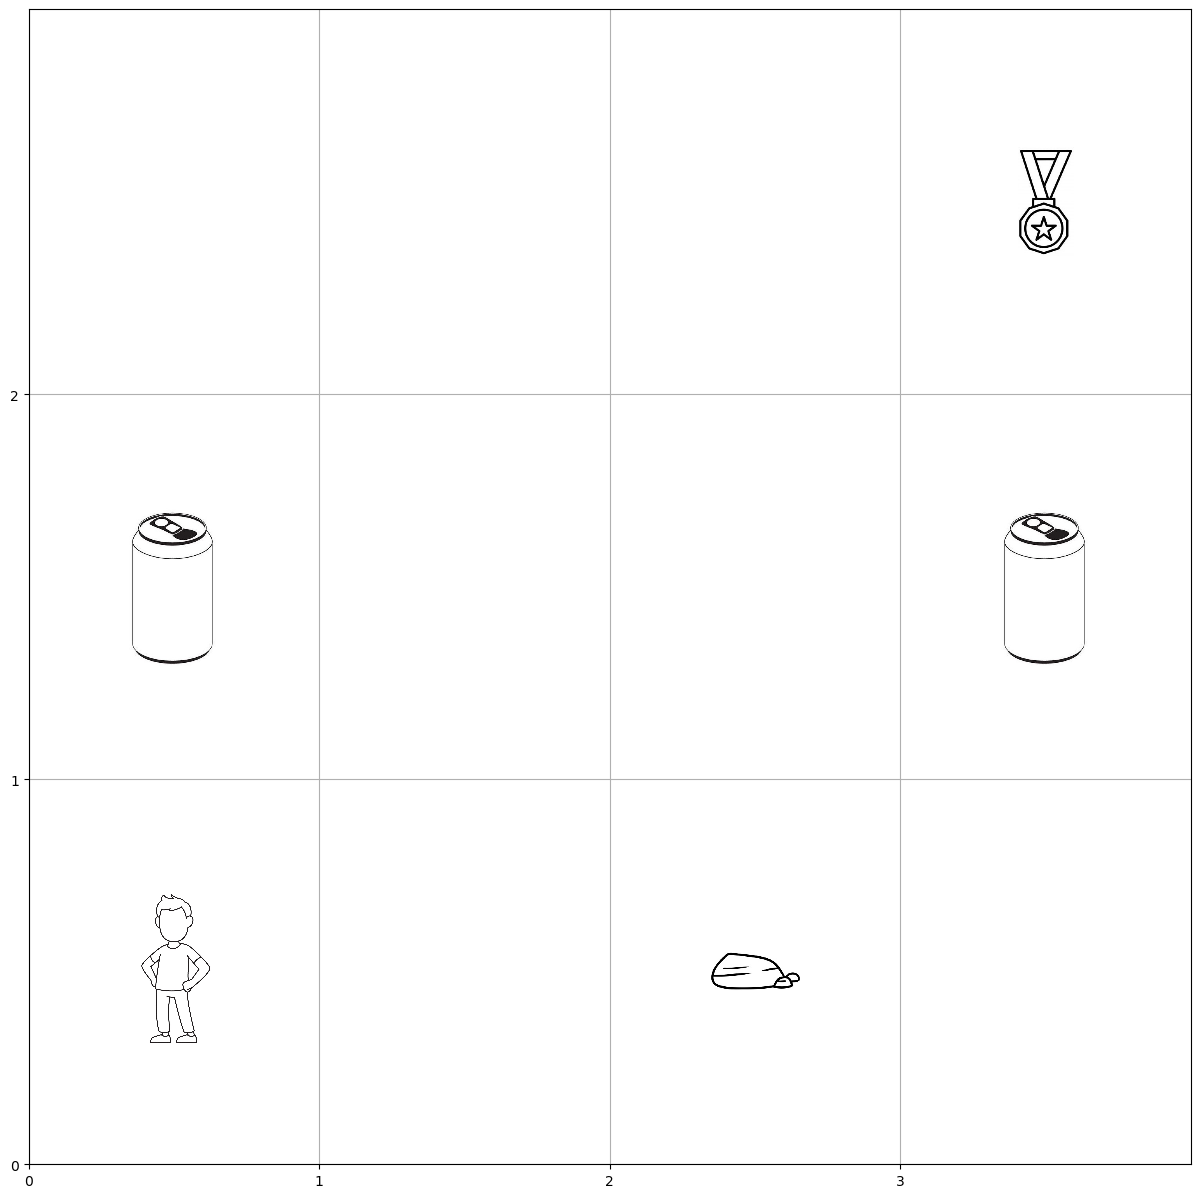

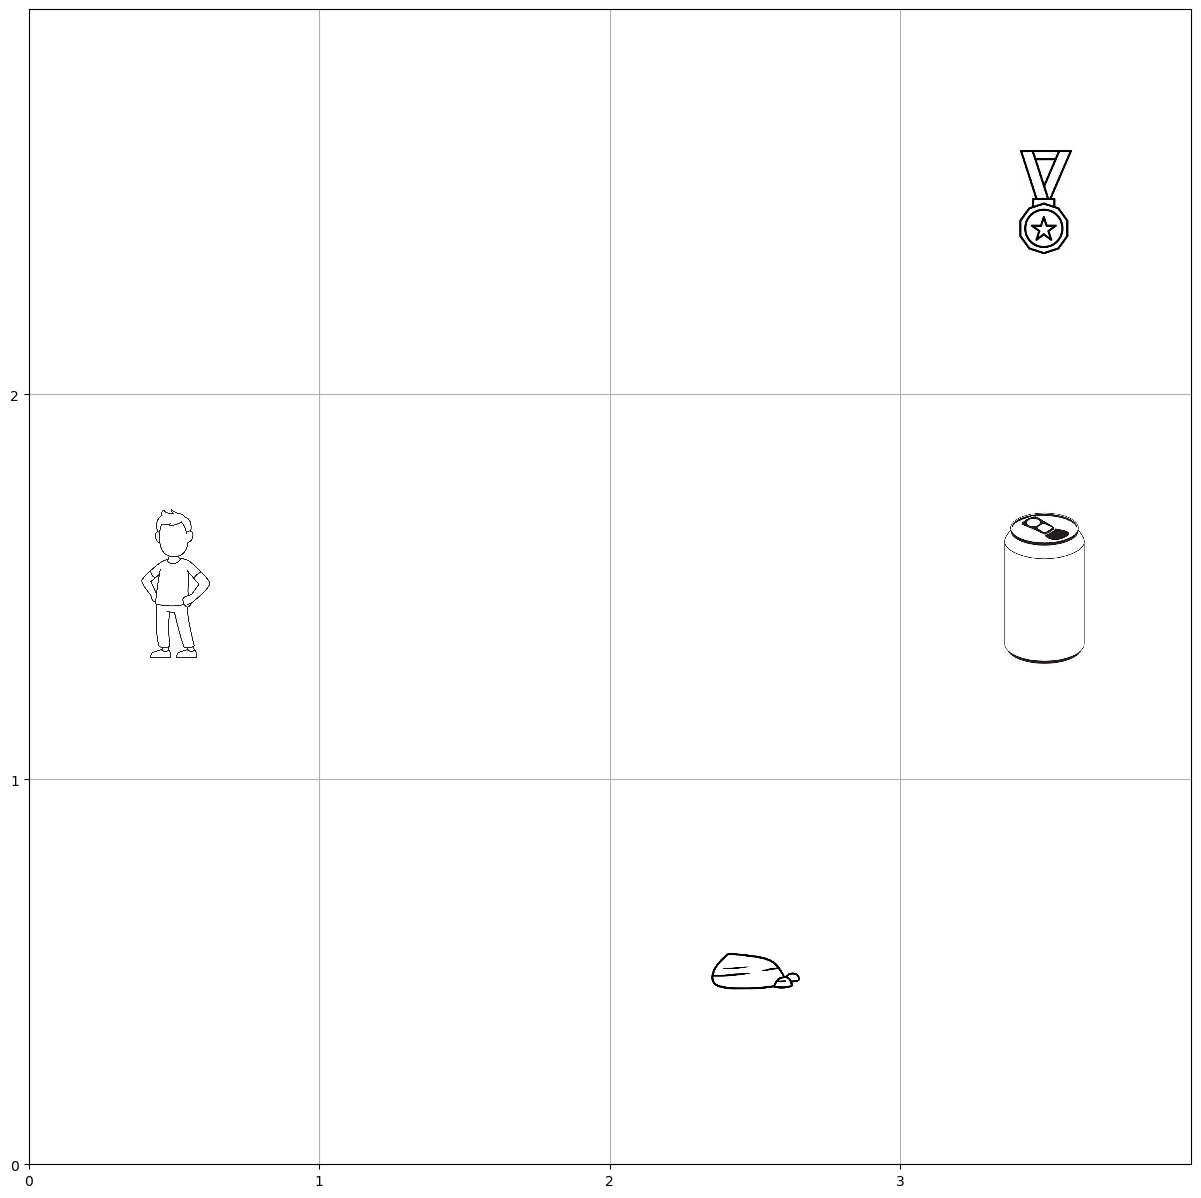

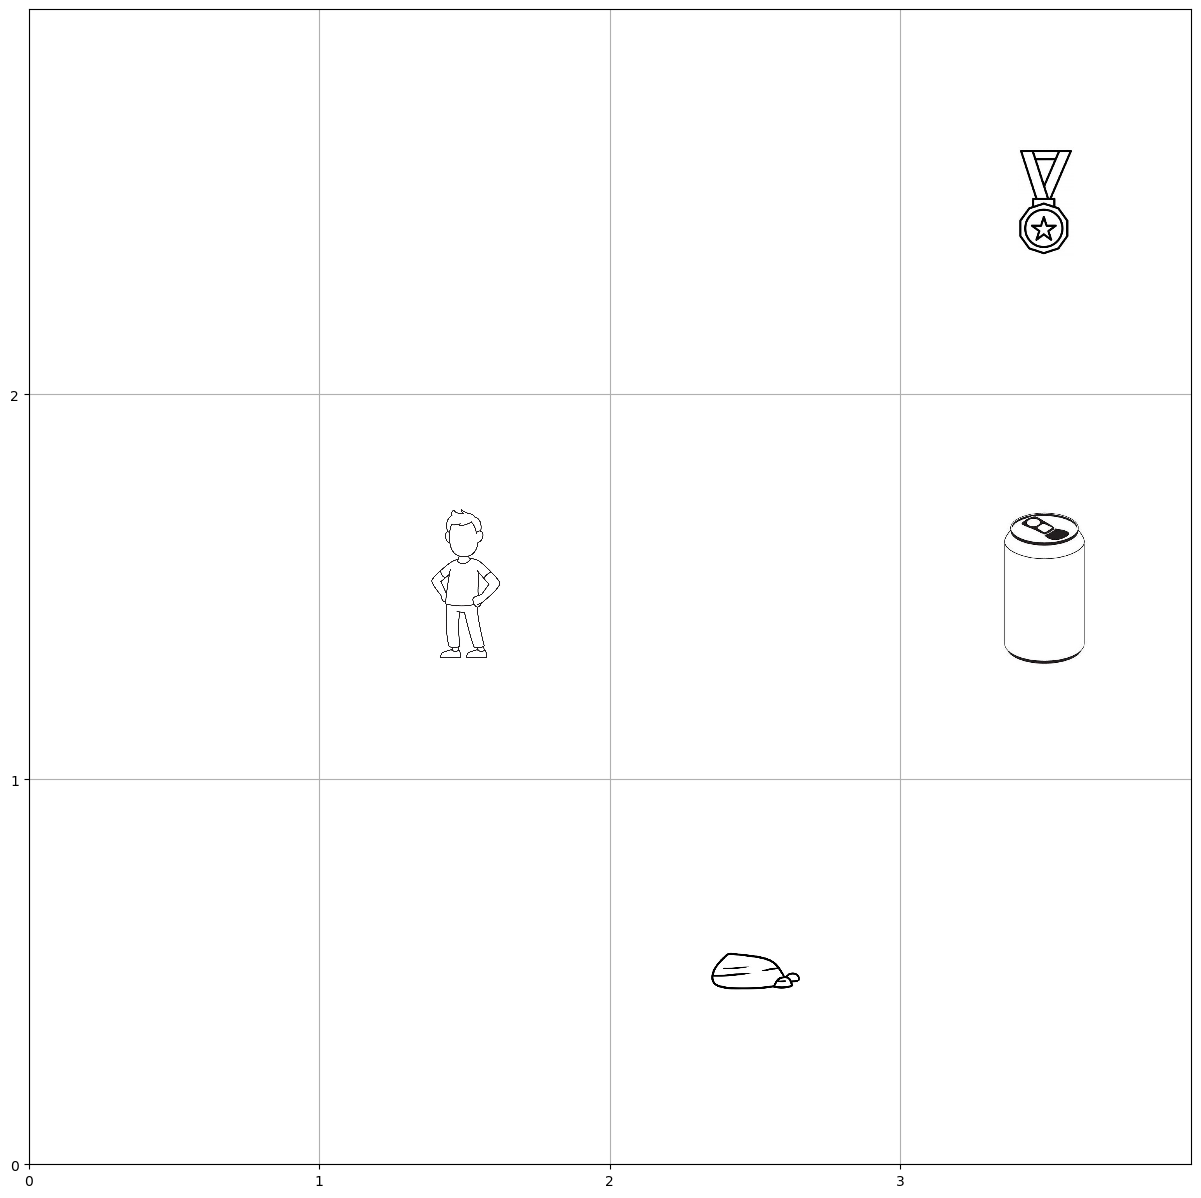

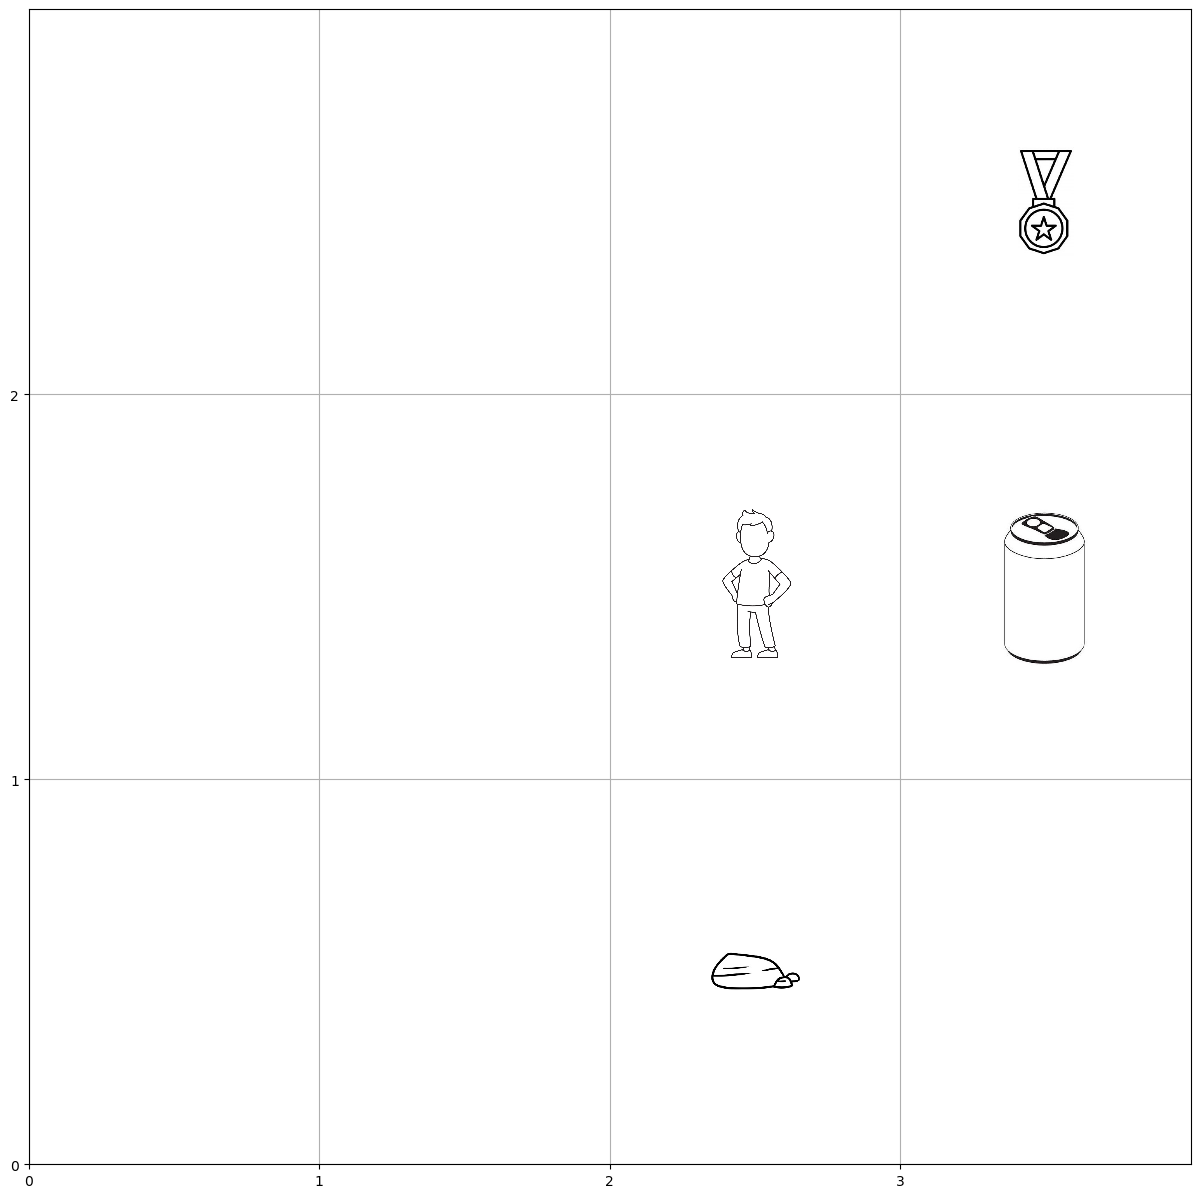

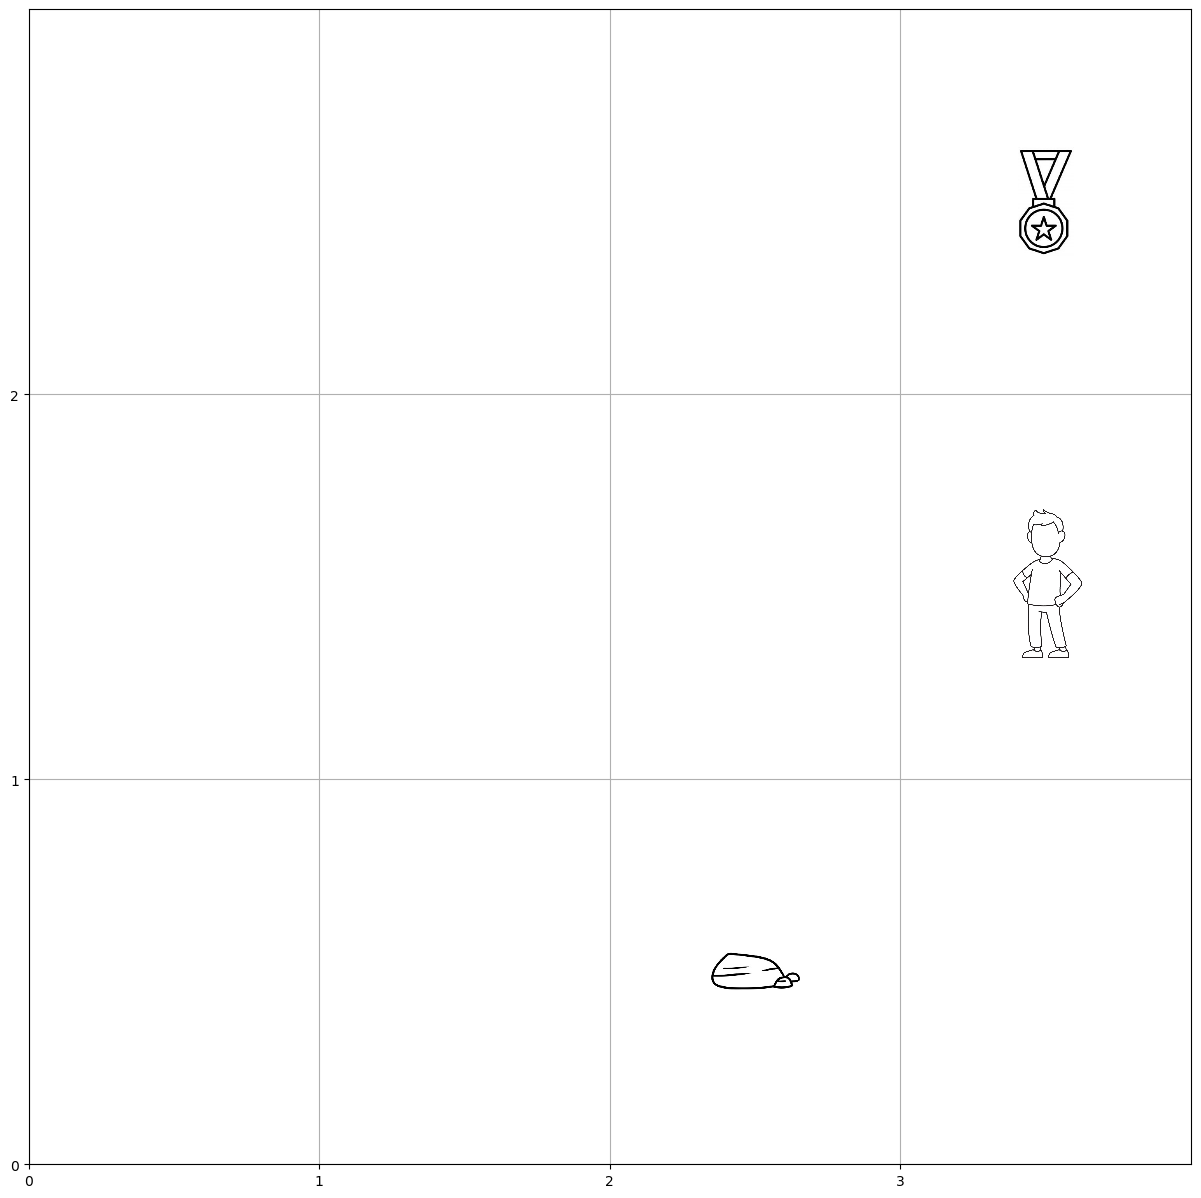

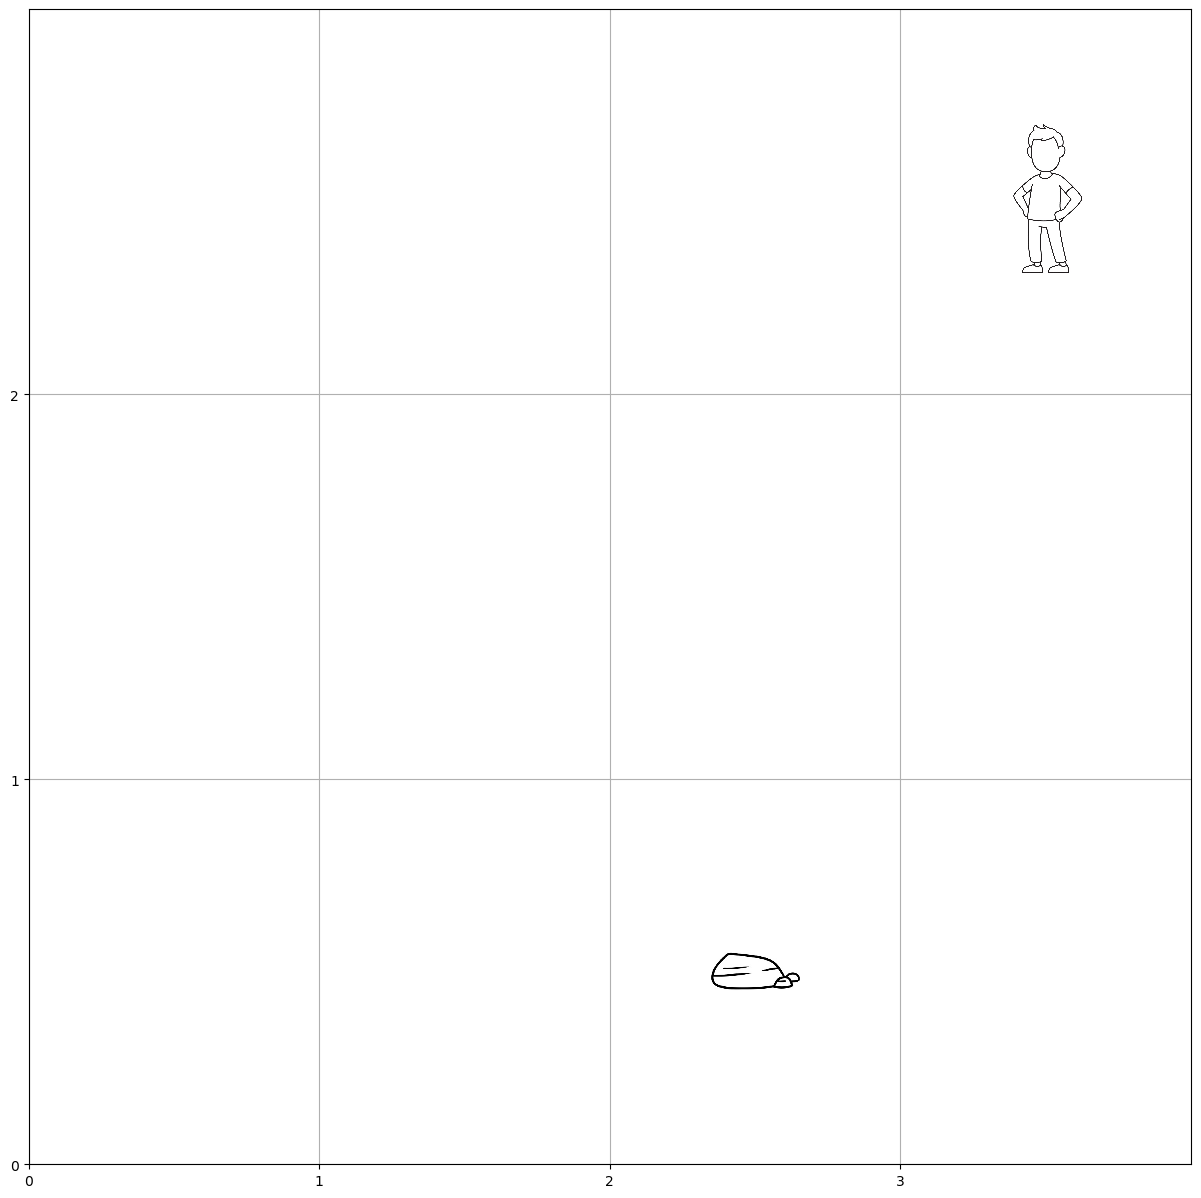

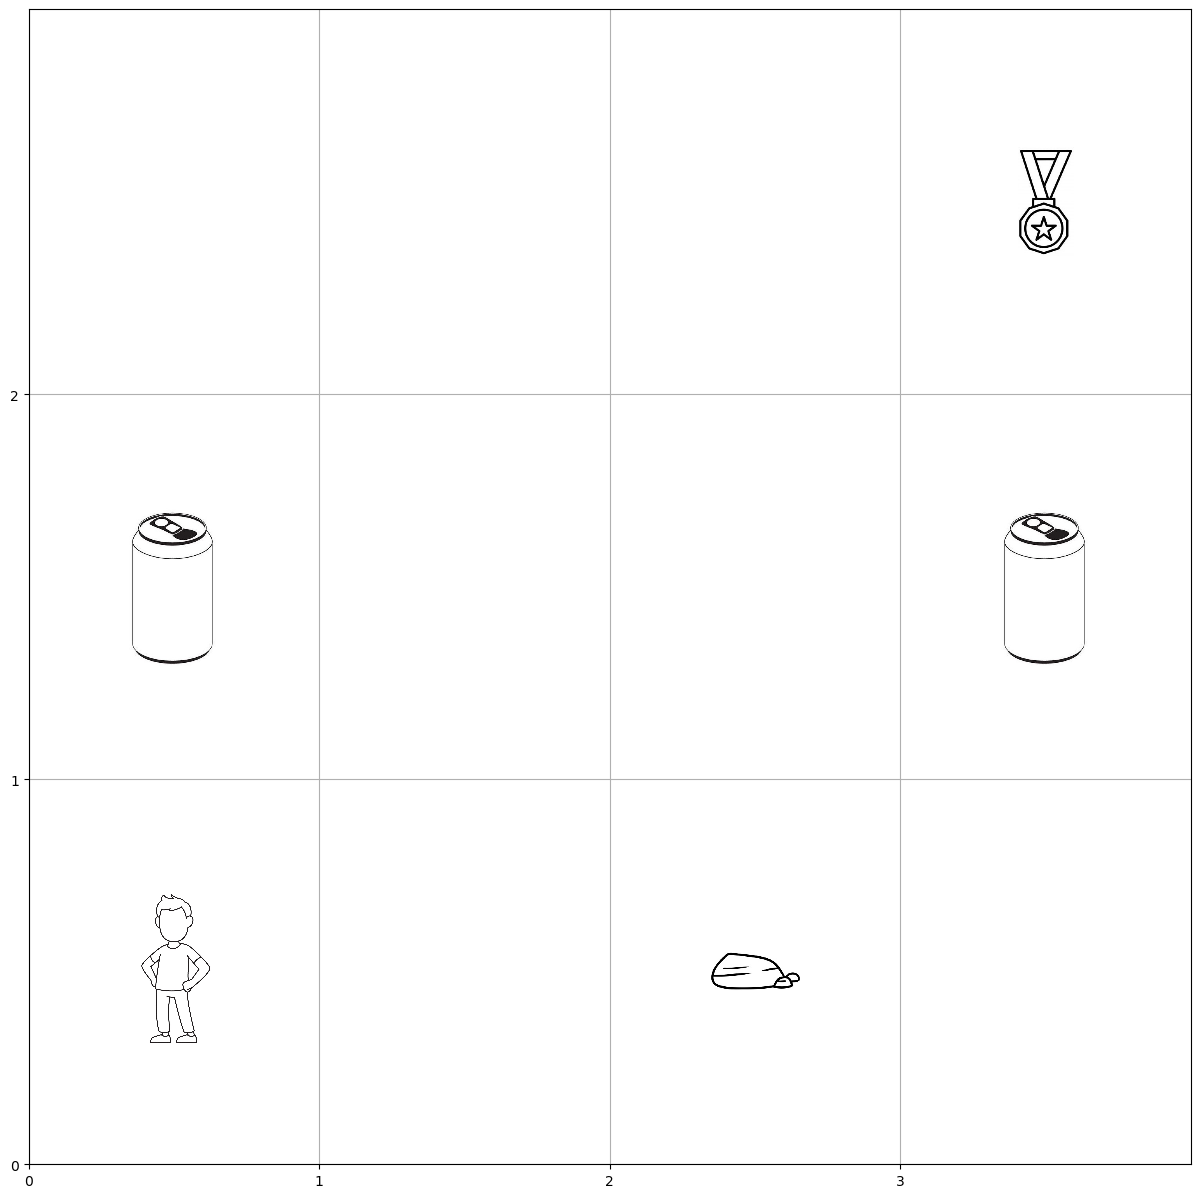

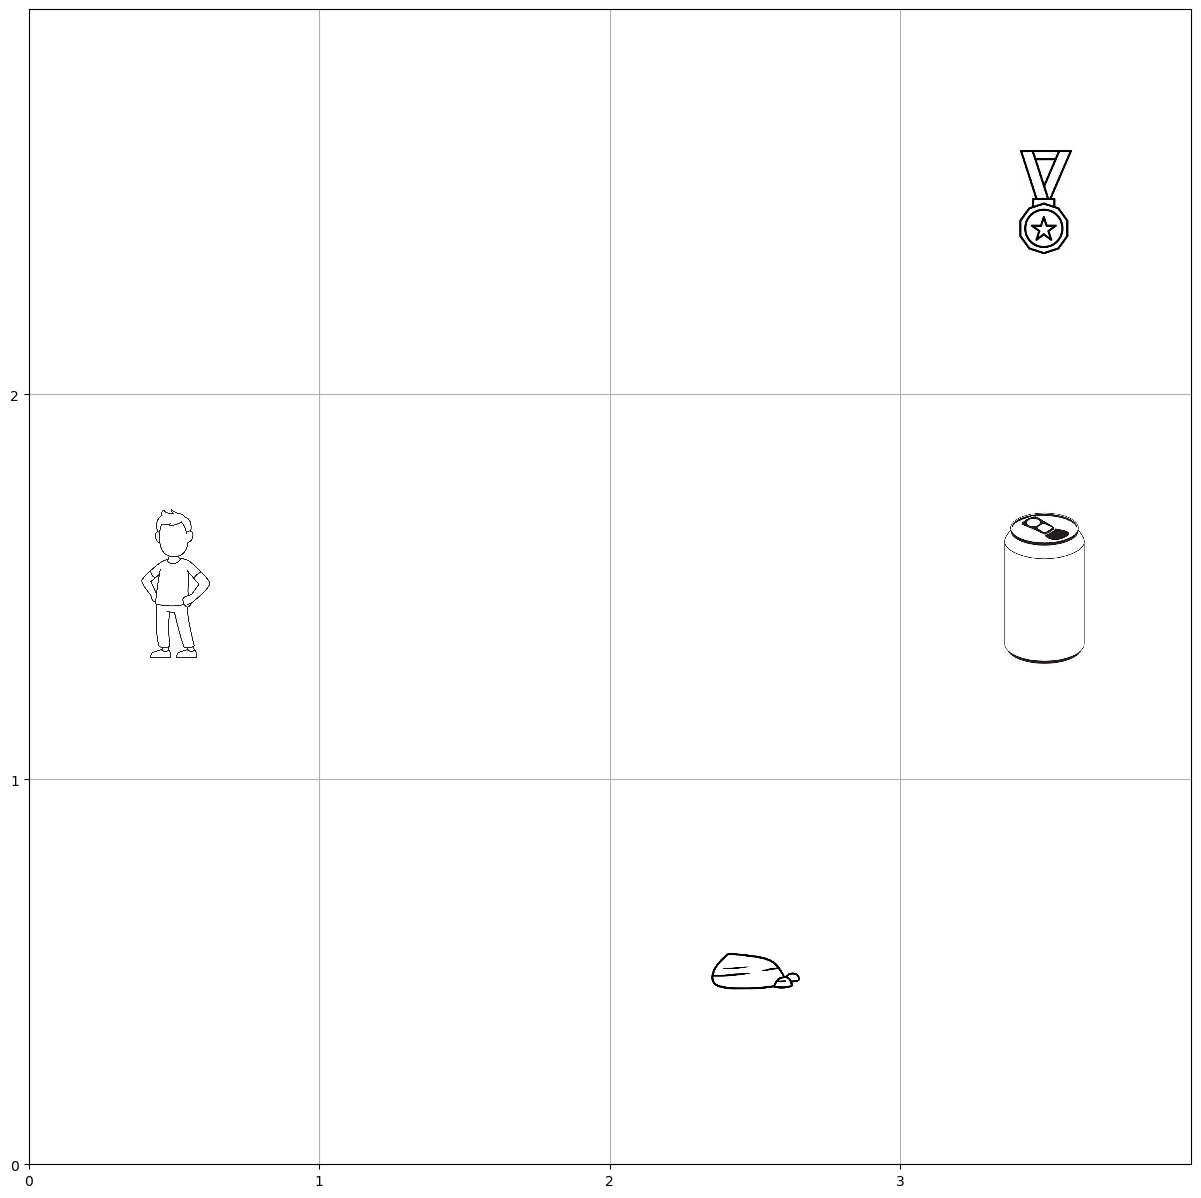

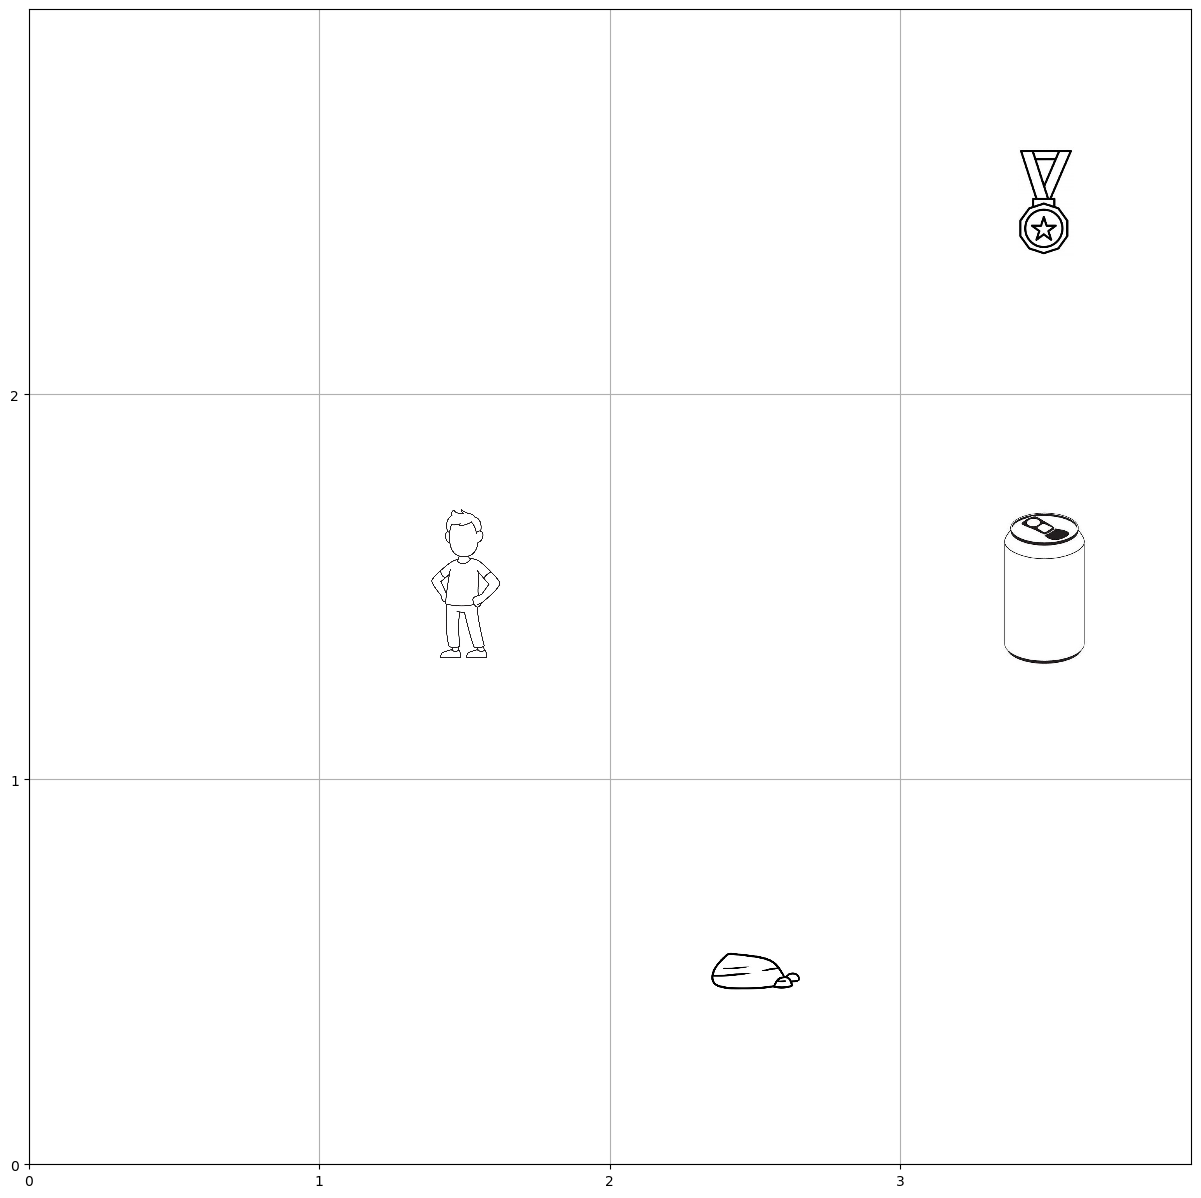

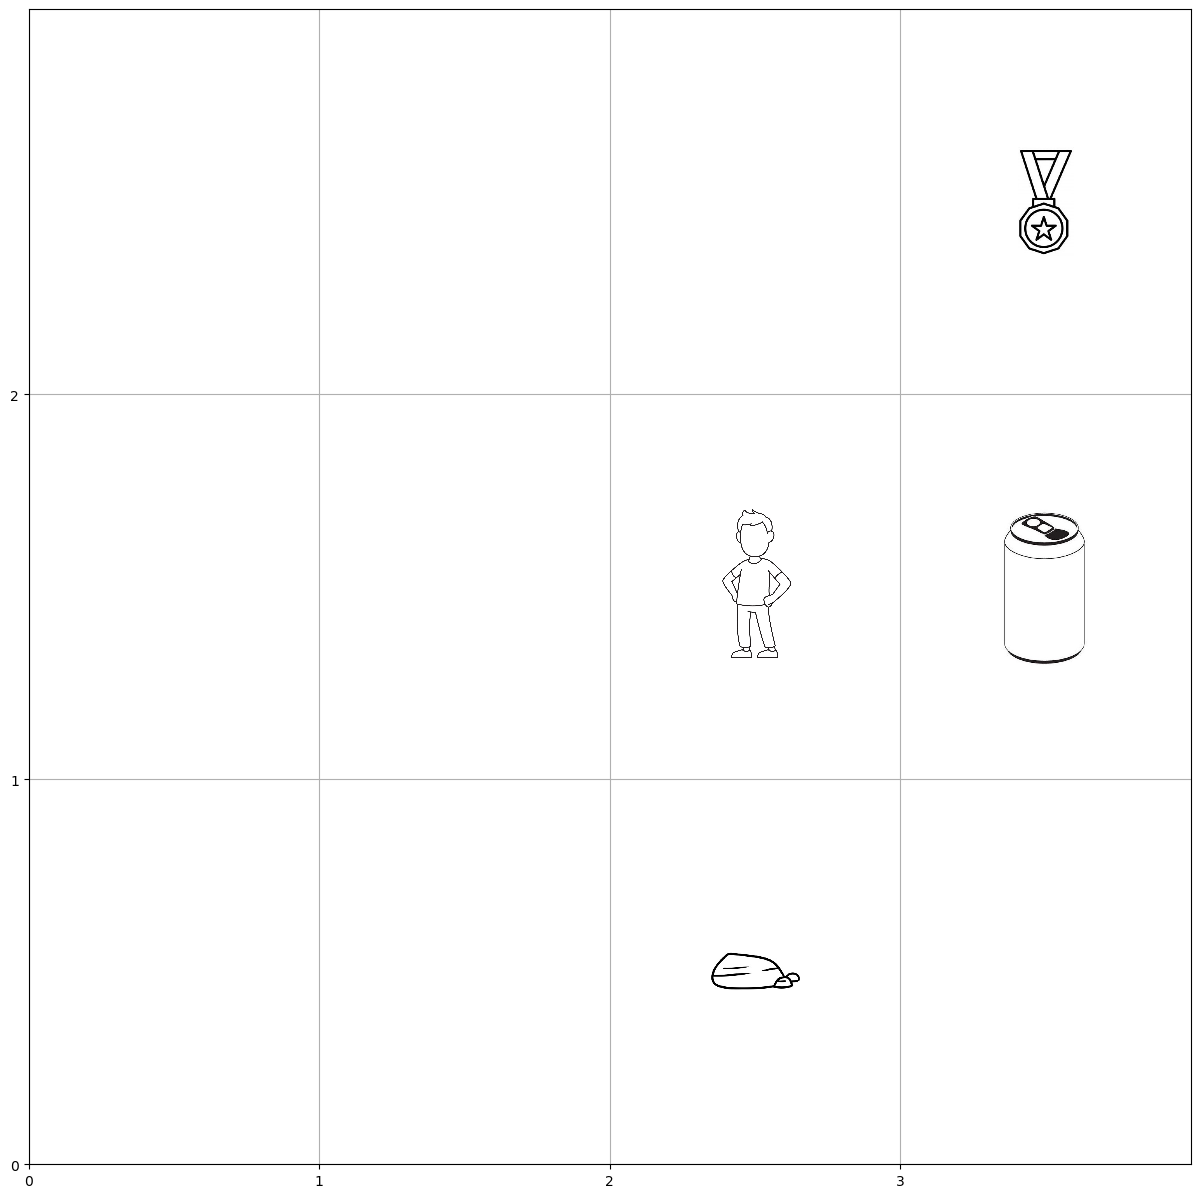

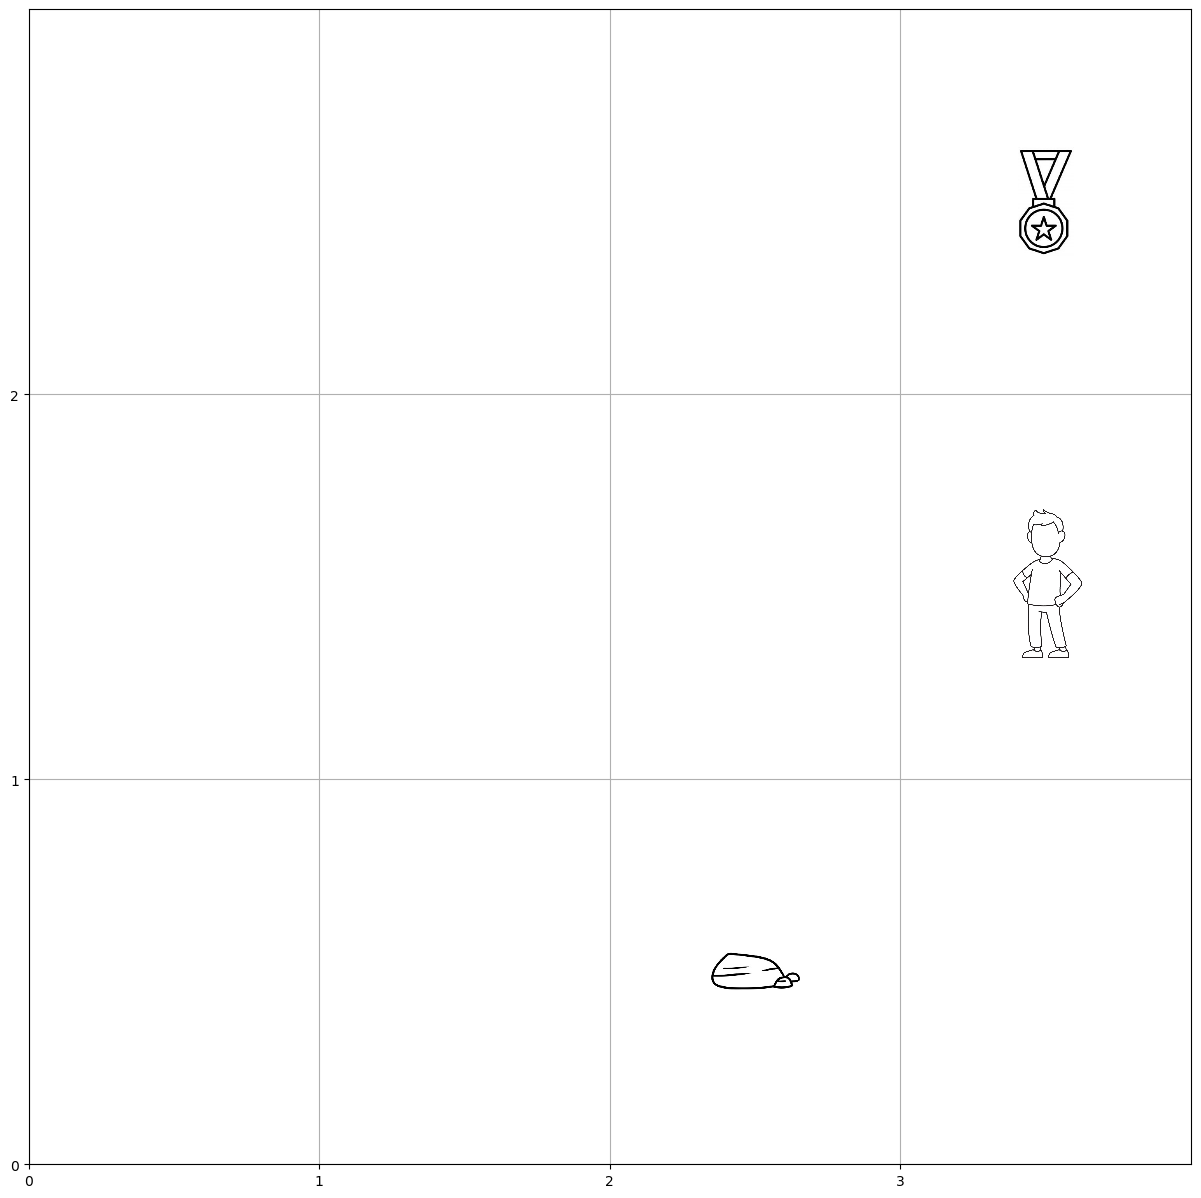

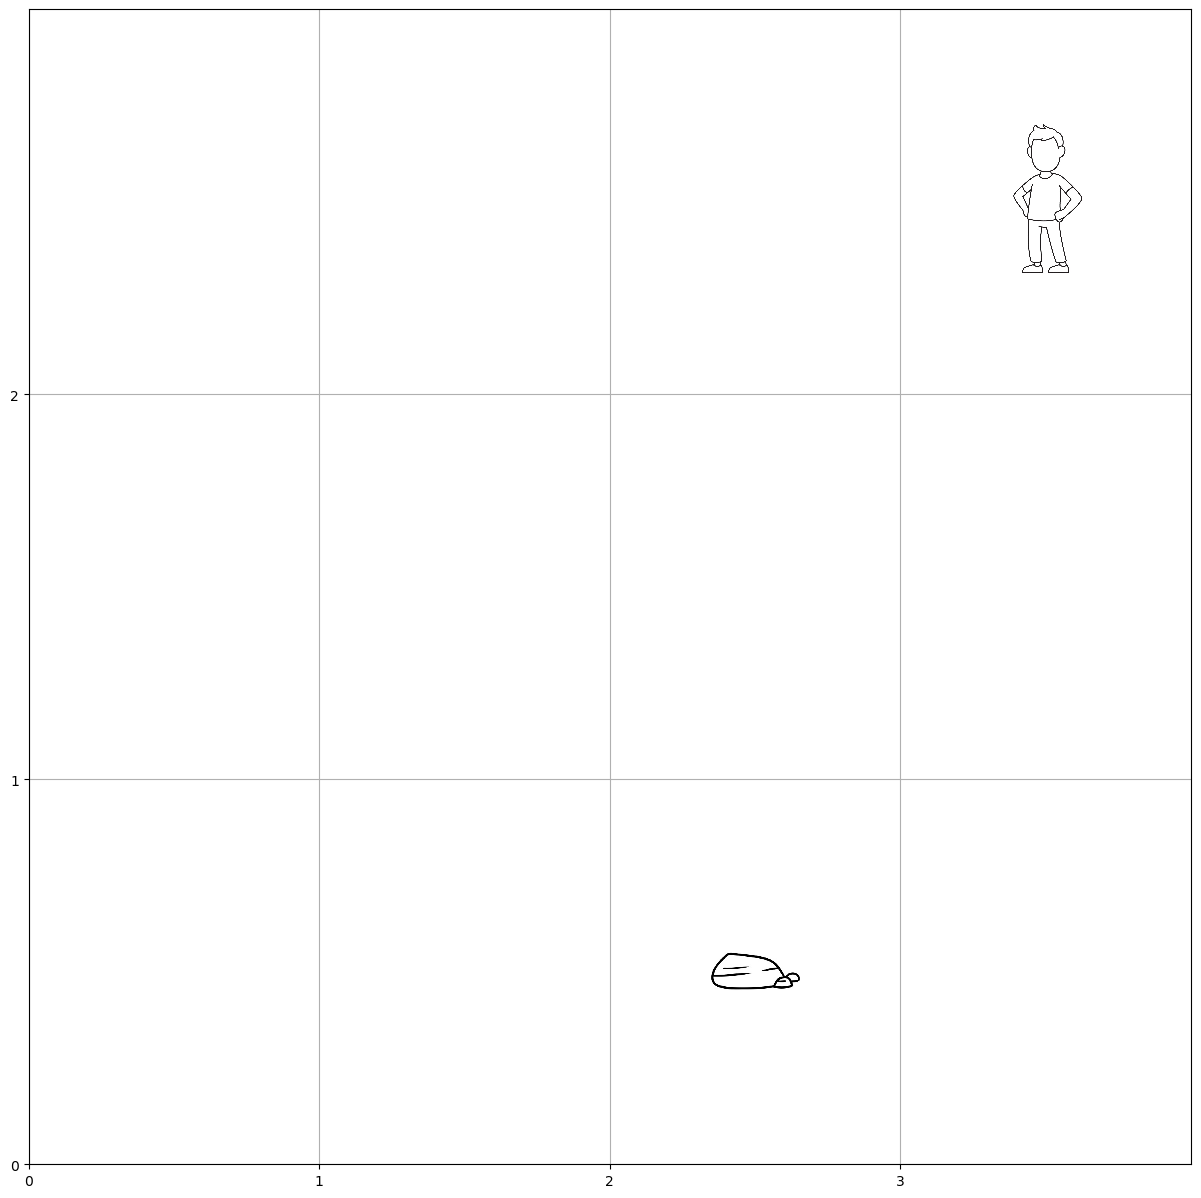

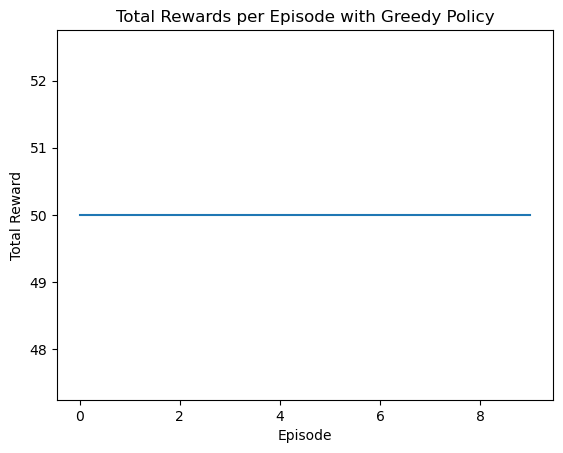

In [19]:
agent = DoubleQLearningAgent(state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

initial_q_table_1 = np.copy(agent.q_table_1)
initial_q_table_2 = np.copy(agent.q_table_2)

episodes = 1000
total_rewards = []
epsilon_values = []  
greedy_total_rewards = []


for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        
    
    total_rewards.append(total_reward)
    epsilon_values.append(agent.epsilon)
    agent.end_episode()

print("Initial Q-Table 1:")
print(f"{initial_q_table_1}")
print("\nInitial Q-Table 2:")
print(f"{initial_q_table_2}")

print("\nTrained Q-Table 1:")
print(f"{agent.q_table_1}")
print("\nTrained Q-Table 2:")
print(f"{agent.q_table_2}")



plt.plot(total_rewards)
plt.title('Total Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(epsilon_values)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()



for _ in range(10): 
    state = env.reset()
    total_reward = 0
    env.render()
    done = False
    while not done:
        action = np.argmax(agent.q_table_1[state] + agent.q_table_2[state])  
        state, _, done, _ = env.step(action)
        env.render()
        total_reward += reward
    greedy_total_rewards.append(total_reward)

plt.plot(greedy_total_rewards)
plt.title('Total Rewards per Episode with Greedy Policy')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

# Hyperparameter tuning

# Discount Factor gamma = 0.95

Initial Q-Table 1:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Initial Q-Table 2:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-Table 1:
[[ 4.65549577e+00  9.29735622e+00  1.74319375e+01  9.25754548e+00]
 [ 3.36164882e-03  9.80131604e+00  3.52630076e+00  1.22910903e+00]
 [ 8.50723625e-01  2.38475807e-01  5.83814876e+00 -7.54400177e-01]
 [ 1.36523632e+00 -8.20384958e-01  7.96139485e+00  9.22386202e-01]
 [ 1.30734736e+01  7.02158348e+00  3.31982943e+00  8.63494436e+00]
 [ 1.37750000e+01  6.04461901e+00  3.32070819e+00  1.99613409e+00]
 [ 1.44997178e+01  7.89132584e+00  5.37135013e+00  2.60926886e+00]
 [ 7.22944089e+00  6.47217497e+00  1.00000000e+01  4.24348609e+00]
 [ 1.90757456e+00  1.48152083e+00  1.897985

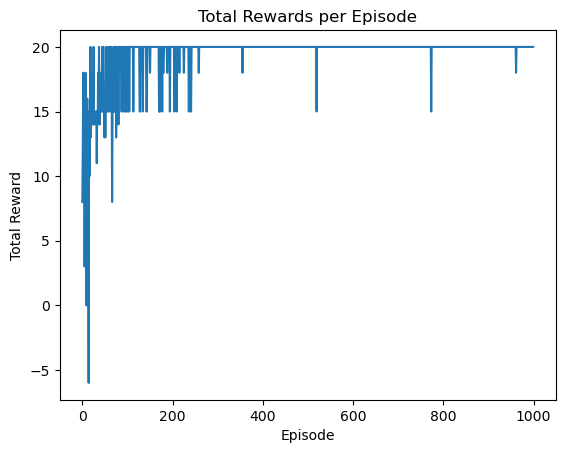

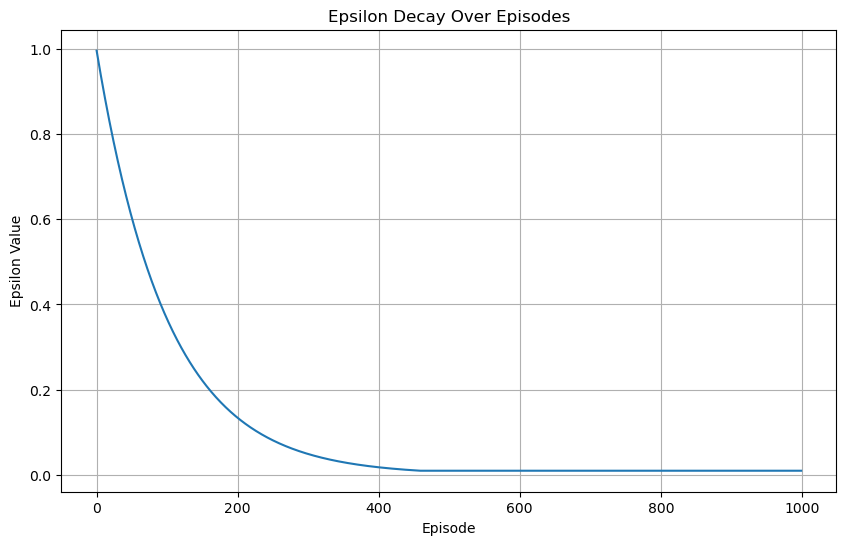

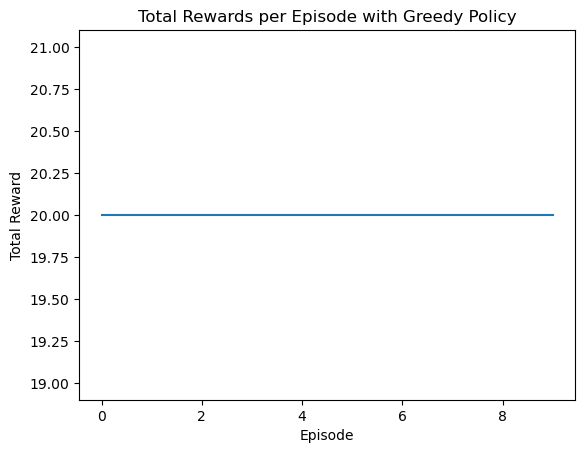

In [20]:
class DoubleQLearningAgent:
    def __init__(self, state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min):
        self.q_table_1 = np.zeros((state_space, action_space))
        self.q_table_2 = np.zeros((state_space, action_space))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.action_space = action_space

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_space)
        else:
            return np.argmax(self.q_table_1[state] + self.q_table_2[state])

    def update(self, state, action, reward, next_state, done):
        if np.random.rand() < 0.5:
            best_next_action = np.argmax(self.q_table_1[next_state])
            td_target = reward + self.gamma * self.q_table_2[next_state][best_next_action] * (not done)
            td_error = td_target - self.q_table_1[state][action]
            self.q_table_1[state][action] += self.alpha * td_error
        else:
            best_next_action = np.argmax(self.q_table_2[next_state])
            td_target = reward + self.gamma * self.q_table_1[next_state][best_next_action] * (not done)
            td_error = td_target - self.q_table_2[state][action]
            self.q_table_2[state][action] += self.alpha * td_error
        
        if done:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def end_episode(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


env = MarathonEnvironment(environment_type='deterministic')


state_space = env.observation_space.n
action_space = env.action_space.n
alpha = 0.1
gamma = 0.95
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
agent = DoubleQLearningAgent(state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min)


episodes = 1000
for episode in range(episodes):
    state = env.reset()
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state



agent = DoubleQLearningAgent(state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min)


initial_q_table_1 = np.copy(agent.q_table_1)
initial_q_table_2 = np.copy(agent.q_table_2)


episodes = 1000
total_rewards = []
epsilon_values = []  

for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    total_rewards.append(total_reward)
    epsilon_values.append(agent.epsilon)
    agent.end_episode()

print("Initial Q-Table 1:")
print(f"{initial_q_table_1}")
print("\nInitial Q-Table 2:")
print(f"{initial_q_table_2}")

print("\nTrained Q-Table 1:")
print(f"{agent.q_table_1}")
print("\nTrained Q-Table 2:")
print(f"{agent.q_table_2}")



plt.plot(total_rewards)
plt.title('Total Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(epsilon_values)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()


greedy_total_rewards = []

for _ in range(10): 
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = np.argmax(agent.q_table_1[state] + agent.q_table_2[state])
        state, reward, done, _ = env.step(action)
        total_reward += reward
    greedy_total_rewards.append(total_reward)

plt.plot(greedy_total_rewards)
plt.title('Total Rewards per Episode with Greedy Policy')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

# Discount Factor gamma = 0.90

Initial Q-Table 1:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Initial Q-Table 2:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-Table 1:
[[ 4.79539462  9.74354838 15.19724589  8.83745104]
 [-0.54250829  9.73284707  1.65536991  1.34226965]
 [ 0.18659484  1.06906448  4.81662176 -0.62799132]
 [ 0.37360631 -0.46794875  7.39659679  0.13831442]
 [11.34        6.062678    2.45979659  7.36715659]
 [12.6         5.87047738  4.71629963  3.01908139]
 [14.          5.69052695  6.43050065  1.17429256]
 [ 6.80078504  5.75351303 10.          2.21409456]
 [ 4.36327712  0.28806491  0.3870343   2.17045168]
 [ 8.34019607  0.40783851  1.5856526   0.48060999]
 [ 9.91272036  1.90947787  3.74384798  2.12707418]
 [ 0.          0. 

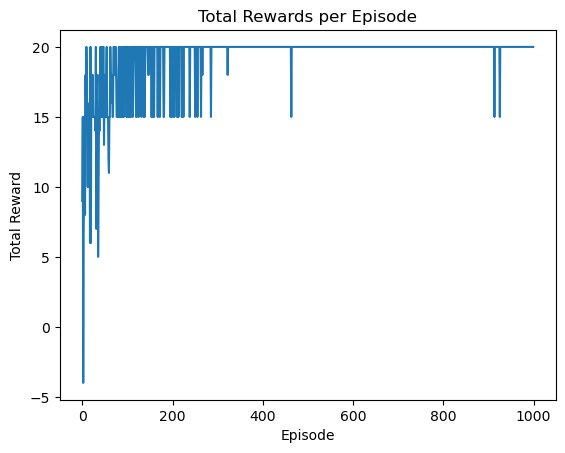

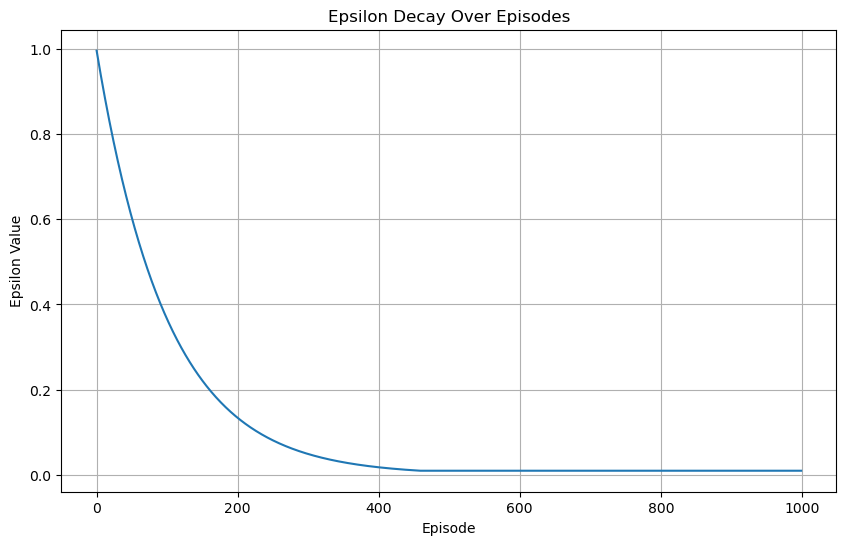

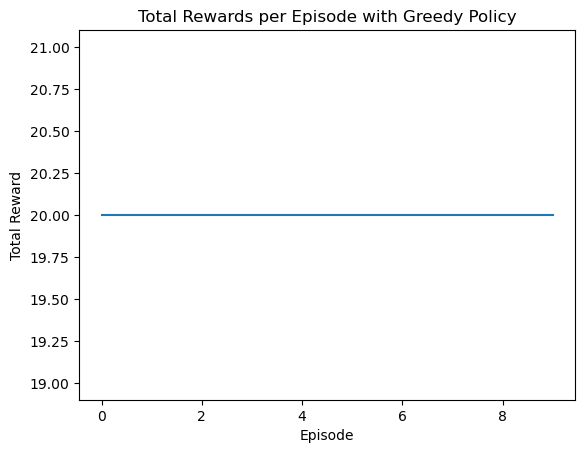

In [21]:
class DoubleQLearningAgent:
    def __init__(self, state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min):
        self.q_table_1 = np.zeros((state_space, action_space))
        self.q_table_2 = np.zeros((state_space, action_space))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.action_space = action_space

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_space)
        else:
            return np.argmax(self.q_table_1[state] + self.q_table_2[state])

    def update(self, state, action, reward, next_state, done):
        if np.random.rand() < 0.5:
            best_next_action = np.argmax(self.q_table_1[next_state])
            td_target = reward + self.gamma * self.q_table_2[next_state][best_next_action] * (not done)
            td_error = td_target - self.q_table_1[state][action]
            self.q_table_1[state][action] += self.alpha * td_error
        else:
            best_next_action = np.argmax(self.q_table_2[next_state])
            td_target = reward + self.gamma * self.q_table_1[next_state][best_next_action] * (not done)
            td_error = td_target - self.q_table_2[state][action]
            self.q_table_2[state][action] += self.alpha * td_error
        
        if done:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def end_episode(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


env = MarathonEnvironment(environment_type='deterministic')


state_space = env.observation_space.n
action_space = env.action_space.n
alpha = 0.1
gamma = 0.90
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
agent = DoubleQLearningAgent(state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

episodes = 1000
for episode in range(episodes):
    state = env.reset()
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state



agent = DoubleQLearningAgent(state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min)


initial_q_table_1 = np.copy(agent.q_table_1)
initial_q_table_2 = np.copy(agent.q_table_2)


episodes = 1000
total_rewards = []
epsilon_values = []  

for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    total_rewards.append(total_reward)
    epsilon_values.append(agent.epsilon)
    agent.end_episode()


print("Initial Q-Table 1:")
print(f"{initial_q_table_1}")
print("\nInitial Q-Table 2:")
print(f"{initial_q_table_2}")

print("\nTrained Q-Table 1:")
print(f"{agent.q_table_1}")
print("\nTrained Q-Table 2:")
print(f"{agent.q_table_2}")



plt.plot(total_rewards)
plt.title('Total Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(epsilon_values)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()

greedy_total_rewards = []

for _ in range(10): 
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = np.argmax(agent.q_table_1[state] + agent.q_table_2[state])
        state, reward, done, _ = env.step(action)
        total_reward += reward
    greedy_total_rewards.append(total_reward)

plt.plot(greedy_total_rewards)
plt.title('Total Rewards per Episode with Greedy Policy')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

# Discount Factor gamma 0.85

Initial Q-Table 1:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Initial Q-Table 2:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-Table 1:
[[ 3.27784206  6.98384577 13.29037421  5.9969042 ]
 [-0.90340064  7.59728101  2.0894881   0.93482743]
 [ 1.84014038  0.32166175  7.23333486 -0.77482258]
 [ 0.73852611 -0.9331951   6.04597517  1.03455514]
 [ 9.74908352  2.8059963   1.72702477  6.44589977]
 [11.475       4.82866566  2.22890327  2.72408774]
 [13.49992833  5.41143431  4.82358674  0.23231633]
 [ 6.22507712  7.06164447 10.          3.32619093]
 [ 0.08409263  0.31672     0.22343537  3.96625328]
 [ 4.12632585  0.43286759  0.39463802  2.25635458]
 [ 9.41850263  0.85272698  1.15188667  1.11783124]
 [ 0.          0. 

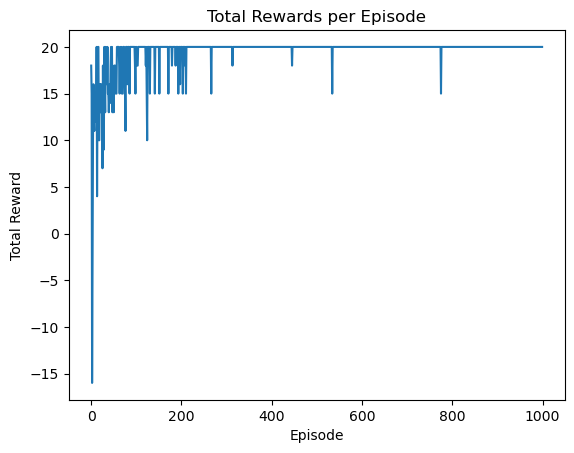

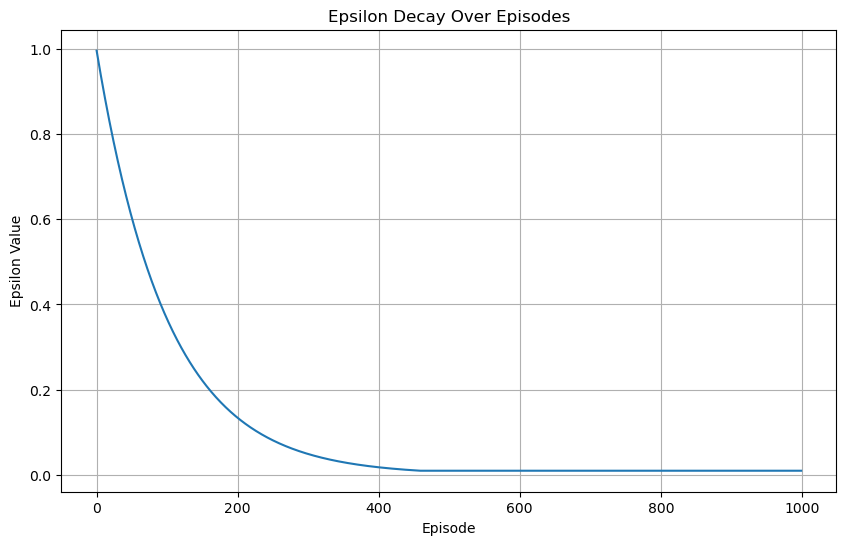

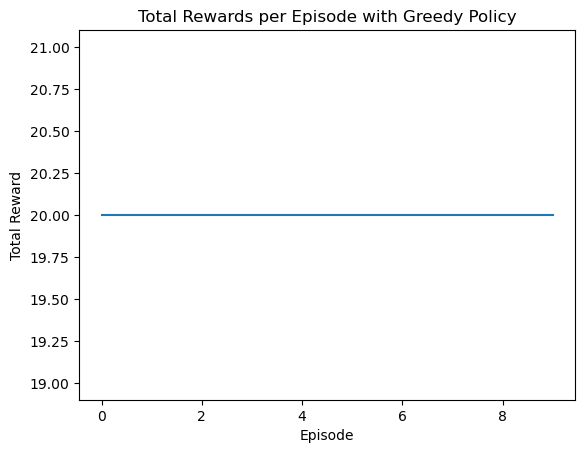

In [23]:
class DoubleQLearningAgent:
    def __init__(self, state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min):
        self.q_table_1 = np.zeros((state_space, action_space))
        self.q_table_2 = np.zeros((state_space, action_space))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.action_space = action_space

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_space)
        else:
            return np.argmax(self.q_table_1[state] + self.q_table_2[state])

    def update(self, state, action, reward, next_state, done):
        if np.random.rand() < 0.5:
            best_next_action = np.argmax(self.q_table_1[next_state])
            td_target = reward + self.gamma * self.q_table_2[next_state][best_next_action] * (not done)
            td_error = td_target - self.q_table_1[state][action]
            self.q_table_1[state][action] += self.alpha * td_error
        else:
            best_next_action = np.argmax(self.q_table_2[next_state])
            td_target = reward + self.gamma * self.q_table_1[next_state][best_next_action] * (not done)
            td_error = td_target - self.q_table_2[state][action]
            self.q_table_2[state][action] += self.alpha * td_error
        
        if done:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def end_episode(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


env = MarathonEnvironment(environment_type='deterministic')


state_space = env.observation_space.n
action_space = env.action_space.n
alpha = 0.1
gamma = 0.85
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
agent = DoubleQLearningAgent(state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min)


episodes = 1000
for episode in range(episodes):
    state = env.reset()
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state



agent = DoubleQLearningAgent(state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min)


initial_q_table_1 = np.copy(agent.q_table_1)
initial_q_table_2 = np.copy(agent.q_table_2)


episodes = 1000
total_rewards = []
epsilon_values = []  


for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    total_rewards.append(total_reward)
    epsilon_values.append(agent.epsilon)
    agent.end_episode()


print("Initial Q-Table 1:")
print(f"{initial_q_table_1}")
print("\nInitial Q-Table 2:")
print(f"{initial_q_table_2}")

print("\nTrained Q-Table 1:")
print(f"{agent.q_table_1}")
print("\nTrained Q-Table 2:")
print(f"{agent.q_table_2}")



plt.plot(total_rewards)
plt.title('Total Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(epsilon_values)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()

greedy_total_rewards = []

for _ in range(10): 
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = np.argmax(agent.q_table_1[state] + agent.q_table_2[state])
        state, reward, done, _ = env.step(action)
        total_reward += reward
    greedy_total_rewards.append(total_reward)

plt.plot(greedy_total_rewards)
plt.title('Total Rewards per Episode with Greedy Policy')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

# Epsilon decay rate 0.99

Initial Q-Table 1:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Initial Q-Table 2:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-Table 1:
[[ 2.02717535e+00  5.58044712e+00  1.94082165e+01  4.60026986e+00]
 [-8.51259197e-01  7.46085420e+00  6.08578476e-01  2.23926890e-01]
 [ 5.39200093e-01  4.18592438e-01  4.33175378e+00 -5.34469990e-01]
 [ 2.44549732e-01 -1.75080695e-01  6.84549594e+00  0.00000000e+00]
 [ 1.46034734e+01  7.73225870e+00  1.46794476e+00  4.96661844e+00]
 [ 1.47510000e+01  5.17397668e+00  1.11545703e+00  1.23768334e+00]
 [ 1.49000000e+01  3.75648512e+00  2.87125076e+00  1.02401416e+00]
 [ 3.68205241e+00  3.83723571e+00  1.00000000e+01  2.85767729e+00]
 [ 1.33911063e-01  3.35811486e-01  3.979173

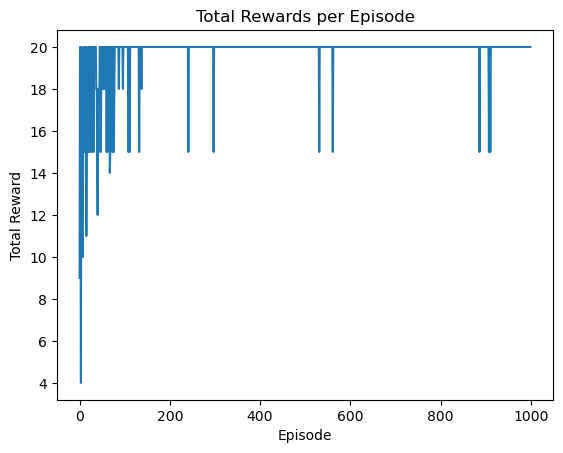

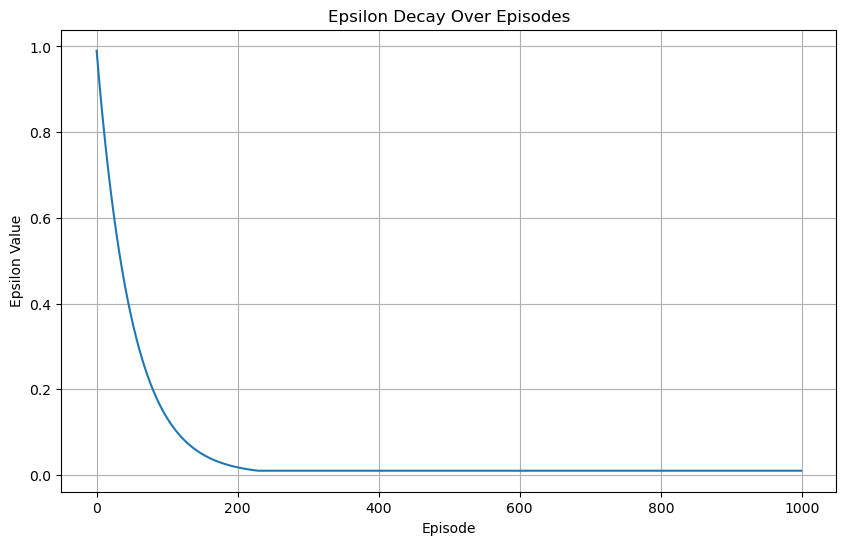

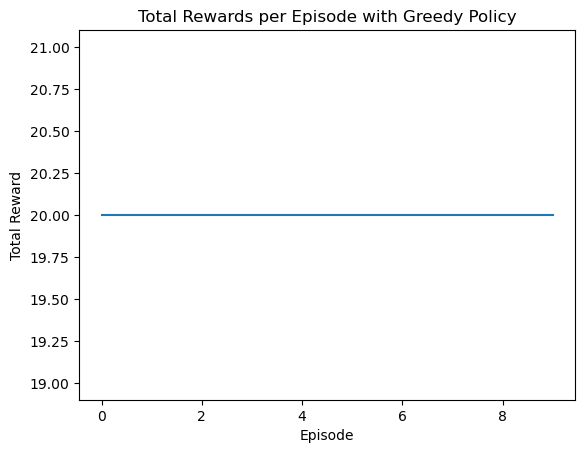

In [24]:
class DoubleQLearningAgent:
    def __init__(self, state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min):
        self.q_table_1 = np.zeros((state_space, action_space))
        self.q_table_2 = np.zeros((state_space, action_space))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.action_space = action_space

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_space)
        else:
            return np.argmax(self.q_table_1[state] + self.q_table_2[state])

    def update(self, state, action, reward, next_state, done):
        if np.random.rand() < 0.5:
            best_next_action = np.argmax(self.q_table_1[next_state])
            td_target = reward + self.gamma * self.q_table_2[next_state][best_next_action] * (not done)
            td_error = td_target - self.q_table_1[state][action]
            self.q_table_1[state][action] += self.alpha * td_error
        else:
            best_next_action = np.argmax(self.q_table_2[next_state])
            td_target = reward + self.gamma * self.q_table_1[next_state][best_next_action] * (not done)
            td_error = td_target - self.q_table_2[state][action]
            self.q_table_2[state][action] += self.alpha * td_error
        
        if done:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def end_episode(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


env = MarathonEnvironment(environment_type='deterministic')


state_space = env.observation_space.n
action_space = env.action_space.n
alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.99
epsilon_min = 0.01
agent = DoubleQLearningAgent(state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min)


episodes = 1000
for episode in range(episodes):
    state = env.reset()
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state



agent = DoubleQLearningAgent(state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min)


initial_q_table_1 = np.copy(agent.q_table_1)
initial_q_table_2 = np.copy(agent.q_table_2)


episodes = 1000
total_rewards = []
epsilon_values = []  

for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
    
    total_rewards.append(total_reward)
    epsilon_values.append(agent.epsilon)
    agent.end_episode()


print("Initial Q-Table 1:")
print(f"{initial_q_table_1}")
print("\nInitial Q-Table 2:")
print(f"{initial_q_table_2}")

print("\nTrained Q-Table 1:")
print(f"{agent.q_table_1}")
print("\nTrained Q-Table 2:")
print(f"{agent.q_table_2}")



plt.plot(total_rewards)
plt.title('Total Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(epsilon_values)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()


greedy_total_rewards = []

for _ in range(10): 
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = np.argmax(agent.q_table_1[state] + agent.q_table_2[state])
        state, reward, done, _ = env.step(action)
        total_reward += reward
    greedy_total_rewards.append(total_reward)

plt.plot(greedy_total_rewards)
plt.title('Total Rewards per Episode with Greedy Policy')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

# Epsilon decay rate 0.90

Initial Q-Table 1:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Initial Q-Table 2:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-Table 1:
[[ 0.00000000e+00  2.22099736e+00  1.32906875e+01  2.19387271e+00]
 [-2.00000000e-01  0.00000000e+00  1.49710279e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.10943954e+00 -3.80000000e-01]
 [ 0.00000000e+00 -2.00000000e-01  1.61454828e+00  0.00000000e+00]
 [ 9.75374967e+00  3.41635263e+00  9.30055824e-03  1.07172998e-01]
 [ 1.14750000e+01  8.29068709e-01  3.25847500e-02  0.00000000e+00]
 [ 1.35000000e+01  0.00000000e+00  2.92315000e-01  9.59052306e-02]
 [ 8.49999895e-01  1.14741441e+00  1.00000000e+01  0.00000000e+00]
 [ 0.00000000e+00  9.30055824e-03  0.000000

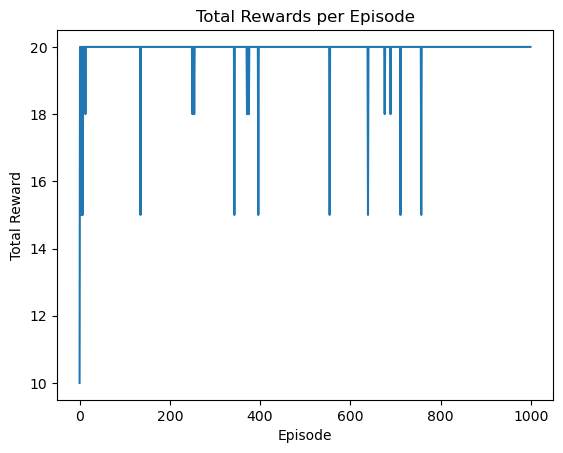

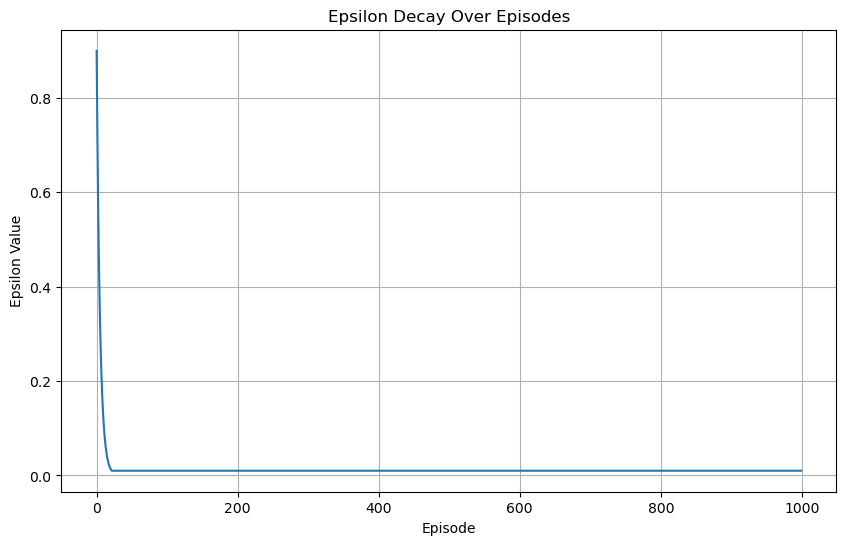

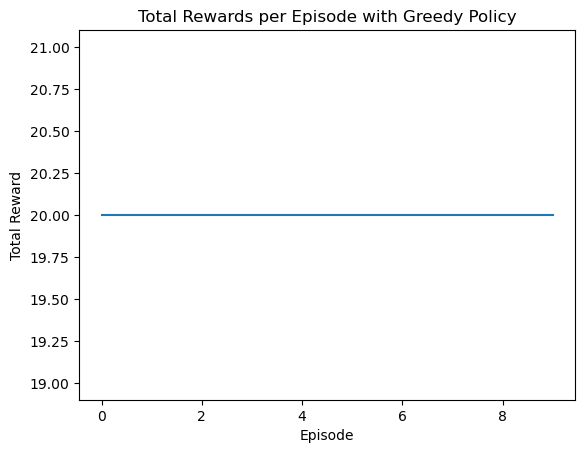

In [25]:
class DoubleQLearningAgent:
    def __init__(self, state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min):
        self.q_table_1 = np.zeros((state_space, action_space))
        self.q_table_2 = np.zeros((state_space, action_space))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.action_space = action_space

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_space)
        else:
            return np.argmax(self.q_table_1[state] + self.q_table_2[state])

    def update(self, state, action, reward, next_state, done):
        if np.random.rand() < 0.5:
            best_next_action = np.argmax(self.q_table_1[next_state])
            td_target = reward + self.gamma * self.q_table_2[next_state][best_next_action] * (not done)
            td_error = td_target - self.q_table_1[state][action]
            self.q_table_1[state][action] += self.alpha * td_error
        else:
            best_next_action = np.argmax(self.q_table_2[next_state])
            td_target = reward + self.gamma * self.q_table_1[next_state][best_next_action] * (not done)
            td_error = td_target - self.q_table_2[state][action]
            self.q_table_2[state][action] += self.alpha * td_error
        
        if done:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def end_episode(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


env = MarathonEnvironment(environment_type='deterministic')


state_space = env.observation_space.n
action_space = env.action_space.n
alpha = 0.1
gamma = 0.85
epsilon = 1.0
epsilon_decay = 0.90
epsilon_min = 0.01
agent = DoubleQLearningAgent(state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min)


episodes = 1000
for episode in range(episodes):
    state = env.reset()
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state



agent = DoubleQLearningAgent(state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min)


initial_q_table_1 = np.copy(agent.q_table_1)
initial_q_table_2 = np.copy(agent.q_table_2)


episodes = 1000
total_rewards = []
epsilon_values = []  

for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
    
    total_rewards.append(total_reward)
    epsilon_values.append(agent.epsilon)
    agent.end_episode()


print("Initial Q-Table 1:")
print(f"{initial_q_table_1}")
print("\nInitial Q-Table 2:")
print(f"{initial_q_table_2}")

print("\nTrained Q-Table 1:")
print(f"{agent.q_table_1}")
print("\nTrained Q-Table 2:")
print(f"{agent.q_table_2}")



plt.plot(total_rewards)
plt.title('Total Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(epsilon_values)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()

greedy_total_rewards = []

for _ in range(10): 
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = np.argmax(agent.q_table_1[state] + agent.q_table_2[state])
        state, reward, done, _ = env.step(action)
        total_reward += reward
    greedy_total_rewards.append(total_reward)

plt.plot(greedy_total_rewards)
plt.title('Total Rewards per Episode with Greedy Policy')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()


# Epsilon Decay rate 0.85

Initial Q-Table 1:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Initial Q-Table 2:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-Table 1:
[[ 0.19571568  2.21710449 13.24144895  1.17690588]
 [ 0.          2.3848277   0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.         -0.38        3.28641276  0.        ]
 [ 9.75374323  0.84071188  0.          2.03623815]
 [11.475       0.91996035  0.          0.09135837]
 [13.4999998   1.85319137  0.1615     -0.2       ]
 [ 0.          1.1475     10.          0.4133842 ]
 [ 0.          0.          0.          0.82906875]
 [ 0.          0.          0.          0.        ]
 [ 2.71        0.          0.          0.        ]
 [ 0.          0. 

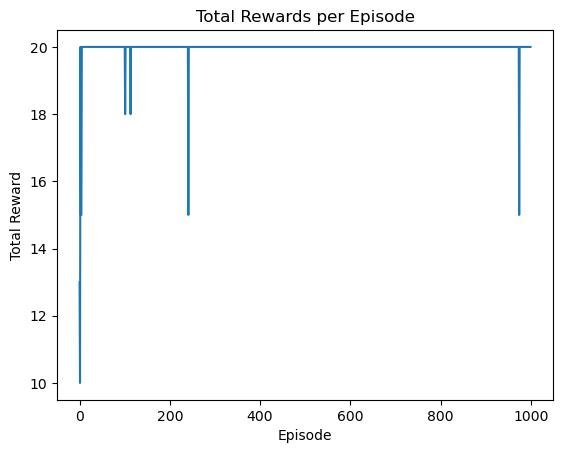

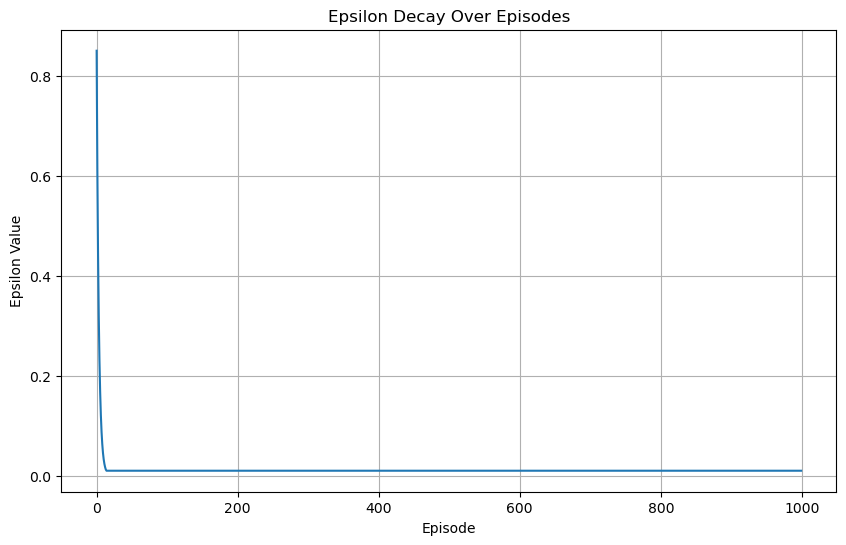

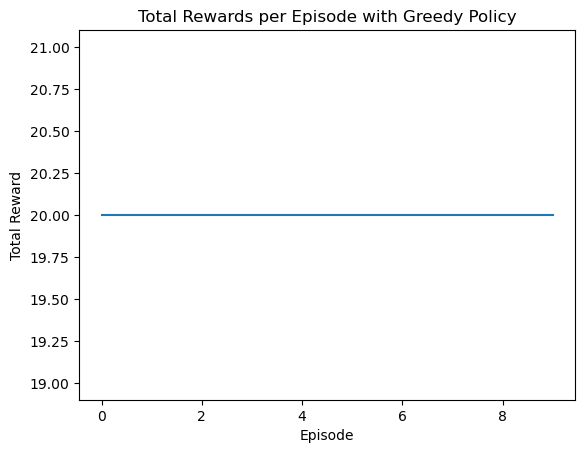

In [26]:
class DoubleQLearningAgent:
    def __init__(self, state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min):
        self.q_table_1 = np.zeros((state_space, action_space))
        self.q_table_2 = np.zeros((state_space, action_space))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.action_space = action_space

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_space)
        else:
            return np.argmax(self.q_table_1[state] + self.q_table_2[state])

    def update(self, state, action, reward, next_state, done):
        if np.random.rand() < 0.5:
            best_next_action = np.argmax(self.q_table_1[next_state])
            td_target = reward + self.gamma * self.q_table_2[next_state][best_next_action] * (not done)
            td_error = td_target - self.q_table_1[state][action]
            self.q_table_1[state][action] += self.alpha * td_error
        else:
            best_next_action = np.argmax(self.q_table_2[next_state])
            td_target = reward + self.gamma * self.q_table_1[next_state][best_next_action] * (not done)
            td_error = td_target - self.q_table_2[state][action]
            self.q_table_2[state][action] += self.alpha * td_error
        
        if done:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def end_episode(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


env = MarathonEnvironment(environment_type='deterministic')


state_space = env.observation_space.n
action_space = env.action_space.n
alpha = 0.1
gamma = 0.85
epsilon = 1.0
epsilon_decay = 0.85
epsilon_min = 0.01
agent = DoubleQLearningAgent(state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min)


episodes = 1000
for episode in range(episodes):
    state = env.reset()
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state



agent = DoubleQLearningAgent(state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min)


initial_q_table_1 = np.copy(agent.q_table_1)
initial_q_table_2 = np.copy(agent.q_table_2)


episodes = 1000
total_rewards = []
epsilon_values = []  

for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
    
    total_rewards.append(total_reward)
    epsilon_values.append(agent.epsilon)
    agent.end_episode()


print("Initial Q-Table 1:")
print(f"{initial_q_table_1}")
print("\nInitial Q-Table 2:")
print(f"{initial_q_table_2}")

print("\nTrained Q-Table 1:")
print(f"{agent.q_table_1}")
print("\nTrained Q-Table 2:")
print(f"{agent.q_table_2}")



plt.plot(total_rewards)
plt.title('Total Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(epsilon_values)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()

greedy_total_rewards = []

for _ in range(10): 
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = np.argmax(agent.q_table_1[state] + agent.q_table_2[state])
        state, reward, done, _ = env.step(action)
        total_reward += reward
    greedy_total_rewards.append(total_reward)

plt.plot(greedy_total_rewards)
plt.title('Total Rewards per Episode with Greedy Policy')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()


# Bonus

In [33]:
import numpy as np
import random
from collections import deque

class DoubleQLearningAgent:
    def __init__(self, state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min, n_step):
        self.q_table_1 = np.zeros((state_space, action_space))
        self.q_table_2 = np.zeros((state_space, action_space))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.action_space = action_space
        self.n_step = n_step
        self.memory = deque(maxlen=n_step)

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_space)
        else:
            return np.argmax(self.q_table_1[state] + self.q_table_2[state])

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def n_step_update(self):
        if len(self.memory) >= self.n_step or self.memory[-1][4]:
            G = 0
            for i in reversed(range(len(self.memory))):
                state, action, reward, next_state, done = self.memory[i]
                G = reward + self.gamma * G * (not done)
                if i == len(self.memory) - self.n_step:
                    break
            
            state, action, _, next_state, done = self.memory[0]
            
            if np.random.rand() < 0.5:
                best_next_action = np.argmax(self.q_table_1[next_state])
                td_target = G + (self.gamma ** self.n_step) * self.q_table_2[next_state][best_next_action] * (not done)
                self.q_table_1[state][action] += self.alpha * (td_target - self.q_table_1[state][action])
            else:
                best_next_action = np.argmax(self.q_table_2[next_state])
                td_target = G + (self.gamma ** self.n_step) * self.q_table_1[next_state][best_next_action] * (not done)
                self.q_table_2[state][action] += self.alpha * (td_target - self.q_table_2[state][action])
            
            self.memory.popleft()

    def end_episode(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


In [34]:
agent = DoubleQLearningAgent(state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min, n_step=3)

for episode in range(episodes):
    state = env.reset()
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.store_transition(state, action, reward, next_state, done)
        agent.n_step_update()
        state = next_state
    agent.end_episode()


Episode: 0, Total Reward: -2.0, Epsilon: 0.995
Episode: 100, Total Reward: 18.0, Epsilon: 0.6027415843082742
Episode: 200, Total Reward: 14.0, Epsilon: 0.36512303261753626
Episode: 300, Total Reward: 18.0, Epsilon: 0.2211807388415433
Episode: 400, Total Reward: 15.0, Epsilon: 0.13398475271138335
Episode: 500, Total Reward: 20.0, Epsilon: 0.0811640021330769
Episode: 600, Total Reward: 15.0, Epsilon: 0.04916675299948831
Episode: 700, Total Reward: 20.0, Epsilon: 0.029783765425331846
Episode: 800, Total Reward: 15.0, Epsilon: 0.018042124582040707
Episode: 900, Total Reward: 15.0, Epsilon: 0.010929385683282892


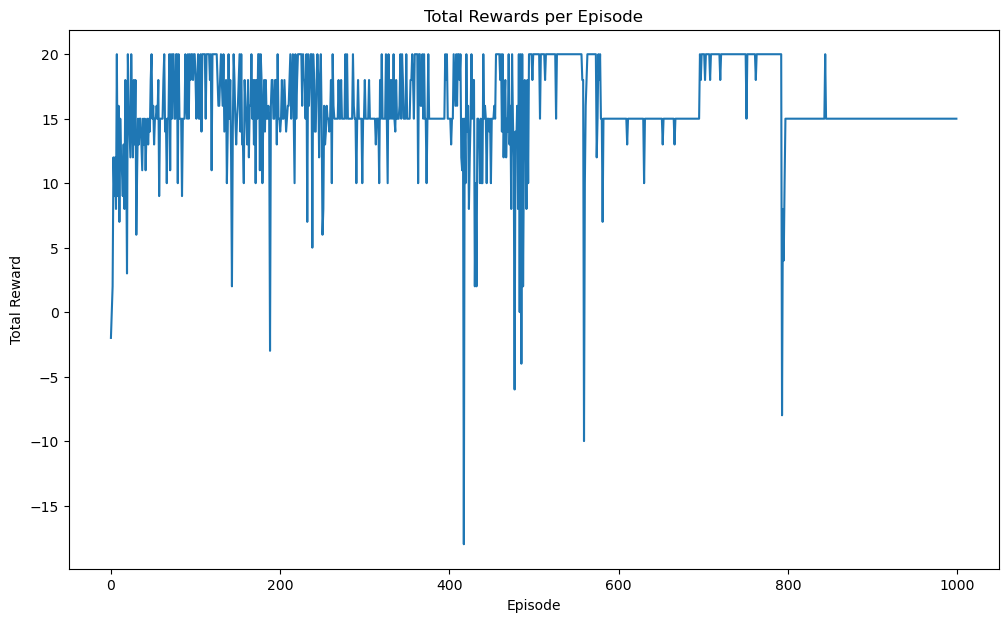

Average Reward in Evaluation Over 100 Episodes: 10.0


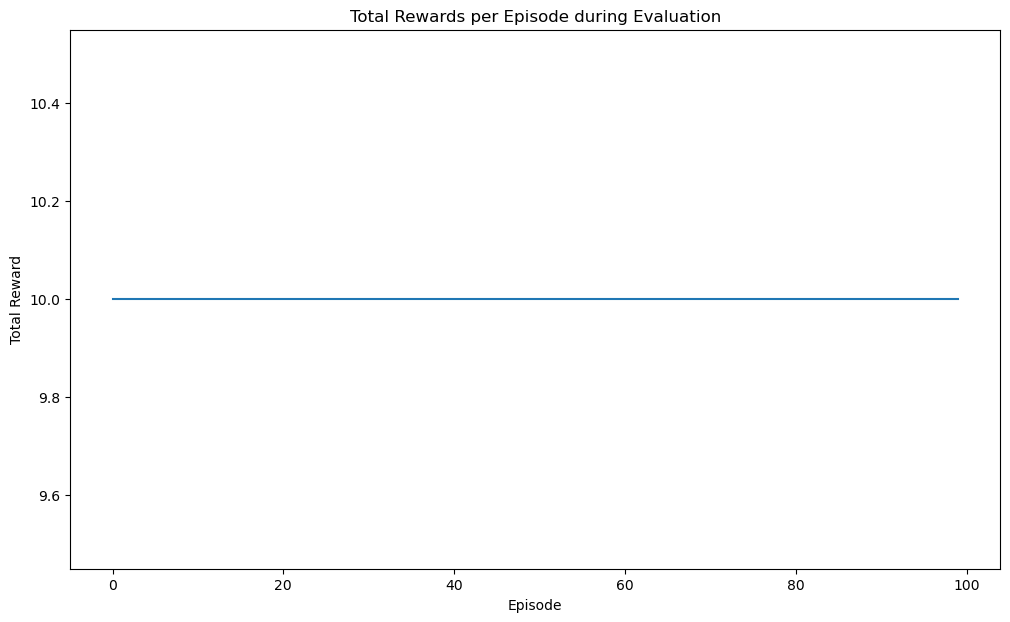

In [35]:
from gymnasium import spaces
import numpy as np
from collections import deque
import matplotlib.pyplot as plt


env = MarathonEnvironment(environment_type='deterministic')

state_space = env.observation_space.n
action_space = env.action_space.n
alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
n_step = 3  

agent = DoubleQLearningAgent(state_space, action_space, alpha, gamma, epsilon, epsilon_decay, epsilon_min, n_step)

episodes = 1000
rewards_per_episode = []  


for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.store_transition(state, action, reward, next_state, done)
        agent.n_step_update()
        state = next_state
        total_reward += reward

    agent.end_episode()
    rewards_per_episode.append(total_reward)

    if episode % 100 == 0:
        print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")


plt.figure(figsize=(12, 7))
plt.plot(rewards_per_episode)
plt.title('Total Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()


eval_episodes = 100
eval_rewards_per_episode = []  

for episode in range(eval_episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:

        action = np.argmax(agent.q_table_1[state] + agent.q_table_2[state])
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward

    eval_rewards_per_episode.append(total_reward)


average_eval_reward = np.mean(eval_rewards_per_episode)
print(f"Average Reward in Evaluation Over {eval_episodes} Episodes: {average_eval_reward}")


plt.figure(figsize=(12, 7))
plt.plot(eval_rewards_per_episode)
plt.title('Total Rewards per Episode during Evaluation')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()
